*   x.4 = Diffential ML in tensorflow : with Siren as backbone or not
*   x.5 = Diffential ML in pytorch with Siren as backbone
*   x.6 = Diffential ML in pytorch with MLP as backbone



# **Import**

In [16]:
%cd /content
! git clone https://github.com/Tikquuss/lwd
%cd lwd/scripts

In [17]:
try:
    %tensorflow_version 1.x
    %matplotlib inline
except Exception:
    pass

import tensorflow as tf
import torch.nn.functional as F
import torch
import numpy as np
import random

from utils import MLP_Relu, plot_stat
from diff_ml_utils import graph, get_diffML_data_loader, BlackScholes, Bachelier

# to avoid collision
from utils import Siren as tf_Siren
from diff_ml_utils import test as diff_ml_test
from diff_ml_utils_tf import test as diff_ml_test_tf_siren

from twin_net import Siren, MLP, TwinNet, train, test

In [18]:
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_random_seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [19]:
nTrain = 10
nTest = 10
train_seed, test_seed = 0, 0
batch_size = 10

learning_rate = 0.0001
learning_rate_schedule=[ (0.0, 1.0e-8), (0.2, 0.1), (0.6, 0.01), (0.9, 1.0e-6), (1.0, 1.0e-8)]

max_epoch = 100
improving_limit = 10

HIDDEN_DIM = 20
N_HIDDEN = 4


first_omega_0 = 30
hidden_omega_0 = 30.
outermost_linear = True

### **To avoid repeating the same code too much**

In [20]:
def batch_to_list(batchs):
    r = []
    for e in batchs :
        x = e.detach().numpy()
        for f in x :  
            r.append([f[0]])
    return np.array(r)

def run_train(name, generator, with_derivative, model_class, model_kwargs, deltidx = 0, lam = 1, normalize = True):
    global learning_rate_schedule
    global nTrain, nTest, train_seed, test_seed, batch_size, learning_rate
    train_dataloader, test_dataloader, xAxis, vegas, config = get_diffML_data_loader(
        generator = generator, 
        nTrain = nTrain, nTest = nTest, 
        train_seed = train_seed, test_seed = test_seed, batch_size = batch_size, with_derivative = with_derivative,
        normalize = normalize
    )
    config["learning_rate_schedule"] = learning_rate_schedule
    config["description"] = ""

    model = model_class(**model_kwargs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    model, stats, best_loss = train(model, train_dataloader, optimizer, criterion, config, lam,
                                    with_derivative = with_derivative, max_epoch = max_epoch, 
                                    improving_limit = improving_limit)

    plot_stat(stats, with_derivative = with_derivative)

    if with_derivative :
        loss, _, _, (yTest, dydxTest, values, deltas) = test(model, test_dataloader, criterion, config, lam, 
                                                             with_derivative = with_derivative)
    else :
        loss, (yTest, values) = test(model, test_dataloader, criterion, config, lam,
                                     with_derivative = with_derivative)
    
    values =  batch_to_list(values) 
    yTest = batch_to_list(yTest) 

    values = {("standard", nTest) : values,
              #("differential", nTest) : []
            }
    try :
        graph(name, values, xAxis, "", "values", yTest, [nTest], True)
    except (KeyError, TypeError) :
        pass
  
    if with_derivative :
        deltas = batch_to_list(deltas) 
        deltas = {("standard", nTest) : deltas[:, deltidx],
                  #("differential", nTest) : []
        }
        dydxTest = batch_to_list(dydxTest) 
        try :
            graph(name, deltas, xAxis, "", "deltas", dydxTest[:, deltidx], [nTest], True)
        except (KeyError, TypeError) :
            pass
        
    return model, loss

def run_diffML_train(name, generator, generator_kwargs, show_graph_per_axis = False, input_dim = None, siren = False):
    global nTrain, nTest, train_seed, test_seed
    global max_epoch
    global first_omega_0, hidden_omega_0, outermost_linear
    if siren :
        loss, regressor, dtrain, dtest, dydxTest, values, deltas, xAxis, vegas = diff_ml_test_tf_siren(
              generator, [nTrain], 
              nTrain, nTest, 
              trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
              deltidx=0,
              generator_kwargs = generator_kwargs,
              epochs = max_epoch,
              first_omega_0 = first_omega_0, 
              hidden_omega_0 = hidden_omega_0, 
              outermost_linear = outermost_linear
              ) 
    else :
        loss, regressor, dtrain, dtest, dydxTest, values, deltas, xAxis, vegas = diff_ml_test(
              generator, [nTrain], 
              nTrain, nTest, 
              trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
              deltidx=0,
              generator_kwargs = generator_kwargs,
              epochs = max_epoch
              )
        
    yTest = dtest[1]
    sizes = [nTrain]
    # show predicitions
    graph(name, values, xAxis, "", "values", yTest, [nTrain], True)
    # show deltas
    graph(name, deltas, xAxis, "", "deltas", dydxTest, [nTrain], True)

    if show_graph_per_axis :
        assert input_dim
        for i in range(input_dim) :
            xAxis  = np.array([[x[i]] for x in dtest[0]])
            # show predicitions
            graph("%s x%d vs y" % (name, (i+1)), values, xAxis, "", "values", yTest, [nTrain], True)
            # show deltas
            graph("%s x%d vs dxdy" % (name, (i+1)), deltas, xAxis, "", "deltas", dydxTest, [nTrain], True)

    return regressor, loss


def run_twinNet_train(name, generator, with_derivative, model_class, model_kwargs, deltidx = 0, lam = 1, normalize = True):
    global learning_rate_schedule
    global nTrain, nTest, train_seed, test_seed, batch_size, learning_rate, max_epoch, improving_limit
    
    train_dataloader, test_dataloader, xAxis, vegas, config = get_diffML_data_loader(
        generator = generator, 
        nTrain = nTrain, nTest = nTest, 
        train_seed = train_seed, test_seed = test_seed, batch_size = batch_size, 
        with_derivative = with_derivative, normalize = normalize
    )

    config["learning_rate_schedule"] = learning_rate_schedule
    config["description"] = ""

    model = model_class(**model_kwargs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    tn = TwinNet(model = model, optimizer = optimizer, criterion = criterion)

    tn.train(train_dataloader, config, lam, with_derivative, max_epoch, improving_limit)

    plot_stat(tn.stats, with_derivative)

    if with_derivative :
        loss, _, _, (yTest, dydxTest, values, deltas) = tn.test(test_dataloader, config, lam, with_derivative)
    else :
        loss, (yTest, values) = tn.test(test_dataloader, config, lam, with_derivative)
    
    values =  batch_to_list(values) 
    yTest = batch_to_list(yTest) 

    values = {("standard", nTest) : values,
              #("differential", nTest) : []
            }
    try :
        graph(name, values, xAxis, "", "values", yTest, [nTest], True)
    except (KeyError, TypeError) :
        pass
  
    if with_derivative :
        deltas = batch_to_list(deltas) 
        deltas = {("standard", nTest) : deltas[:, deltidx],
                  #("differential", nTest) : []
        }
        dydxTest = batch_to_list(dydxTest) 
        try :
            graph(name, deltas, xAxis, "", "deltas", dydxTest[:, deltidx], [nTest], True)
        except (KeyError, TypeError) :
            pass
        
    return tn, loss

# **1) Black & Scholes**

In [21]:
INPUT_DIM = 1

generator = BlackScholes()
graph_name = "Black & Scholes"

## **1.1) Normal Training**

### **normalize = False**

Epoch 0: train loss: 0.15168188512325287 train loss no scaled: 0.15168188512325287
Epoch 1: train loss: 0.15126203000545502 train loss no scaled: 0.15126203000545502
Epoch 2: train loss: 0.1508432924747467 train loss no scaled: 0.1508432924747467
Epoch 3: train loss: 0.15042568743228912 train loss no scaled: 0.15042568743228912
Epoch 4: train loss: 0.1500096172094345 train loss no scaled: 0.1500096172094345
Epoch 5: train loss: 0.14959467947483063 train loss no scaled: 0.14959467947483063
Epoch 6: train loss: 0.14918088912963867 train loss no scaled: 0.14918088912963867
Epoch 7: train loss: 0.14876827597618103 train loss no scaled: 0.14876827597618103
Epoch 8: train loss: 0.14835679531097412 train loss no scaled: 0.14835679531097412
Epoch 9: train loss: 0.1479465365409851 train loss no scaled: 0.1479465365409851
Epoch 10: train loss: 0.1475374400615692 train loss no scaled: 0.1475374400615692
Epoch 11: train loss: 0.14712956547737122 train loss no scaled: 0.14712956547737122
Epoch 12: 

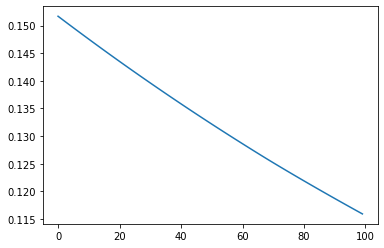

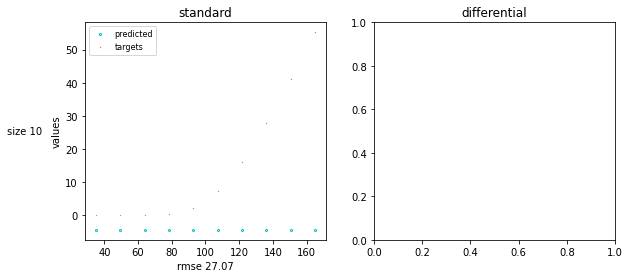

In [22]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = False, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = False
)

### **normalize = True**

Epoch 0: train loss: 1.0043784379959106 train loss no scaled: 0.042104750871658325
Epoch 1: train loss: 1.0042914152145386 train loss no scaled: 0.04210110753774643
Epoch 2: train loss: 1.004205346107483 train loss no scaled: 0.04209750145673752
Epoch 3: train loss: 1.0041202306747437 train loss no scaled: 0.04209392890334129
Epoch 4: train loss: 1.0040359497070312 train loss no scaled: 0.04209039732813835
Epoch 5: train loss: 1.0039526224136353 train loss no scaled: 0.042086903005838394
Epoch 6: train loss: 1.0038703680038452 train loss no scaled: 0.04208344966173172
Epoch 7: train loss: 1.0037879943847656 train loss no scaled: 0.042080000042915344
Epoch 8: train loss: 1.003706693649292 train loss no scaled: 0.042076583951711655
Epoch 9: train loss: 1.0036256313323975 train loss no scaled: 0.04207319766283035
Epoch 10: train loss: 1.0035452842712402 train loss no scaled: 0.042069826275110245
Epoch 11: train loss: 1.0034650564193726 train loss no scaled: 0.04206646606326103
Epoch 12: t

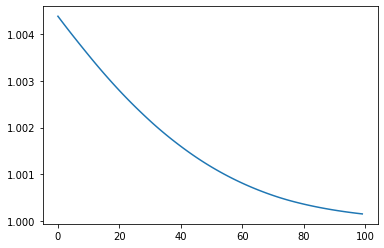

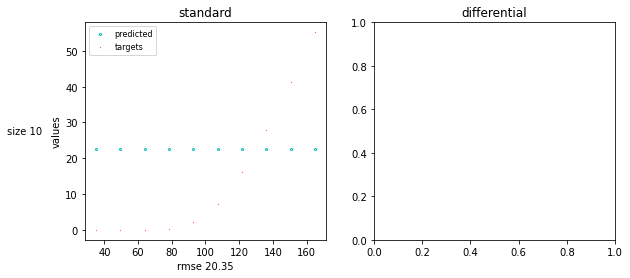

In [23]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = False, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = True
)

## **1.2) Sobolev Training**

### **normalize = False**

Epoch 0: train loss: 0.699230968952179, y loss : 0.051736462861299515, dy loss : 0.6474944949150085
train loss no scaled: 0.6992309577763081, y loss  no scaled : 0.051736462861299515, dy loss  no scaled: 0.6474944949150085
Epoch 1: train loss: 0.6991435885429382, y loss : 0.051628824323415756, dy loss : 0.6475147604942322
train loss no scaled: 0.6991435848176479, y loss  no scaled : 0.051628824323415756, dy loss  no scaled: 0.6475147604942322
Epoch 2: train loss: 0.6990319490432739, y loss : 0.05152175575494766, dy loss : 0.6475101709365845
train loss no scaled: 0.6990319266915321, y loss  no scaled : 0.05152175575494766, dy loss  no scaled: 0.6475101709365845
Epoch 3: train loss: 0.6989206671714783, y loss : 0.051415253430604935, dy loss : 0.6475054025650024
train loss no scaled: 0.6989206559956074, y loss  no scaled : 0.051415253430604935, dy loss  no scaled: 0.6475054025650024
Epoch 4: train loss: 0.6988099813461304, y loss : 0.05130934342741966, dy loss : 0.6475006341934204
train l

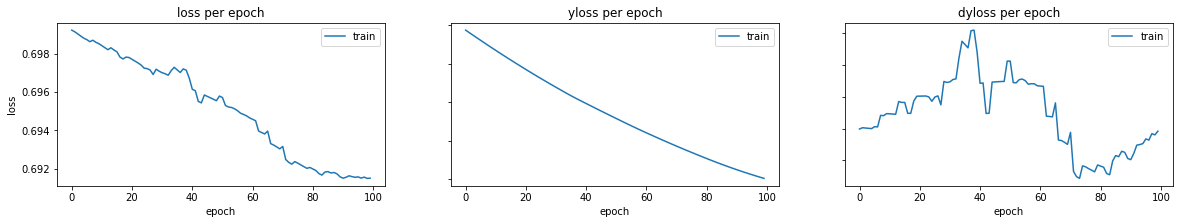

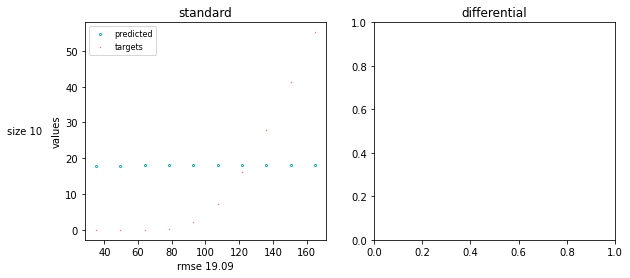

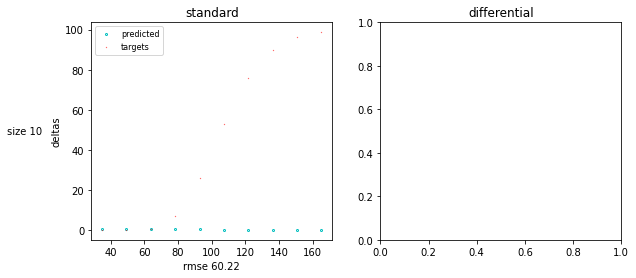

In [24]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = False
)

### **normalize = True**

Epoch 0: train loss: 1.002029694327576, y loss : 1.0007632970809937, dy loss : 1.0032960915741582
train loss no scaled: 0.6922142393887043, y loss  no scaled : 0.041953194886446, dy loss  no scaled: 0.6502610445022583
Epoch 1: train loss: 1.0020549499698992, y loss : 1.0007325410842896, dy loss : 1.0033773588555088
train loss no scaled: 0.6922656483948231, y loss  no scaled : 0.04195191338658333, dy loss  no scaled: 0.6503137350082397
Epoch 2: train loss: 1.0020806477548774, y loss : 1.0007025003433228, dy loss : 1.003458795166432
train loss no scaled: 0.6923171356320381, y loss  no scaled : 0.04195065051317215, dy loss  no scaled: 0.650366485118866
Epoch 3: train loss: 1.002080132211498, y loss : 1.0006729364395142, dy loss : 1.003487327983482
train loss no scaled: 0.6923343725502491, y loss  no scaled : 0.04194940999150276, dy loss  no scaled: 0.6503849625587463
Epoch 4: train loss: 1.0020990895572646, y loss : 1.0006440877914429, dy loss : 1.0035540913230865
train loss no scaled: 0.

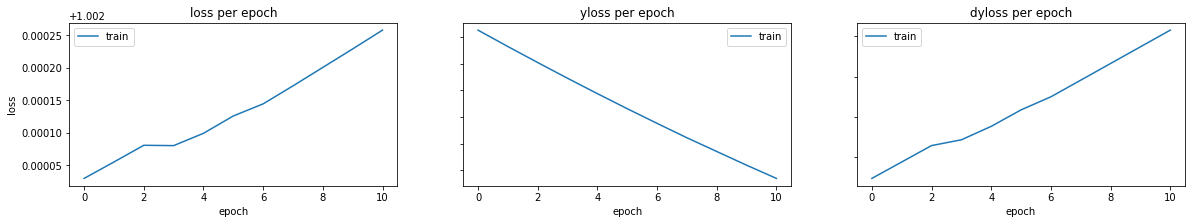

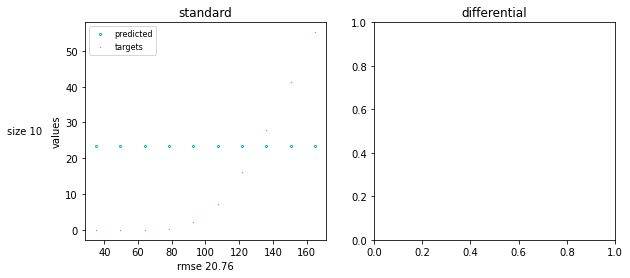

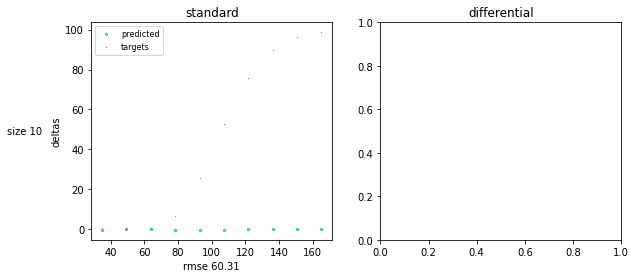

In [25]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = True
)

## **1.3) SIREN**

### **normalize = False**

Epoch 0: train loss: 1.2085731029510498, y loss : 0.05785054713487625, dy loss : 1.1507225036621094
train loss no scaled: 1.2085730507969856, y loss  no scaled : 0.05785054713487625, dy loss  no scaled: 1.1507225036621094
Epoch 1: train loss: 1.065390706062317, y loss : 0.054424285888671875, dy loss : 1.010966420173645
train loss no scaled: 1.065390706062317, y loss  no scaled : 0.054424285888671875, dy loss  no scaled: 1.010966420173645
Epoch 2: train loss: 0.9307584762573242, y loss : 0.05154835805296898, dy loss : 0.8792101144790649
train loss no scaled: 0.9307584725320339, y loss  no scaled : 0.05154835805296898, dy loss  no scaled: 0.8792101144790649
Epoch 3: train loss: 0.8145609498023987, y loss : 0.04922010377049446, dy loss : 0.7653408646583557
train loss no scaled: 0.8145609684288502, y loss  no scaled : 0.04922010377049446, dy loss  no scaled: 0.7653408646583557
Epoch 4: train loss: 0.7163771390914917, y loss : 0.047389570623636246, dy loss : 0.6689875721931458
train loss no

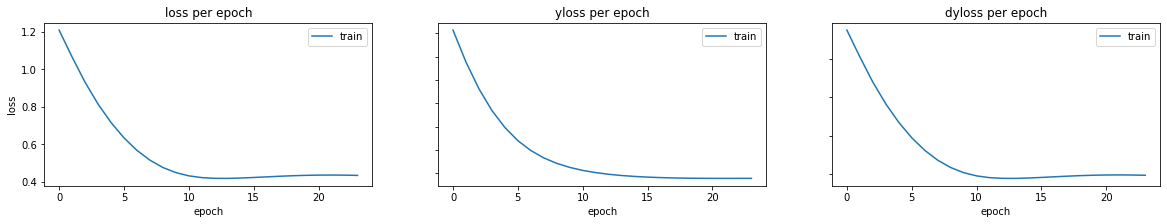

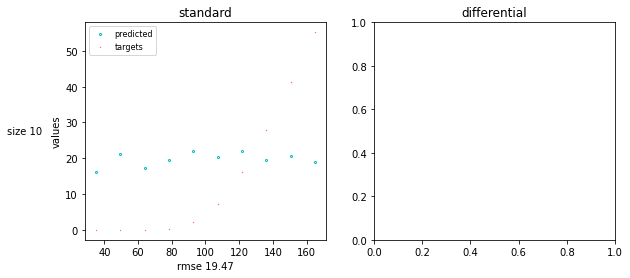

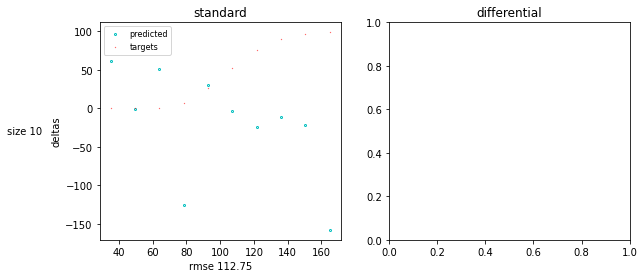

In [26]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = tf_Siren, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1,
                          "outermost_linear" : True},
          normalize = False
)

### **normalize = True**

Epoch 0: train loss: 1.1348563670153888, y loss : 1.0252313613891602, dy loss : 1.2444813726416173
train loss no scaled: 0.849558163434267, y loss  no scaled : 0.042978931218385696, dy loss  no scaled: 0.8065792322158813
Epoch 1: train loss: 1.0793751198600658, y loss : 1.0224881172180176, dy loss : 1.1362621225021141
train loss no scaled: 0.7793035171926022, y loss  no scaled : 0.04286393150687218, dy loss  no scaled: 0.73643958568573
Epoch 2: train loss: 1.0663734094404997, y loss : 1.0198981761932373, dy loss : 1.1128486426877624
train loss no scaled: 0.7640200704336166, y loss  no scaled : 0.04275535047054291, dy loss  no scaled: 0.7212647199630737
Epoch 3: train loss: 1.0833088771053785, y loss : 1.0174963474273682, dy loss : 1.1491214067833888
train loss no scaled: 0.7874287217855453, y loss  no scaled : 0.04265467822551727, dy loss  no scaled: 0.7447740435600281
Epoch 4: train loss: 1.1149427412304354, y loss : 1.015304446220398, dy loss : 1.2145810362404725
train loss no scaled

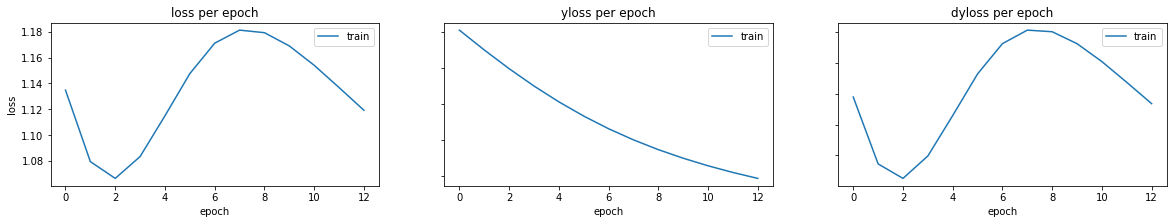

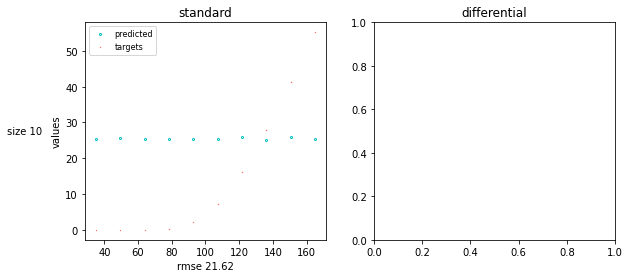

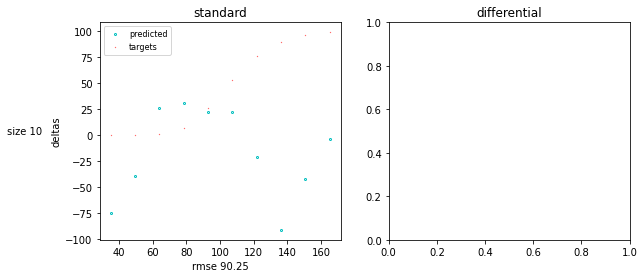

In [27]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = tf_Siren, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1,
                          "outermost_linear" : True},
          normalize = True
)

## **1.4) Differential ML**

### **Siren = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 10



standard_yloss : 0.0012514816
standard_dyloss : 0.1310312
differential_yloss : 0.0006385193
differential_dyloss : 0.0070949756
[[0.0012514816], [0.1310312], [0.0006385193], [0.0070949756]]


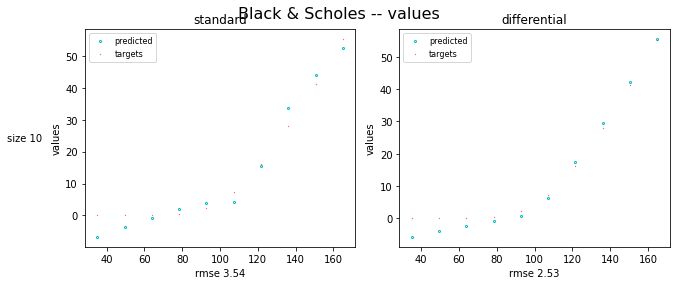

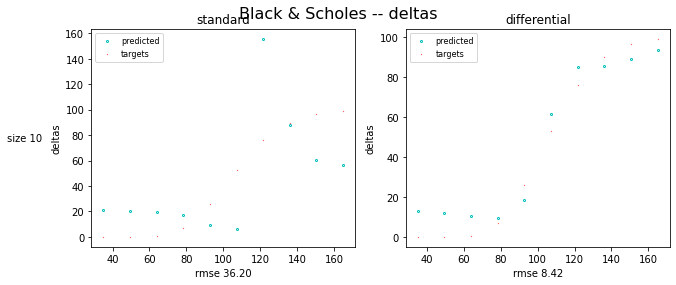

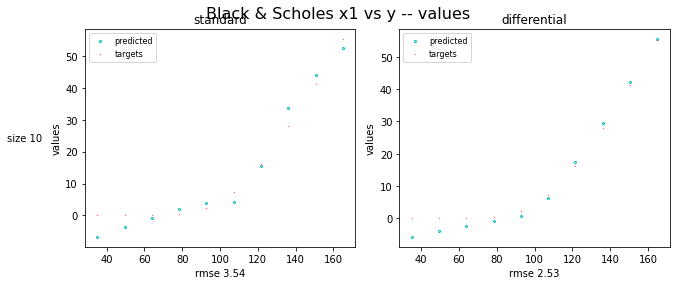

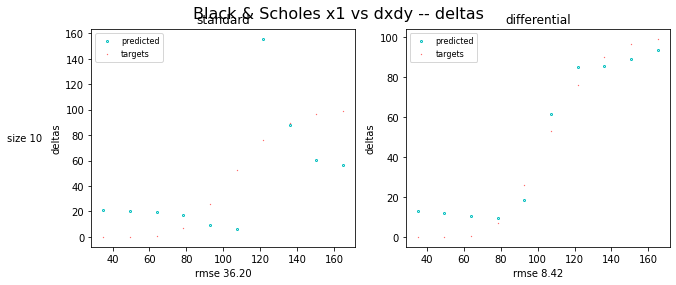

In [28]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN},
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM
              )

### **siren = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 10



standard_yloss : 12.528988
standard_dyloss : 2923197200000000.0
differential_yloss : nan
differential_dyloss : nan
[[12.528988], [2923197200000000.0], [nan], [nan]]


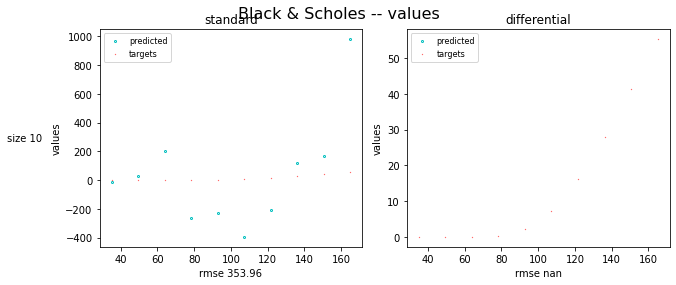

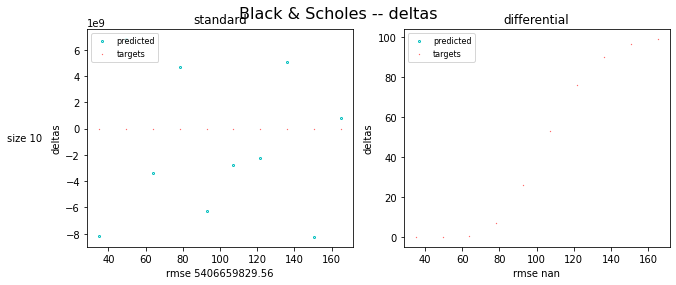

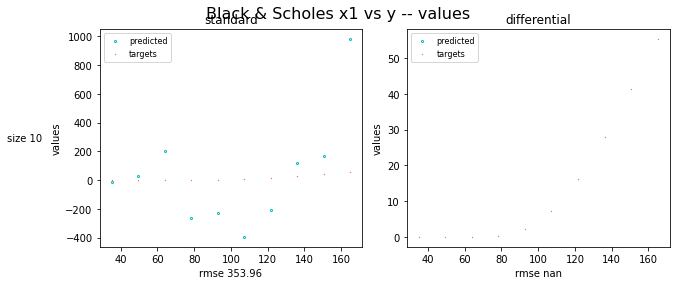

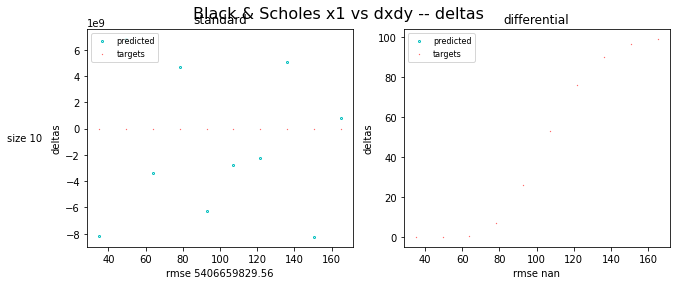

In [29]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN},
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM,
              siren = True
              )

## **1.5) twin_net with siren**

In [30]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, "outermost_linear" : outermost_linear, "first_omega_0" : first_omega_0 , 
                "hidden_omega_0" : hidden_omega_0}

### ***1.5.1) not_with_derivative***

In [31]:
with_derivative = False

**normalize = False**

Epoch 0: train loss: 0.12795518338680267 train loss no scaled: 0.12795518338680267
Epoch 1: train loss: 0.11567738652229309 train loss no scaled: 0.11567738652229309
Epoch 2: train loss: 0.11227552592754364 train loss no scaled: 0.11227552592754364
Epoch 3: train loss: 0.10872238874435425 train loss no scaled: 0.10872238874435425
Epoch 4: train loss: 0.10069642961025238 train loss no scaled: 0.10069642961025238
Epoch 5: train loss: 0.0949711874127388 train loss no scaled: 0.0949711874127388
Epoch 6: train loss: 0.08835472911596298 train loss no scaled: 0.08835472911596298
Epoch 7: train loss: 0.08380546420812607 train loss no scaled: 0.08380546420812607
Epoch 8: train loss: 0.08267762511968613 train loss no scaled: 0.08267762511968613
Epoch 9: train loss: 0.0800134688615799 train loss no scaled: 0.0800134688615799
Epoch 10: train loss: 0.0772615447640419 train loss no scaled: 0.0772615447640419
Epoch 11: train loss: 0.07349833846092224 train loss no scaled: 0.07349833846092224
Epoch 12

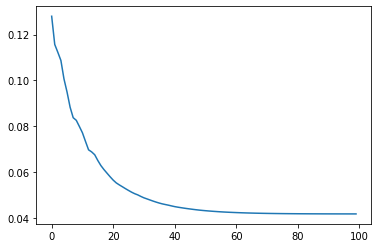

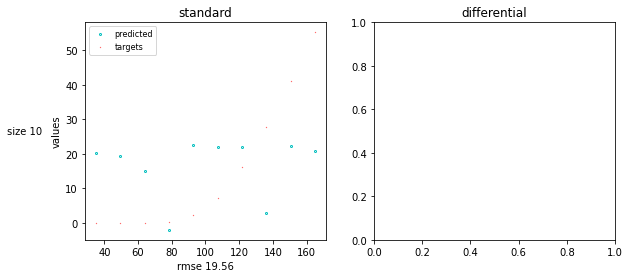

In [32]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, 
                                  model_class = Siren, model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = False)

**normalize = True**

Epoch 0: train loss: 1.0079679489135742 train loss no scaled: 0.0422552265226841
Epoch 1: train loss: 1.004915475845337 train loss no scaled: 0.042127255350351334
Epoch 2: train loss: 1.0032107830047607 train loss no scaled: 0.04205579683184624
Epoch 3: train loss: 1.0019428730010986 train loss no scaled: 0.042002640664577484
Epoch 4: train loss: 1.0017786026000977 train loss no scaled: 0.04199574887752533
Epoch 5: train loss: 1.0015238523483276 train loss no scaled: 0.04198508337140083
Epoch 6: train loss: 1.001122236251831 train loss no scaled: 0.041968248784542084
Epoch 7: train loss: 1.0005935430526733 train loss no scaled: 0.041946087032556534
Epoch 8: train loss: 1.0004830360412598 train loss no scaled: 0.04194145277142525
Epoch 9: train loss: 1.000328779220581 train loss no scaled: 0.04193498194217682
Epoch 10: train loss: 1.0001670122146606 train loss no scaled: 0.04192819446325302
Epoch 11: train loss: 1.0001262426376343 train loss no scaled: 0.04192649945616722
Epoch 12: trai

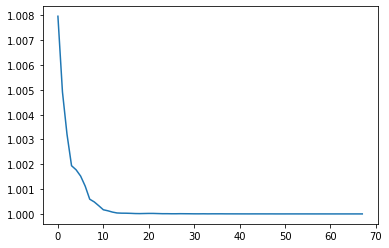

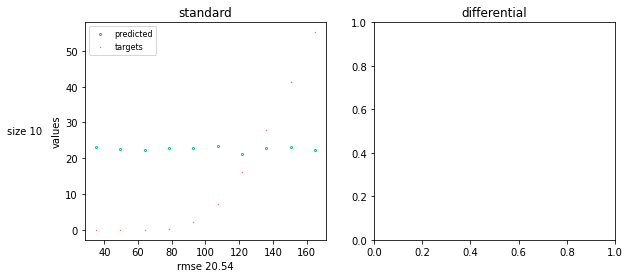

In [33]:
with_derivative = False
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, 
                                  model_class = Siren, model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = True)

###***1.5.2) with_derivative***

In [34]:
with_derivative = True 

**normalize = True**

Epoch 0: train loss: 0.4178004264831543, y loss : 0.07524361461400986, dy loss : 0.34255680441856384
train loss no scaled: 0.4178004190325737, y loss  no scaled : 0.07524361461400986, dy loss  no scaled: 0.34255680441856384
Epoch 1: train loss: 0.9231212139129639, y loss : 0.07234534621238708, dy loss : 0.8507758975028992
train loss no scaled: 0.9231212437152863, y loss  no scaled : 0.07234534621238708, dy loss  no scaled: 0.8507758975028992
Epoch 2: train loss: 0.8853729367256165, y loss : 0.06985361874103546, dy loss : 0.8155193328857422
train loss no scaled: 0.8853729516267776, y loss  no scaled : 0.06985361874103546, dy loss  no scaled: 0.8155193328857422
Epoch 3: train loss: 1.0040208101272583, y loss : 0.06812037527561188, dy loss : 0.9359003901481628
train loss no scaled: 1.0040207654237747, y loss  no scaled : 0.06812037527561188, dy loss  no scaled: 0.9359003901481628
Epoch 4: train loss: 0.9992212057113647, y loss : 0.06528238952159882, dy loss : 0.9339388012886047
train loss

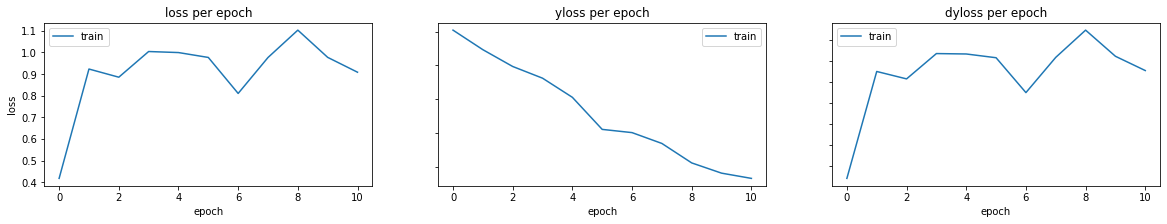

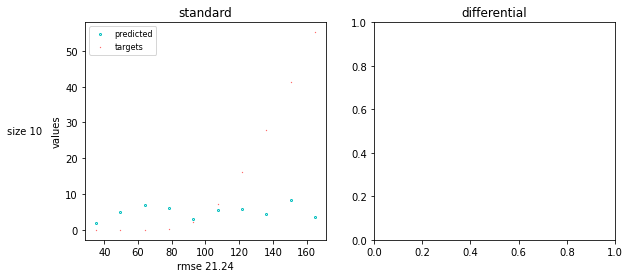

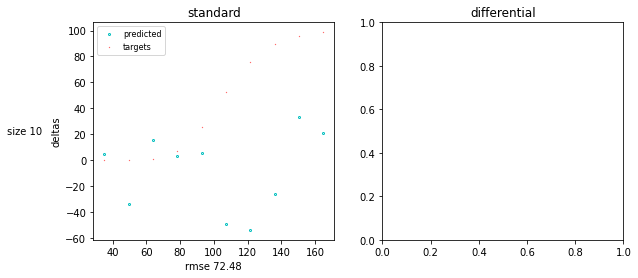

In [35]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = Siren, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = False)

**normalize = True**

Epoch 0: train loss: 1.3078721761703491, y loss : 0.04914270341396332, dy loss : 1.2587294578552246
train loss no scaled: 1.307872161269188, y loss  no scaled : 0.04914270341396332, dy loss  no scaled: 1.2587294578552246
Epoch 1: train loss: 0.75995934009552, y loss : 0.04629433527588844, dy loss : 0.7136650085449219
train loss no scaled: 0.7599593438208103, y loss  no scaled : 0.04629433527588844, dy loss  no scaled: 0.7136650085449219
Epoch 2: train loss: 0.5987582802772522, y loss : 0.04637811705470085, dy loss : 0.5523801445960999
train loss no scaled: 0.5987582616508007, y loss  no scaled : 0.04637811705470085, dy loss  no scaled: 0.5523801445960999
Epoch 3: train loss: 0.7055270671844482, y loss : 0.044504255056381226, dy loss : 0.6610227823257446
train loss no scaled: 0.7055270373821259, y loss  no scaled : 0.044504255056381226, dy loss  no scaled: 0.6610227823257446
Epoch 4: train loss: 0.6760143637657166, y loss : 0.04420299455523491, dy loss : 0.6318113803863525
train loss no

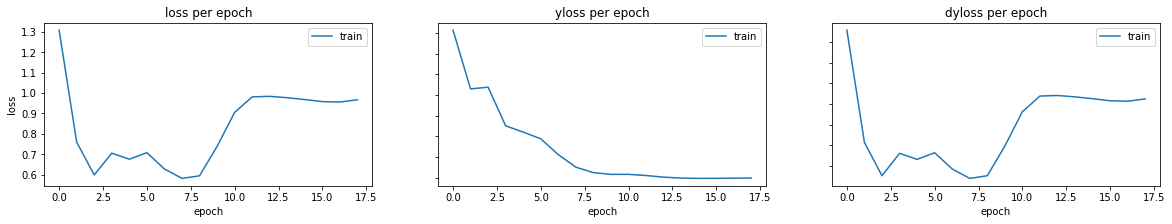

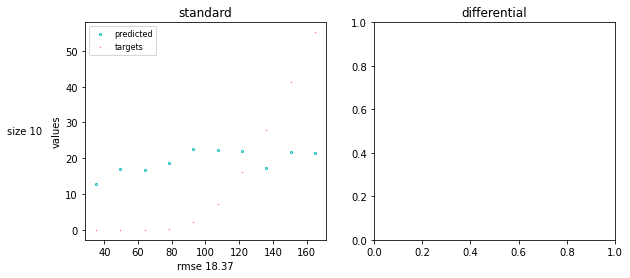

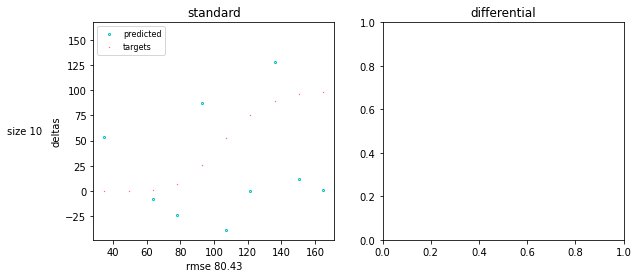

In [36]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = Siren, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = False)

## **1.6) twin_net with MLP**



In [37]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, 
                "activation_function" : F.softplus, # This is what was done in the original code.
                "deriv_activation_function" : F.sigmoid,
                #"activation_function" : None, # This is what was done in the original code.
                #"deriv_activation_function" : None
                }
              

###***1.6.1) not_with_derivative***

In [38]:
with_derivative = False

**normalize = False**

Epoch 0: train loss: 0.13927516341209412 train loss no scaled: 0.13927516341209412
Epoch 1: train loss: 0.13822172582149506 train loss no scaled: 0.13822172582149506
Epoch 2: train loss: 0.1371757686138153 train loss no scaled: 0.1371757686138153
Epoch 3: train loss: 0.13613733649253845 train loss no scaled: 0.13613733649253845
Epoch 4: train loss: 0.13510654866695404 train loss no scaled: 0.13510654866695404
Epoch 5: train loss: 0.13408349454402924 train loss no scaled: 0.13408349454402924
Epoch 6: train loss: 0.1330682337284088 train loss no scaled: 0.1330682337284088
Epoch 7: train loss: 0.13206082582473755 train loss no scaled: 0.13206082582473755
Epoch 8: train loss: 0.1310614049434662 train loss no scaled: 0.1310614049434662
Epoch 9: train loss: 0.13006995618343353 train loss no scaled: 0.13006995618343353
Epoch 10: train loss: 0.12908661365509033 train loss no scaled: 0.12908661365509033
Epoch 11: train loss: 0.12811137735843658 train loss no scaled: 0.12811137735843658
Epoch 12

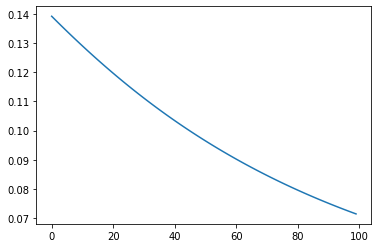

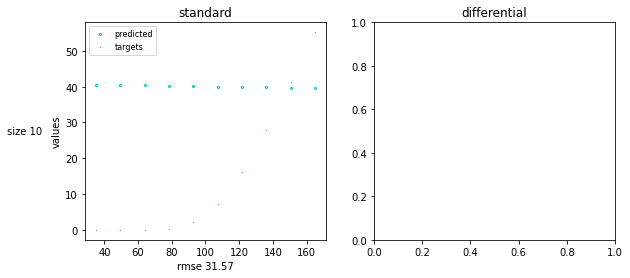

In [39]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = False)

**normalize = True**

Epoch 0: train loss: 1.5633643865585327 train loss no scaled: 0.06553810834884644
Epoch 1: train loss: 1.559816598892212 train loss no scaled: 0.06538940221071243
Epoch 2: train loss: 1.5562865734100342 train loss no scaled: 0.06524140387773514
Epoch 3: train loss: 1.55277419090271 train loss no scaled: 0.06509416550397873
Epoch 4: train loss: 1.549279808998108 train loss no scaled: 0.06494767218828201
Epoch 5: train loss: 1.5458036661148071 train loss no scaled: 0.06480194628238678
Epoch 6: train loss: 1.542345404624939 train loss no scaled: 0.06465698033571243
Epoch 7: train loss: 1.5389059782028198 train loss no scaled: 0.06451278924942017
Epoch 8: train loss: 1.535485029220581 train loss no scaled: 0.06436938047409058
Epoch 9: train loss: 1.5320831537246704 train loss no scaled: 0.06422676891088486
Epoch 10: train loss: 1.5287001132965088 train loss no scaled: 0.06408494710922241
Epoch 11: train loss: 1.5253362655639648 train loss no scaled: 0.06394393742084503
Epoch 12: train loss

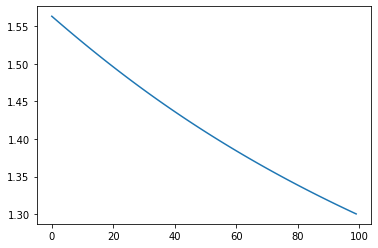

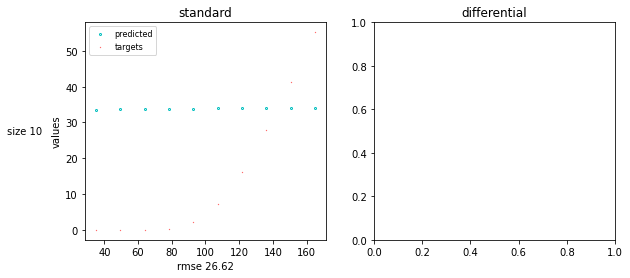

In [40]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = True)

###***1.6.2) with_derivative***

In [41]:
with_derivative = True

**normalize = False**

Epoch 0: train loss: 0.9093824625015259, y loss : 0.25972869992256165, dy loss : 0.6496537327766418
train loss no scaled: 0.9093824326992035, y loss  no scaled : 0.25972869992256165, dy loss  no scaled: 0.6496537327766418
Epoch 1: train loss: 0.9077571630477905, y loss : 0.25809675455093384, dy loss : 0.6496604084968567
train loss no scaled: 0.9077571630477905, y loss  no scaled : 0.25809675455093384, dy loss  no scaled: 0.6496604084968567
Epoch 2: train loss: 0.9061413407325745, y loss : 0.2564741373062134, dy loss : 0.6496672034263611
train loss no scaled: 0.9061413407325745, y loss  no scaled : 0.2564741373062134, dy loss  no scaled: 0.6496672034263611
Epoch 3: train loss: 0.9045349359512329, y loss : 0.2548609972000122, dy loss : 0.6496739387512207
train loss no scaled: 0.9045349359512329, y loss  no scaled : 0.2548609972000122, dy loss  no scaled: 0.6496739387512207
Epoch 4: train loss: 0.9029379487037659, y loss : 0.2532573938369751, dy loss : 0.6496805548667908
train loss no sca

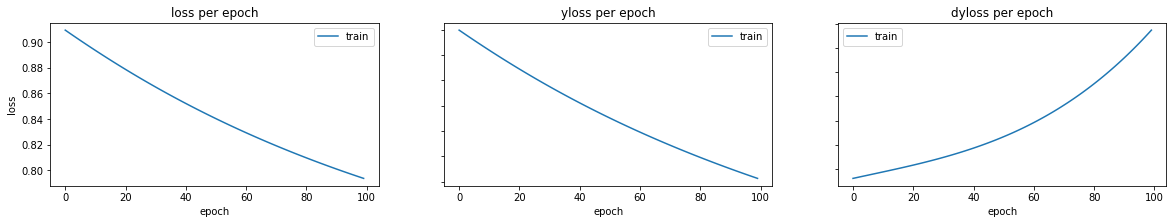

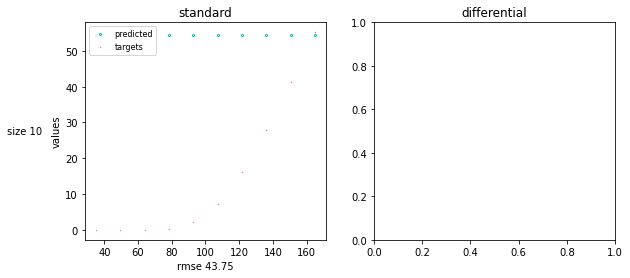

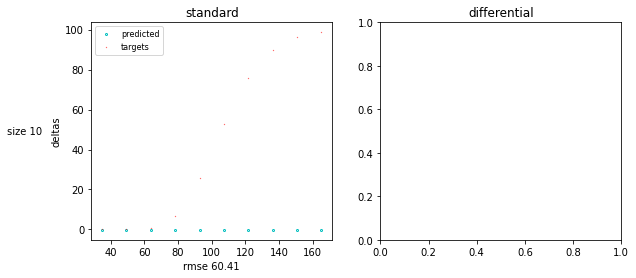

In [42]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = False)

**normalize = True**

Epoch 0: train loss: 1.3879301621320386, y loss : 1.7750908136367798, dy loss : 1.0007695106272974
train loss no scaled: 0.7230374664068222, y loss  no scaled : 0.07441394031047821, dy loss  no scaled: 0.648623526096344
Epoch 1: train loss: 1.3862234638618631, y loss : 1.7716580629348755, dy loss : 1.0007888647888508
train loss no scaled: 0.7229060679674149, y loss  no scaled : 0.07427002489566803, dy loss  no scaled: 0.6486360430717468
Epoch 2: train loss: 1.3845234534200093, y loss : 1.7682387828826904, dy loss : 1.0008081239573283
train loss no scaled: 0.7227752581238747, y loss  no scaled : 0.074126698076725, dy loss  no scaled: 0.6486485600471497
Epoch 3: train loss: 1.3828304258652044, y loss : 1.7648335695266724, dy loss : 1.0008272822037365
train loss no scaled: 0.7226449549198151, y loss  no scaled : 0.07398393750190735, dy loss  no scaled: 0.6486610174179077
Epoch 4: train loss: 1.3811444425778787, y loss : 1.7614425420761108, dy loss : 1.0008463430796466
train loss no scaled

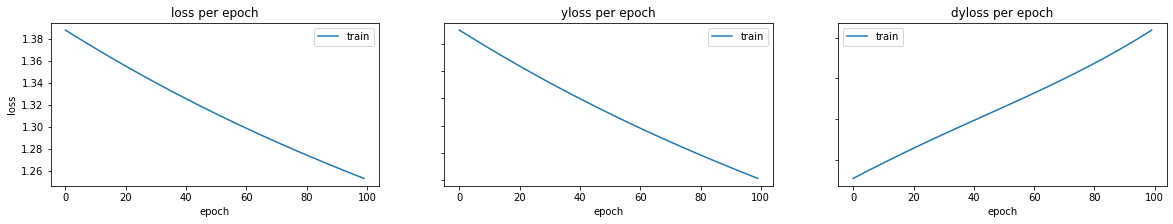

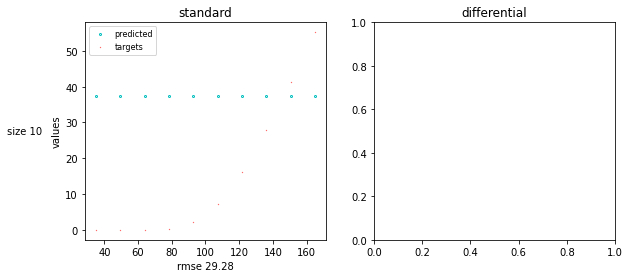

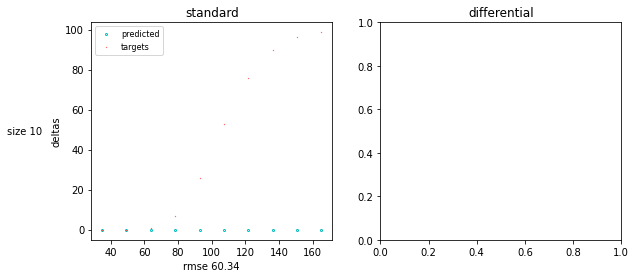

In [43]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = True)

# **2) Gaussian basket options**

## **2.1) Bachelier dimension 1**

In [44]:
INPUT_DIM = 1
generator = Bachelier(n = INPUT_DIM)
graph_name = "Bachelier dimension %d" % INPUT_DIM

### **2.1.1) Normal Training**

**normalize = True**

Epoch 0: train loss: 0.04089120402932167 train loss no scaled: 0.04089120402932167
Epoch 1: train loss: 0.040643736720085144 train loss no scaled: 0.040643736720085144
Epoch 2: train loss: 0.04039771854877472 train loss no scaled: 0.04039771854877472
Epoch 3: train loss: 0.040153227746486664 train loss no scaled: 0.040153227746486664
Epoch 4: train loss: 0.03991027921438217 train loss no scaled: 0.03991027921438217
Epoch 5: train loss: 0.039668887853622437 train loss no scaled: 0.039668887853622437
Epoch 6: train loss: 0.03942907229065895 train loss no scaled: 0.03942907229065895
Epoch 7: train loss: 0.03919084370136261 train loss no scaled: 0.03919084370136261
Epoch 8: train loss: 0.0389542281627655 train loss no scaled: 0.0389542281627655
Epoch 9: train loss: 0.038719214498996735 train loss no scaled: 0.038719214498996735
Epoch 10: train loss: 0.038485828787088394 train loss no scaled: 0.038485828787088394
Epoch 11: train loss: 0.03825399652123451 train loss no scaled: 0.038253996521

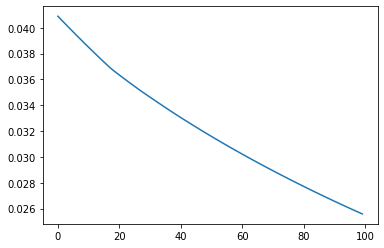

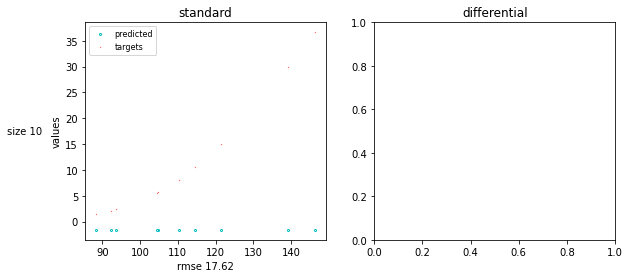

In [45]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = False, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = False
)

**normalize = True**

Epoch 0: train loss: 1.0218240022659302 train loss no scaled: 0.009736262261867523
Epoch 1: train loss: 1.0216468572616577 train loss no scaled: 0.00973457284271717
Epoch 2: train loss: 1.021470308303833 train loss no scaled: 0.009732890874147415
Epoch 3: train loss: 1.0212948322296143 train loss no scaled: 0.009731217287480831
Epoch 4: train loss: 1.0211199522018433 train loss no scaled: 0.009729552082717419
Epoch 5: train loss: 1.0209466218948364 train loss no scaled: 0.009727902710437775
Epoch 6: train loss: 1.020774483680725 train loss no scaled: 0.009726259857416153
Epoch 7: train loss: 1.020603060722351 train loss no scaled: 0.009724628180265427
Epoch 8: train loss: 1.020432472229004 train loss no scaled: 0.009723003953695297
Epoch 9: train loss: 1.0202628374099731 train loss no scaled: 0.009721385315060616
Epoch 10: train loss: 1.0200952291488647 train loss no scaled: 0.009719789028167725
Epoch 11: train loss: 1.0199284553527832 train loss no scaled: 0.00971820019185543
Epoch 12

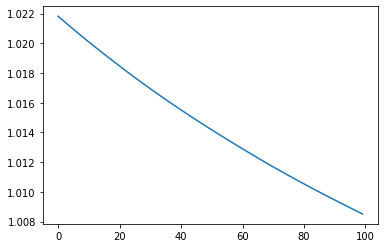

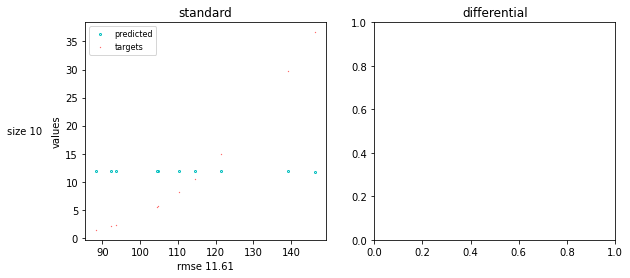

In [46]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = False, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = True
)

### **2.1.2) Sobolev Training**

Epoch 0: train loss: 0.34917977452278137, y loss : 0.027298415079712868, dy loss : 0.32188135385513306
train loss no scaled: 0.3491797689348459, y loss  no scaled : 0.027298415079712868, dy loss  no scaled: 0.32188135385513306
Epoch 1: train loss: 0.3489826023578644, y loss : 0.027141263708472252, dy loss : 0.3218413293361664
train loss no scaled: 0.34898259304463863, y loss  no scaled : 0.027141263708472252, dy loss  no scaled: 0.3218413293361664
Epoch 2: train loss: 0.34874579310417175, y loss : 0.026985077187418938, dy loss : 0.32176071405410767
train loss no scaled: 0.3487457912415266, y loss  no scaled : 0.026985077187418938, dy loss  no scaled: 0.32176071405410767
Epoch 3: train loss: 0.3485456109046936, y loss : 0.026830188930034637, dy loss : 0.32171541452407837
train loss no scaled: 0.348545603454113, y loss  no scaled : 0.026830188930034637, dy loss  no scaled: 0.32171541452407837
Epoch 4: train loss: 0.3483128845691681, y loss : 0.026676826179027557, dy loss : 0.321636050939

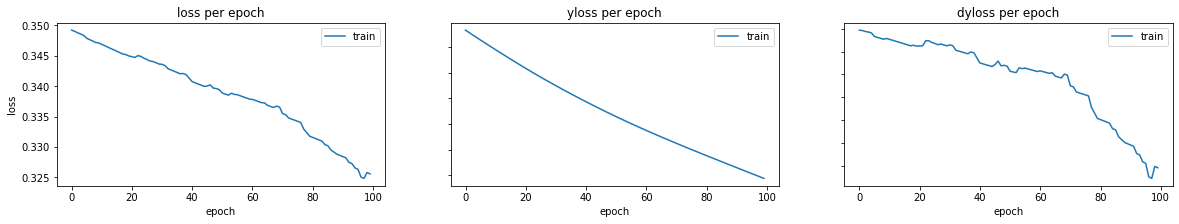

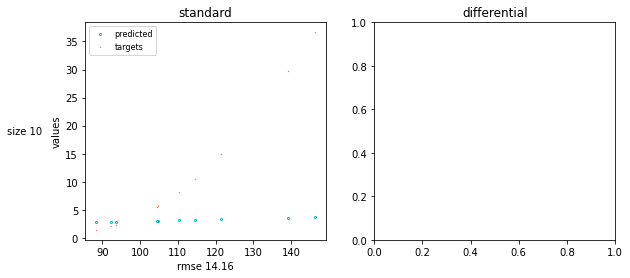

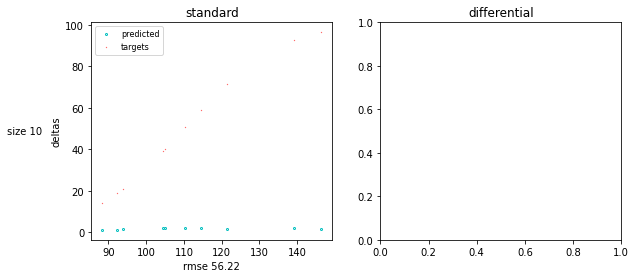

In [47]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = False
)

Epoch 0: train loss: 1.0003317238381981, y loss : 1.0001634359359741, dy loss : 1.0005000117404221
train loss no scaled: 0.33469237200915813, y loss  no scaled : 0.009529871866106987, dy loss  no scaled: 0.32516250014305115
Epoch 1: train loss: 1.00032796880333, y loss : 1.0001469850540161, dy loss : 1.0005089525526436
train loss no scaled: 0.3346951650455594, y loss  no scaled : 0.009529714472591877, dy loss  no scaled: 0.32516545057296753
Epoch 2: train loss: 1.0003455659744842, y loss : 1.000131368637085, dy loss : 1.0005597633118835
train loss no scaled: 0.3347115274518728, y loss  no scaled : 0.009529566392302513, dy loss  no scaled: 0.3251819610595703
Epoch 3: train loss: 1.0003677802208868, y loss : 1.0001167058944702, dy loss : 1.0006188545473031
train loss no scaled: 0.3347305813804269, y loss  no scaled : 0.009529427625238895, dy loss  no scaled: 0.325201153755188
Epoch 4: train loss: 1.0003861559734095, y loss : 1.0001031160354614, dy loss : 1.0006691959113578
train loss no 

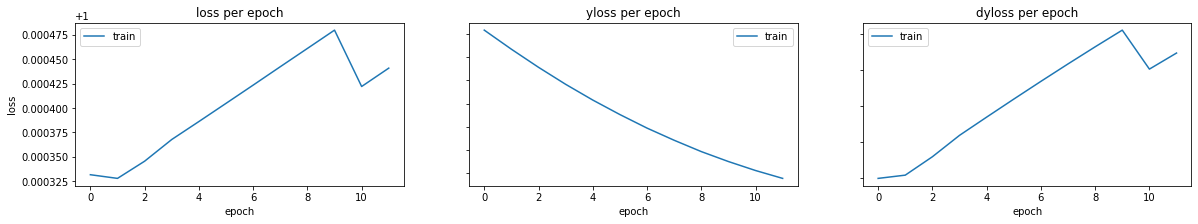

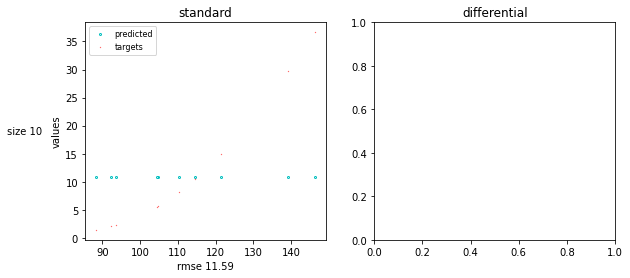

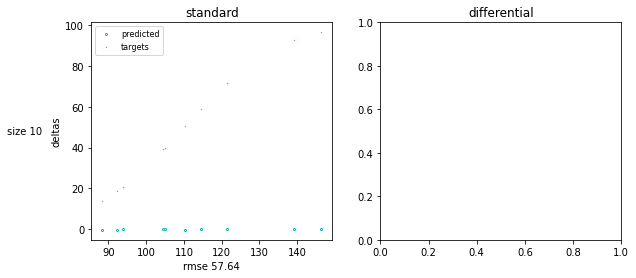

In [48]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = True
)

### **2.1.3) SIREN**

Epoch 0: train loss: 0.42494481801986694, y loss : 0.011825178749859333, dy loss : 0.4131196439266205
train loss no scaled: 0.4249448226764798, y loss  no scaled : 0.011825178749859333, dy loss  no scaled: 0.4131196439266205
Epoch 1: train loss: 0.39839404821395874, y loss : 0.010952893644571304, dy loss : 0.38744115829467773
train loss no scaled: 0.39839405193924904, y loss  no scaled : 0.010952893644571304, dy loss  no scaled: 0.38744115829467773
Epoch 2: train loss: 0.37457701563835144, y loss : 0.010353785008192062, dy loss : 0.3642232418060303
train loss no scaled: 0.37457702681422234, y loss  no scaled : 0.010353785008192062, dy loss  no scaled: 0.3642232418060303
Epoch 3: train loss: 0.35636842250823975, y loss : 0.009977143257856369, dy loss : 0.3463912904262543
train loss no scaled: 0.35636843368411064, y loss  no scaled : 0.009977143257856369, dy loss  no scaled: 0.3463912904262543
Epoch 4: train loss: 0.3438306152820587, y loss : 0.009761975146830082, dy loss : 0.33406862616

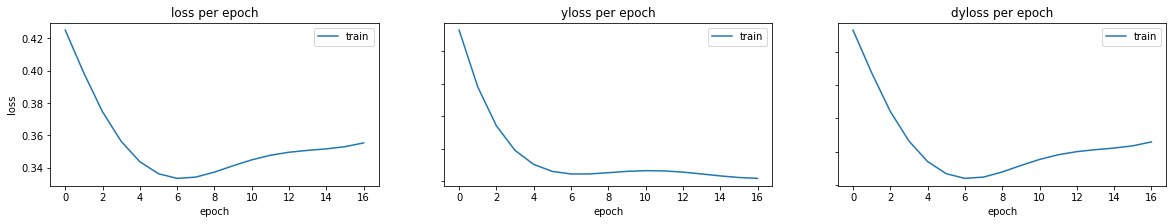

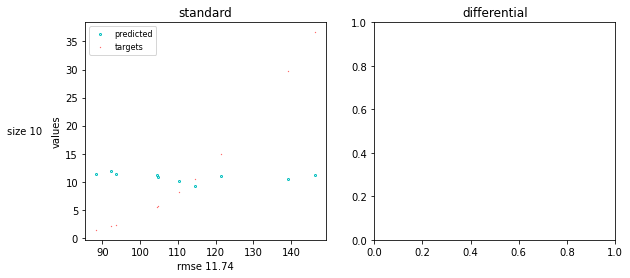

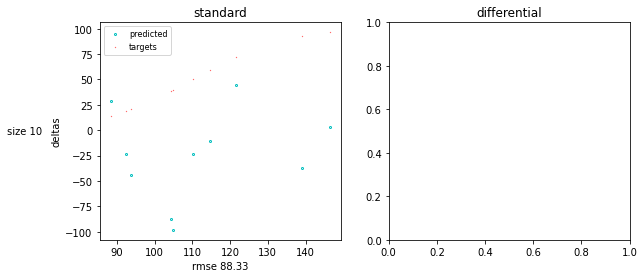

In [49]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = tf_Siren, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1,
                          "outermost_linear" : True},
          normalize = False
)

Epoch 0: train loss: 1.5162525845243784, y loss : 1.0004116296768188, dy loss : 2.032093539371938
train loss no scaled: 0.6699626678600907, y loss  no scaled : 0.009532236494123936, dy loss  no scaled: 0.6604304313659668
Epoch 1: train loss: 1.435421117974929, y loss : 1.0001829862594604, dy loss : 1.8706592496903975
train loss no scaled: 0.6174943968653679, y loss  no scaled : 0.00953005999326706, dy loss  no scaled: 0.6079643368721008
Epoch 2: train loss: 1.3610337399535504, y loss : 1.000083565711975, dy loss : 1.7219839141951254
train loss no scaled: 0.5691739302128553, y loss  no scaled : 0.0095291119068861, dy loss  no scaled: 0.5596448183059692
Epoch 3: train loss: 1.3058060846509858, y loss : 1.0000418424606323, dy loss : 1.611570326841339
train loss no scaled: 0.533289092592895, y loss  no scaled : 0.00952871423214674, dy loss  no scaled: 0.5237603783607483
Epoch 4: train loss: 1.268404401542867, y loss : 1.0000262260437012, dy loss : 1.536782577042033
train loss no scaled: 0.

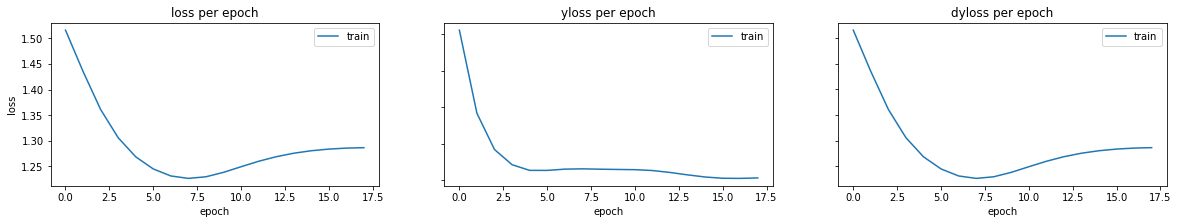

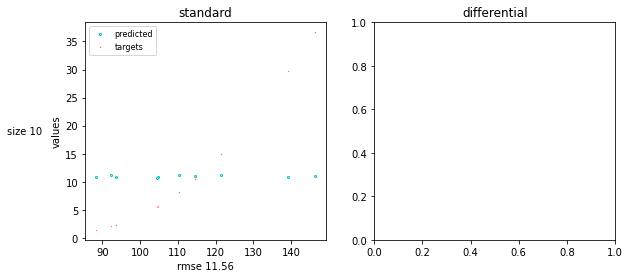

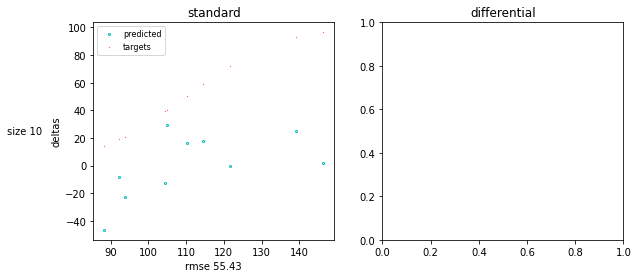

In [50]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = tf_Siren, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1,
                          "outermost_linear" : True},
          normalize = True
)

### **2.1.4) Differential ML**

### **siren = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 10



standard_yloss : 0.0014331985
standard_dyloss : 0.08847407
differential_yloss : 0.00017959939
differential_dyloss : 0.0041114753
[[0.0014331985], [0.08847407], [0.00017959939], [0.0041114753]]


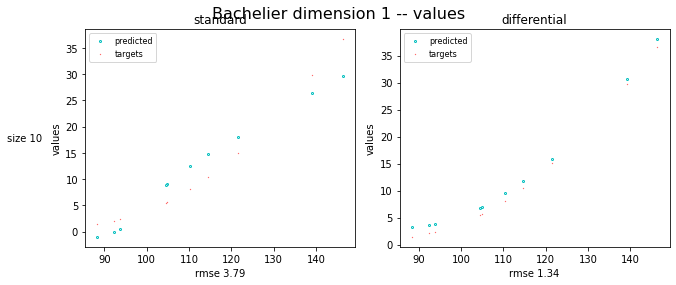

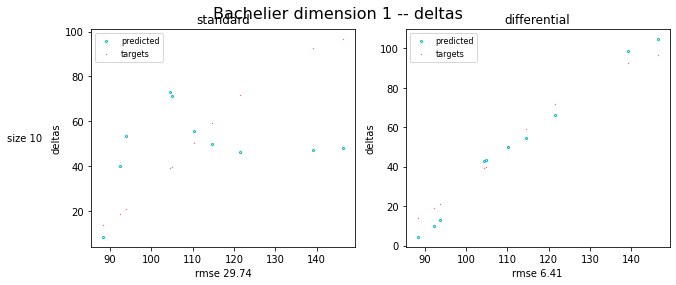

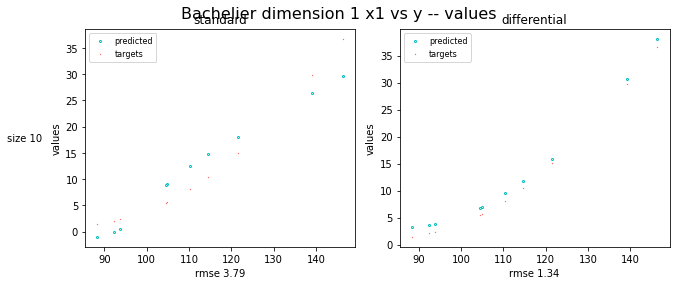

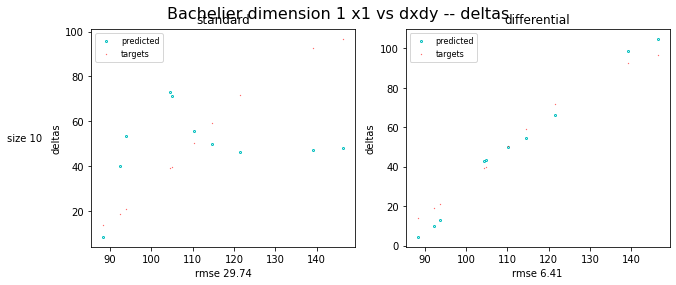

In [51]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN},
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM)

### **siren = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 10



standard_yloss : 2.5699391
standard_dyloss : 703767500000000.0
differential_yloss : nan
differential_dyloss : nan
[[2.5699391], [703767500000000.0], [nan], [nan]]


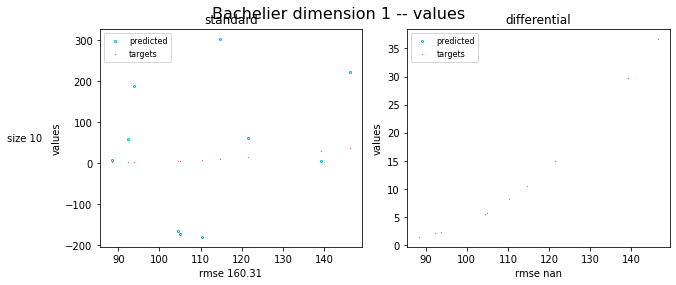

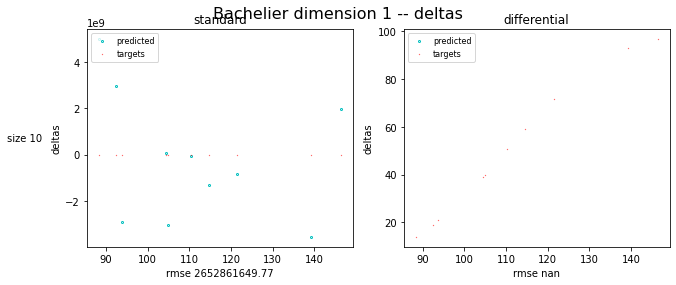

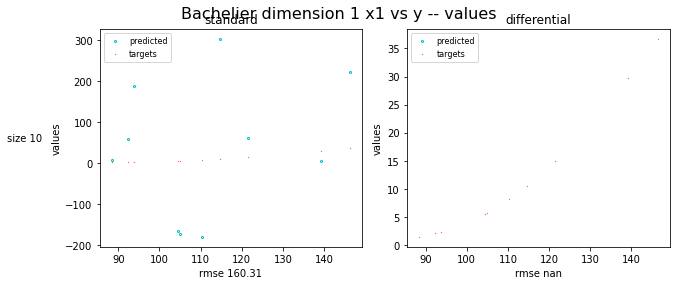

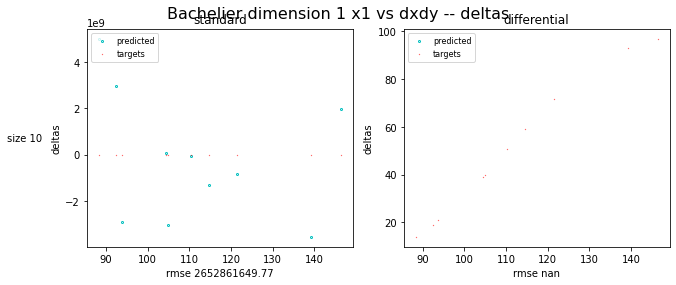

In [52]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN},
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM,
              siren = True
              )

### **2.1.5) twin_net with siren**

In [53]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, "outermost_linear" : outermost_linear, "first_omega_0" : first_omega_0, 
                "hidden_omega_0" : hidden_omega_0}
with_derivative = True   

Epoch 0: train loss: 0.3558025658130646, y loss : 0.009672674350440502, dy loss : 0.3461298942565918
train loss no scaled: 0.3558025686070323, y loss  no scaled : 0.009672674350440502, dy loss  no scaled: 0.3461298942565918
Epoch 1: train loss: 0.47872933745384216, y loss : 0.009797720238566399, dy loss : 0.4689316153526306
train loss no scaled: 0.478729335591197, y loss  no scaled : 0.009797720238566399, dy loss  no scaled: 0.4689316153526306
Epoch 2: train loss: 0.25901076197624207, y loss : 0.009633205831050873, dy loss : 0.2493775635957718
train loss no scaled: 0.25901076942682266, y loss  no scaled : 0.009633205831050873, dy loss  no scaled: 0.2493775635957718
Epoch 3: train loss: 0.4560524523258209, y loss : 0.00957639329135418, dy loss : 0.4464760720729828
train loss no scaled: 0.45605246536433697, y loss  no scaled : 0.00957639329135418, dy loss  no scaled: 0.4464760720729828
Epoch 4: train loss: 0.6949442625045776, y loss : 0.009597537107765675, dy loss : 0.6853467226028442
tr

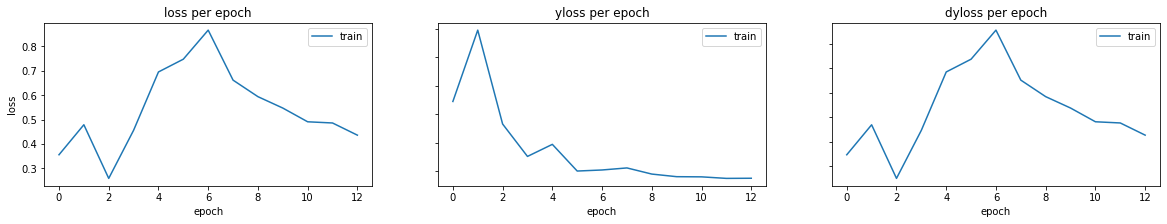

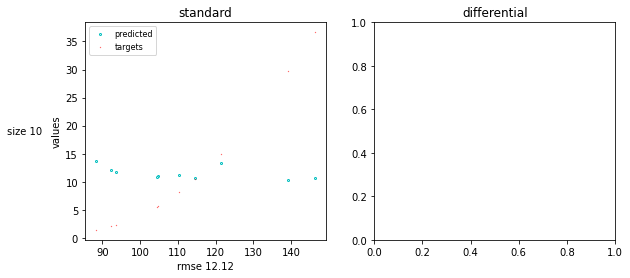

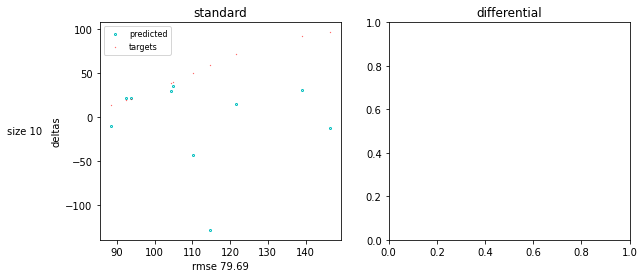

In [54]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = Siren, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = False)

Epoch 0: train loss: 1.2981134644119117, y loss : 1.0035614967346191, dy loss : 1.5926654320892042
train loss no scaled: 0.5271785818040371, y loss  no scaled : 0.009562250226736069, dy loss  no scaled: 0.517616331577301
Epoch 1: train loss: 1.355706574957877, y loss : 1.0026570558547974, dy loss : 1.7087560940609563
train loss no scaled: 0.5648994063958526, y loss  no scaled : 0.009553632698953152, dy loss  no scaled: 0.5553457736968994
Epoch 2: train loss: 0.9994634977645187, y loss : 1.0016212463378906, dy loss : 0.9973057491911467
train loss no scaled: 0.33366815838962793, y loss  no scaled : 0.009543762542307377, dy loss  no scaled: 0.32412439584732056
Epoch 3: train loss: 1.0367413968923755, y loss : 1.0010844469070435, dy loss : 1.0723983468777074
train loss no scaled: 0.35806816536933184, y loss  no scaled : 0.009538647718727589, dy loss  no scaled: 0.34852951765060425
Epoch 4: train loss: 1.0541651809295172, y loss : 1.000572919845581, dy loss : 1.1077574420134533
train loss n

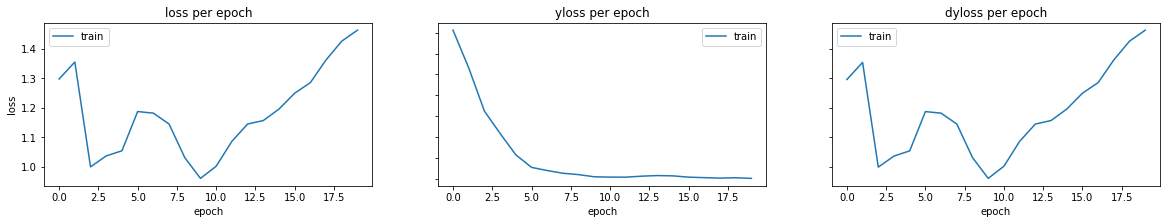

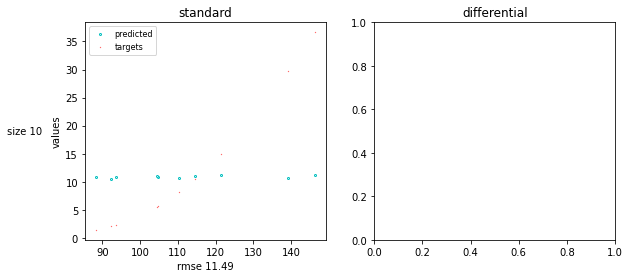

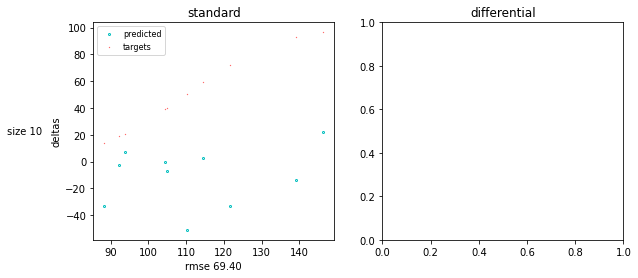

In [55]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = Siren, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = True)

### **2.1.6) twin_net with MLP**

In [56]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, 
                "activation_function" : F.softplus, # This is what was done in the original code.
                "deriv_activation_function" : F.sigmoid
                }
                
with_derivative = True

Epoch 0: train loss: 0.4832075834274292, y loss : 0.1580529659986496, dy loss : 0.3251546025276184
train loss no scaled: 0.483207568526268, y loss  no scaled : 0.1580529659986496, dy loss  no scaled: 0.3251546025276184
Epoch 1: train loss: 0.48205244541168213, y loss : 0.15688996016979218, dy loss : 0.32516247034072876
train loss no scaled: 0.48205243051052094, y loss  no scaled : 0.15688996016979218, dy loss  no scaled: 0.32516247034072876
Epoch 2: train loss: 0.48090383410453796, y loss : 0.15573343634605408, dy loss : 0.3251703977584839
train loss no scaled: 0.48090383410453796, y loss  no scaled : 0.15573343634605408, dy loss  no scaled: 0.3251703977584839
Epoch 3: train loss: 0.4797617793083191, y loss : 0.15458346903324127, dy loss : 0.325178325176239
train loss no scaled: 0.4797617942094803, y loss  no scaled : 0.15458346903324127, dy loss  no scaled: 0.325178325176239
Epoch 4: train loss: 0.47862645983695984, y loss : 0.1534401774406433, dy loss : 0.32518628239631653
train loss

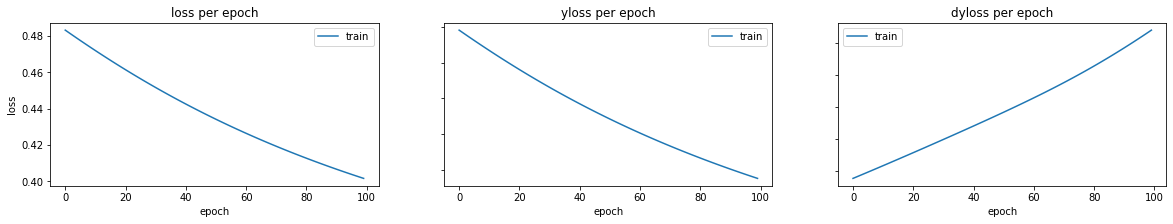

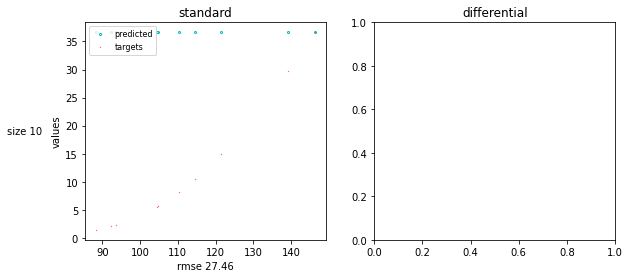

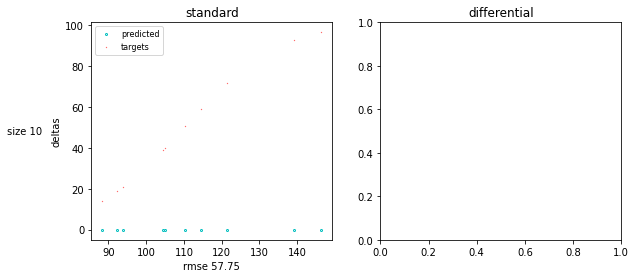

In [57]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = False)

Epoch 0: train loss: 1.3915219183498635, y loss : 1.7828547954559326, dy loss : 1.0001890412437944
train loss no scaled: 0.34204904548823833, y loss  no scaled : 0.016987605020403862, dy loss  no scaled: 0.3250614404678345
Epoch 1: train loss: 1.3895964803196792, y loss : 1.7790052890777588, dy loss : 1.0001876715615996
train loss no scaled: 0.3420119471848011, y loss  no scaled : 0.016950923949480057, dy loss  no scaled: 0.32506102323532104
Epoch 2: train loss: 1.3876798287027694, y loss : 1.775173306465149, dy loss : 1.0001863509403899
train loss no scaled: 0.3419750165194273, y loss  no scaled : 0.016914410516619682, dy loss  no scaled: 0.3250606060028076
Epoch 3: train loss: 1.3857717893332908, y loss : 1.7713584899902344, dy loss : 1.000185088676347
train loss no scaled: 0.34193824976682663, y loss  no scaled : 0.01687806099653244, dy loss  no scaled: 0.3250601887702942
Epoch 4: train loss: 1.3838728403015523, y loss : 1.7675617933273315, dy loss : 1.0001838872757731
train loss no

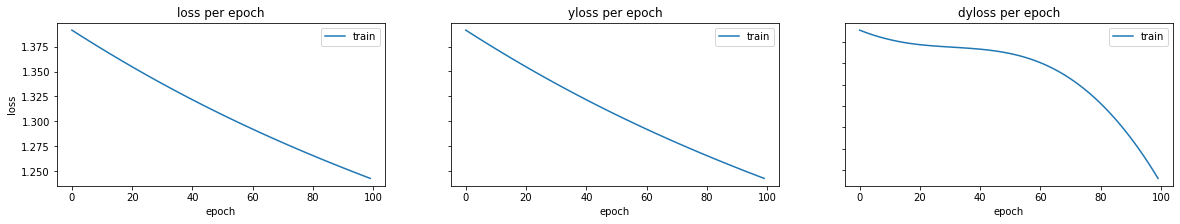

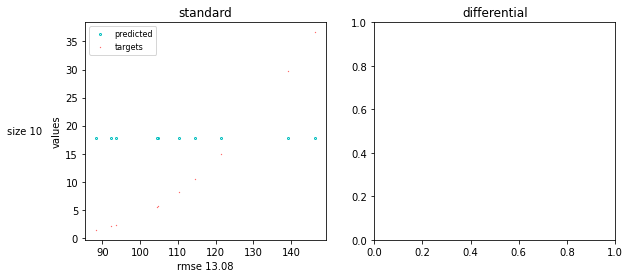

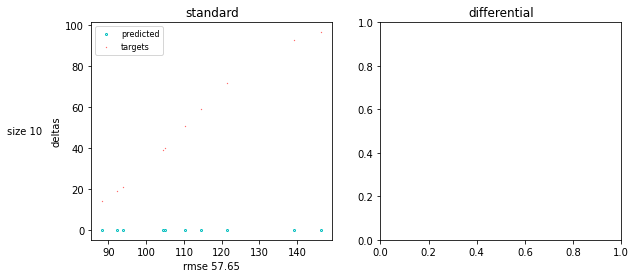

In [58]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = True)

## **2.2) Bachelier dimension 7**

In [59]:
INPUT_DIM = 7
generator = Bachelier(n = INPUT_DIM)
graph_name = "Bachelier dimension %d" % INPUT_DIM

### **2.2.1) Normal Training**

Epoch 0: train loss: 0.09154412150382996 train loss no scaled: 0.09154412150382996
Epoch 1: train loss: 0.09123089164495468 train loss no scaled: 0.09123089164495468
Epoch 2: train loss: 0.09091892838478088 train loss no scaled: 0.09091892838478088
Epoch 3: train loss: 0.09060754626989365 train loss no scaled: 0.09060754626989365
Epoch 4: train loss: 0.09029696136713028 train loss no scaled: 0.09029696136713028
Epoch 5: train loss: 0.08998718112707138 train loss no scaled: 0.08998718112707138
Epoch 6: train loss: 0.089678555727005 train loss no scaled: 0.089678555727005
Epoch 7: train loss: 0.08937153220176697 train loss no scaled: 0.08937153220176697
Epoch 8: train loss: 0.08906541019678116 train loss no scaled: 0.08906541019678116
Epoch 9: train loss: 0.08876065909862518 train loss no scaled: 0.08876065909862518
Epoch 10: train loss: 0.08845696598291397 train loss no scaled: 0.08845696598291397
Epoch 11: train loss: 0.08815421164035797 train loss no scaled: 0.08815421164035797
Epoch 

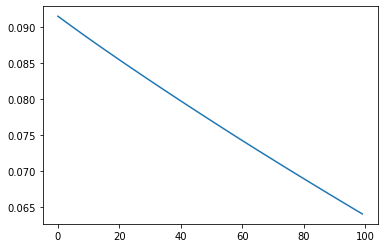

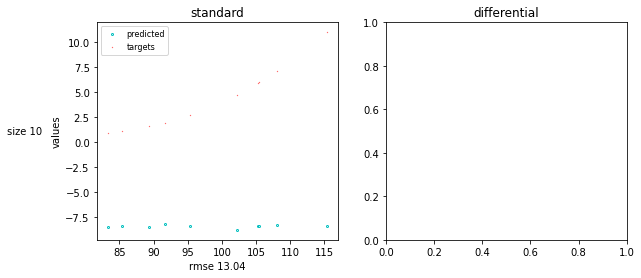

In [60]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = False, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = False
)

Epoch 0: train loss: 1.0266624689102173 train loss no scaled: 0.024876482784748077
Epoch 1: train loss: 1.0265406370162964 train loss no scaled: 0.024873539805412292
Epoch 2: train loss: 1.0264196395874023 train loss no scaled: 0.024870600551366806
Epoch 3: train loss: 1.0262986421585083 train loss no scaled: 0.024867672473192215
Epoch 4: train loss: 1.026178240776062 train loss no scaled: 0.02486475557088852
Epoch 5: train loss: 1.0260580778121948 train loss no scaled: 0.02486184611916542
Epoch 6: train loss: 1.0259385108947754 train loss no scaled: 0.024858945980668068
Epoch 7: train loss: 1.0258193016052246 train loss no scaled: 0.02485605701804161
Epoch 8: train loss: 1.025700330734253 train loss no scaled: 0.02485317550599575
Epoch 9: train loss: 1.0255818367004395 train loss no scaled: 0.024850303307175636
Epoch 10: train loss: 1.0254639387130737 train loss no scaled: 0.024847446009516716
Epoch 11: train loss: 1.025346279144287 train loss no scaled: 0.024844594299793243
Epoch 12:

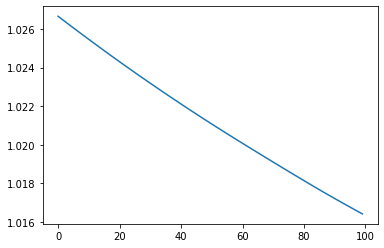

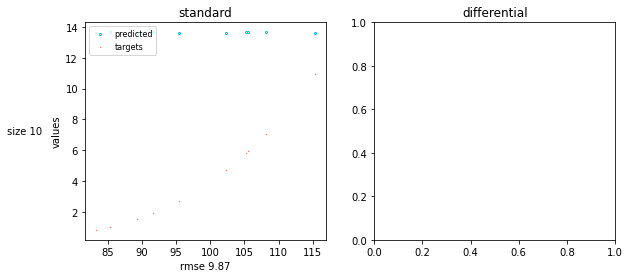

In [61]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = False, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = True
)

### **2.2.2) Sobolev Training**

Epoch 0: train loss: 0.13518869876861572, y loss : 0.1242576614022255, dy loss : 0.010931044816970825
train loss no scaled: 0.13518870621919632, y loss  no scaled : 0.1242576614022255, dy loss  no scaled: 0.010931044816970825
Epoch 1: train loss: 0.1347143054008484, y loss : 0.1237746924161911, dy loss : 0.010939618572592735
train loss no scaled: 0.13471431098878384, y loss  no scaled : 0.1237746924161911, dy loss  no scaled: 0.010939618572592735
Epoch 2: train loss: 0.13423991203308105, y loss : 0.12329904735088348, dy loss : 0.010940871201455593
train loss no scaled: 0.13423991855233908, y loss  no scaled : 0.12329904735088348, dy loss  no scaled: 0.010940871201455593
Epoch 3: train loss: 0.13376623392105103, y loss : 0.12282606214284897, dy loss : 0.01094017457216978
train loss no scaled: 0.13376623671501875, y loss  no scaled : 0.12282606214284897, dy loss  no scaled: 0.01094017457216978
Epoch 4: train loss: 0.1332942545413971, y loss : 0.12235478311777115, dy loss : 0.010939478874

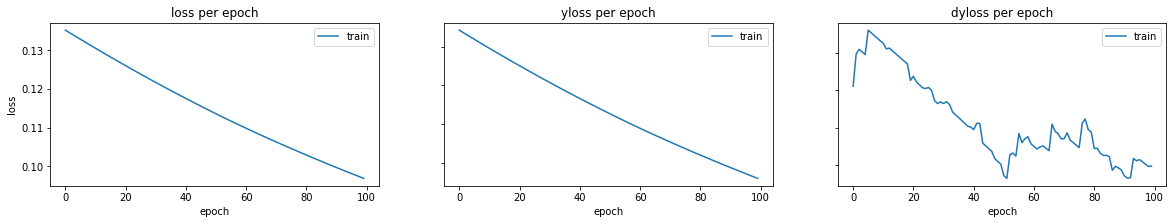

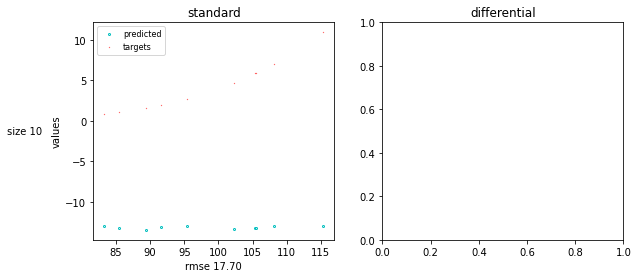

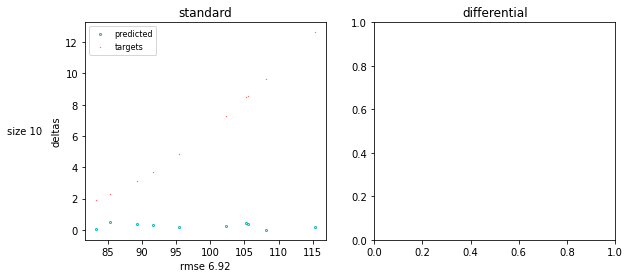

In [62]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = False
)

Epoch 0: train loss: 0.9933307133399024, y loss : 1.0389324426651, dy loss : 0.9868161805791599
train loss no scaled: 0.035789343528449535, y loss  no scaled : 0.025173792615532875, dy loss  no scaled: 0.01061555091291666
Epoch 1: train loss: 0.9931718861960516, y loss : 1.0386035442352295, dy loss : 0.9866816493333118
train loss no scaled: 0.03578120190650225, y loss  no scaled : 0.025165827944874763, dy loss  no scaled: 0.010615373961627483
Epoch 2: train loss: 0.9935623823763158, y loss : 1.0382765531539917, dy loss : 0.9871746436937907
train loss no scaled: 0.03577183559536934, y loss  no scaled : 0.025157902389764786, dy loss  no scaled: 0.010613933205604553
Epoch 3: train loss: 0.9934011101995095, y loss : 1.0379539728164673, dy loss : 0.9870364155399441
train loss no scaled: 0.03576384112238884, y loss  no scaled : 0.025150086730718613, dy loss  no scaled: 0.010613754391670227
Epoch 4: train loss: 0.9915285851890506, y loss : 1.0376354455947876, dy loss : 0.9849418908453739
trai

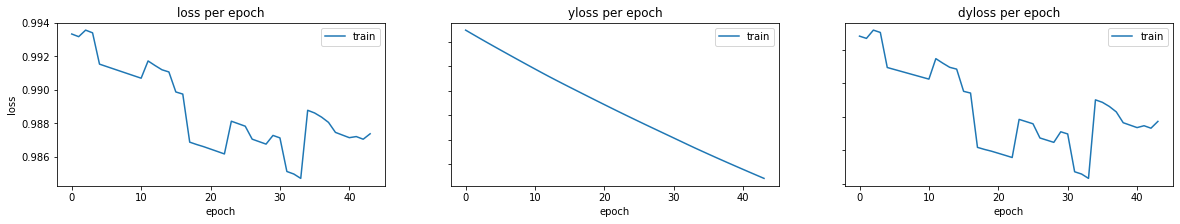

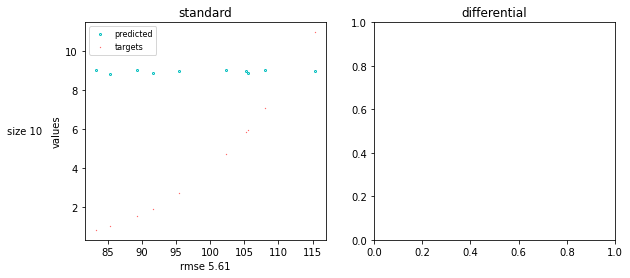

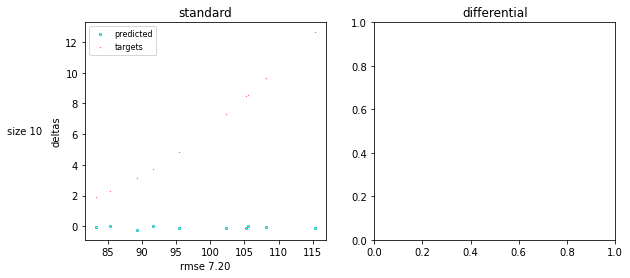

In [63]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = True
)

### **2.2.3) SIREN**

Epoch 0: train loss: 0.056074418127536774, y loss : 0.039150796830654144, dy loss : 0.01692362129688263
train loss no scaled: 0.056074418127536774, y loss  no scaled : 0.039150796830654144, dy loss  no scaled: 0.01692362129688263
Epoch 1: train loss: 0.05396922677755356, y loss : 0.03626716881990433, dy loss : 0.01770205795764923
train loss no scaled: 0.05396922677755356, y loss  no scaled : 0.03626716881990433, dy loss  no scaled: 0.01770205795764923
Epoch 2: train loss: 0.05169318616390228, y loss : 0.03367649018764496, dy loss : 0.018016697838902473
train loss no scaled: 0.05169318802654743, y loss  no scaled : 0.03367649018764496, dy loss  no scaled: 0.018016697838902473
Epoch 3: train loss: 0.04956087842583656, y loss : 0.03142083063721657, dy loss : 0.018140047788619995
train loss no scaled: 0.04956087842583656, y loss  no scaled : 0.03142083063721657, dy loss  no scaled: 0.018140047788619995
Epoch 4: train loss: 0.04787144809961319, y loss : 0.029507821425795555, dy loss : 0.018

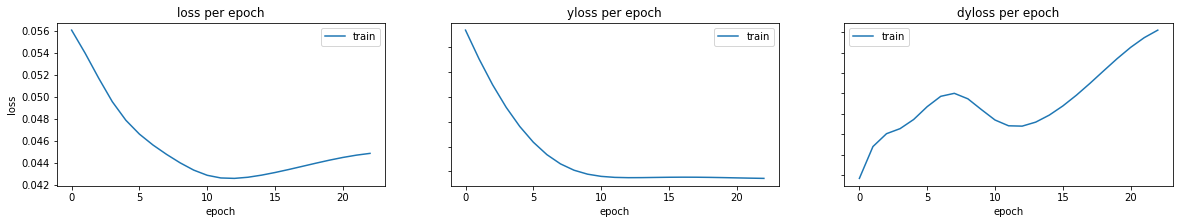

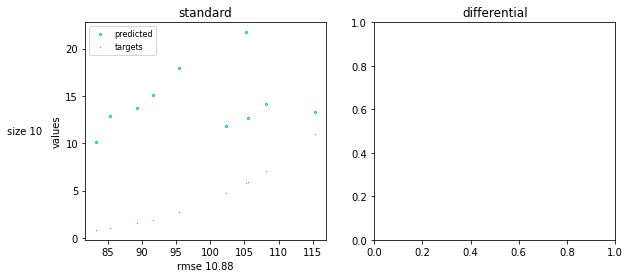

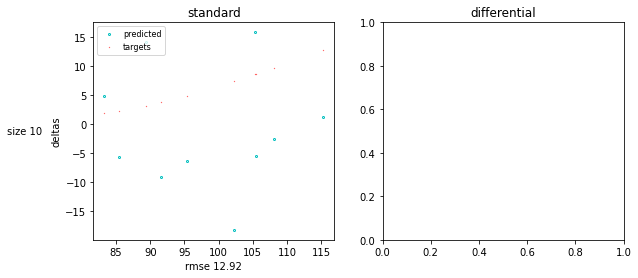

In [64]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = tf_Siren, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1,
                          "outermost_linear" : True},
          normalize = False
)

Epoch 0: train loss: 2.510740648640225, y loss : 1.0046327114105225, dy loss : 2.7258989253873254
train loss no scaled: 0.03655128926038742, y loss  no scaled : 0.024342693388462067, dy loss  no scaled: 0.012208595871925354
Epoch 1: train loss: 2.5442713580300467, y loss : 1.0034235715866089, dy loss : 2.764392470379109
train loss no scaled: 0.036450750194489956, y loss  no scaled : 0.02431339956820011, dy loss  no scaled: 0.012137350626289845
Epoch 2: train loss: 2.517683914518028, y loss : 1.0024209022521973, dy loss : 2.7341500591274324
train loss no scaled: 0.03631249628961086, y loss  no scaled : 0.02428910695016384, dy loss  no scaled: 0.012023389339447021
Epoch 3: train loss: 2.4188559482748864, y loss : 1.0016202926635742, dy loss : 2.621318184790788
train loss no scaled: 0.03616336453706026, y loss  no scaled : 0.024269700050354004, dy loss  no scaled: 0.011893664486706257
Epoch 4: train loss: 2.2592234569469003, y loss : 1.0010124444961548, dy loss : 2.438967887297007
train l

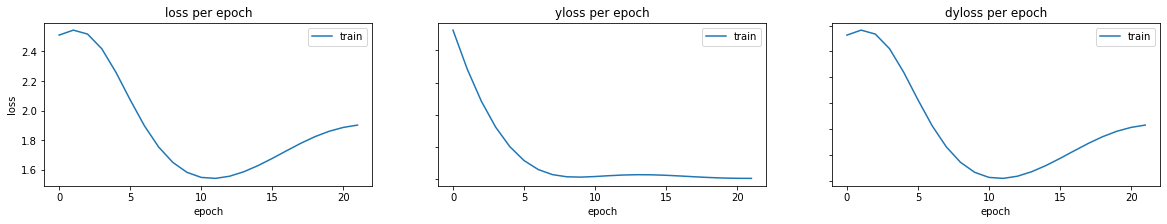

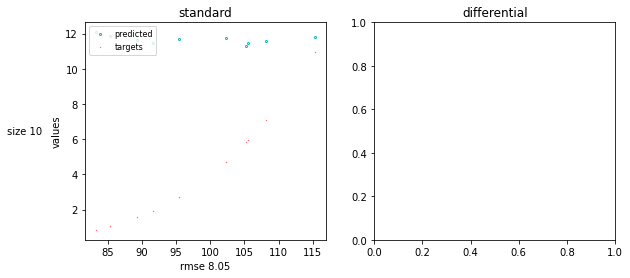

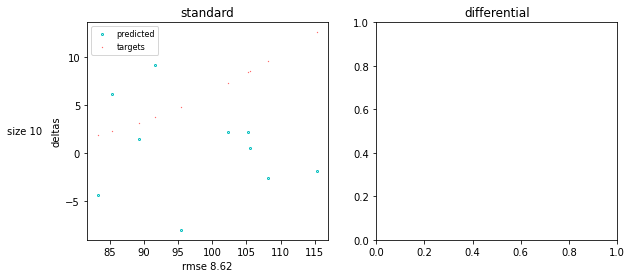

In [65]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = tf_Siren, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1,
                          "outermost_linear" : True},
          normalize = True
)

### **2.2.4) Differential ML**

**siren = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 10



standard_yloss : 0.0013890191
standard_dyloss : 0.004051532
differential_yloss : 0.000513198
differential_dyloss : 0.00023021086
[[0.0013890191], [0.004051532], [0.000513198], [0.00023021086]]


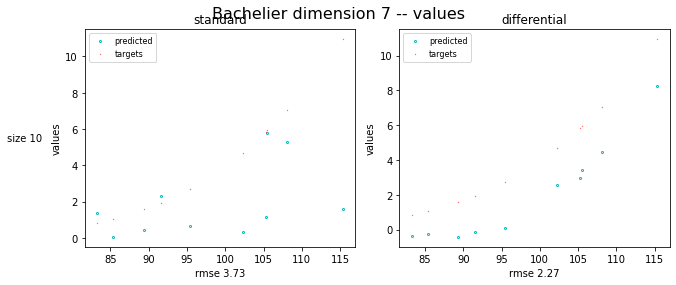

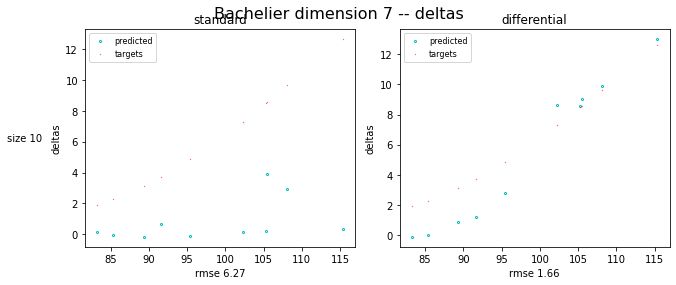

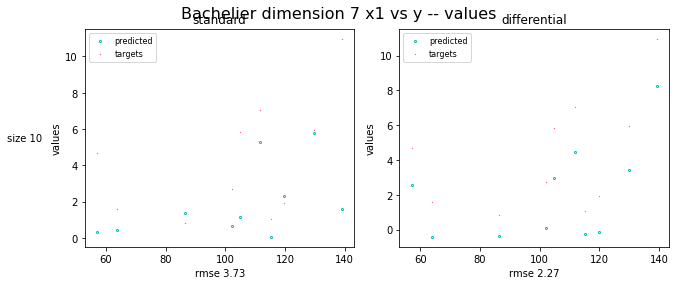

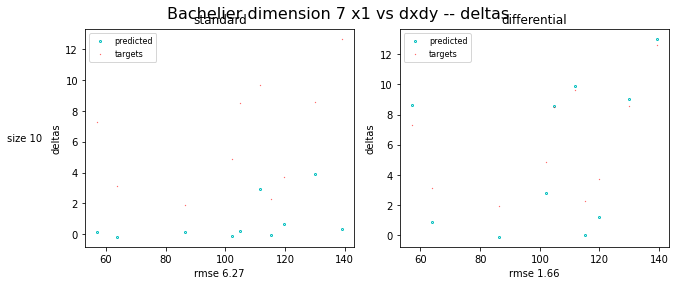

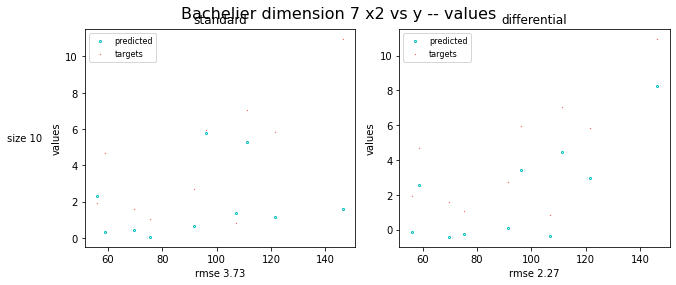

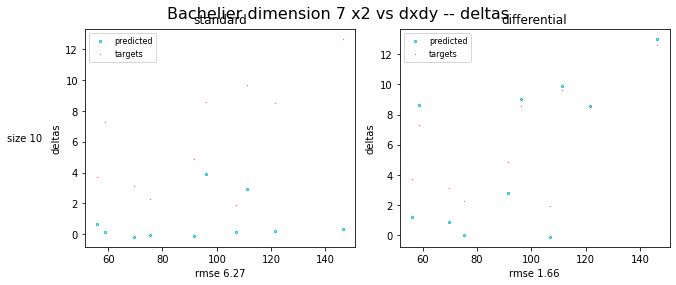

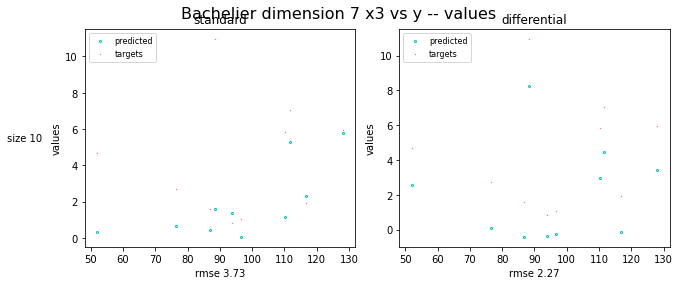

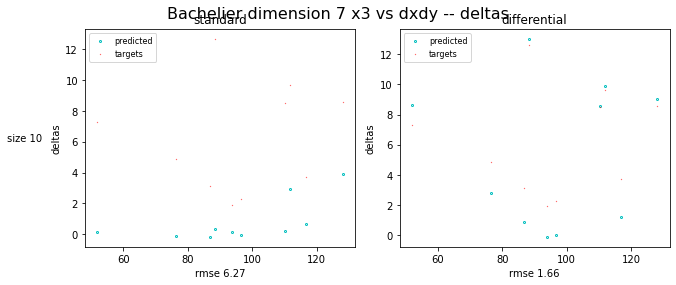

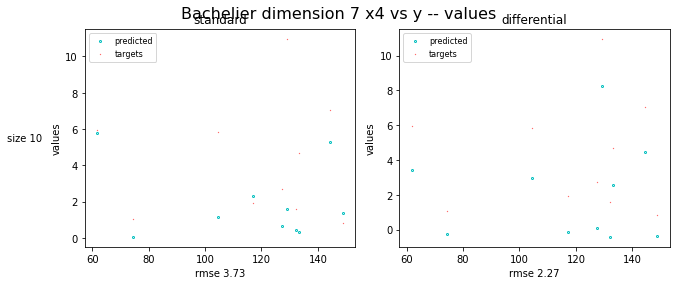

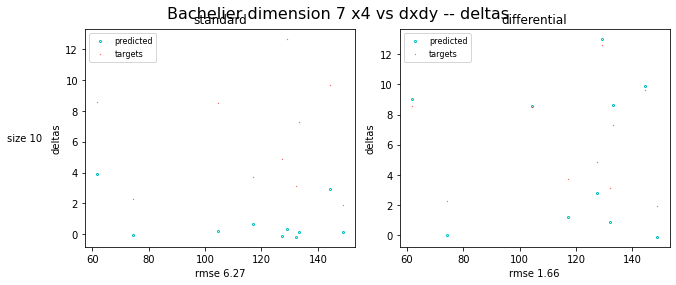

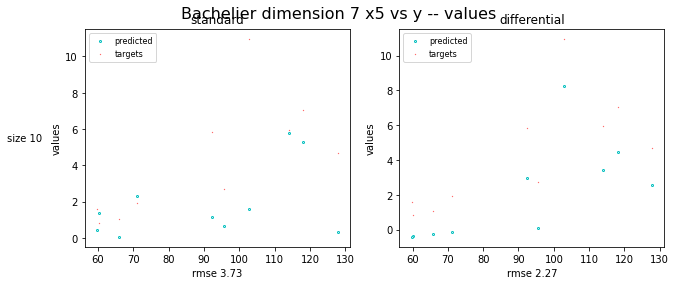

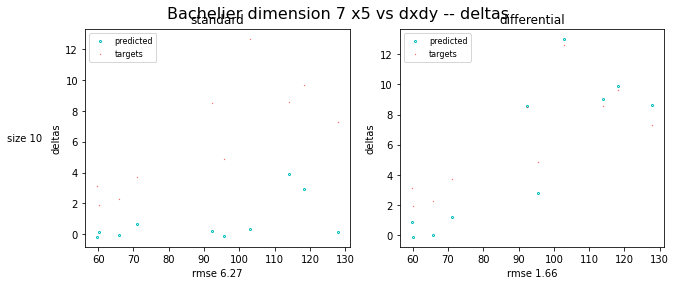

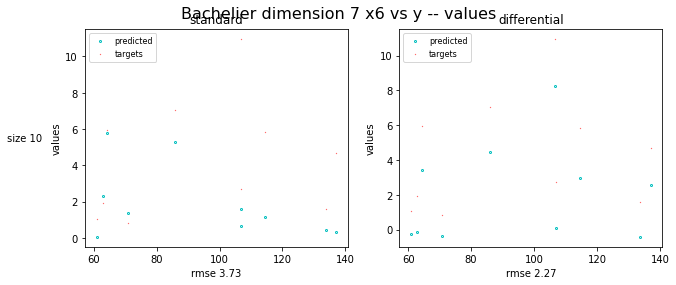

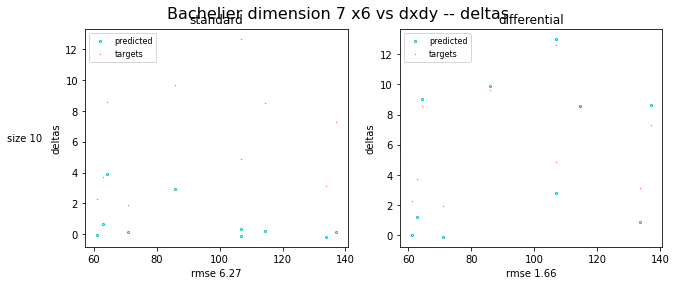

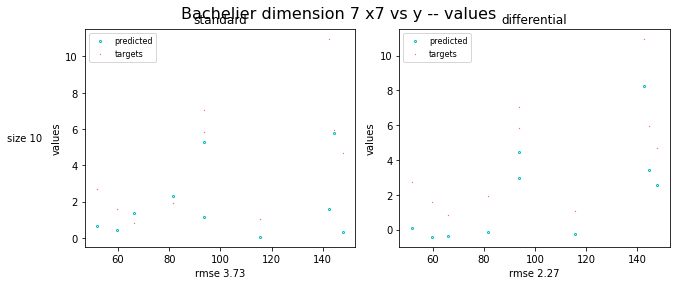

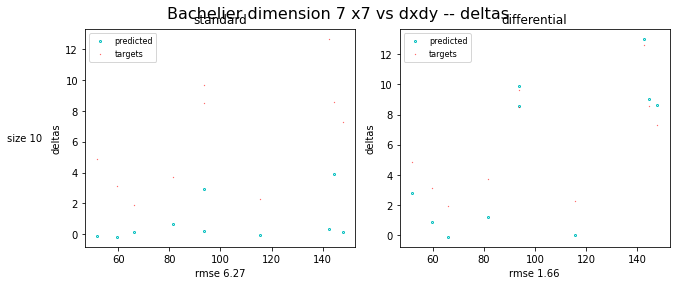

In [66]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN},
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM)

**siren = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 10



standard_yloss : 2.8216777
standard_dyloss : 281774900000000.0
differential_yloss : nan
differential_dyloss : nan
[[2.8216777], [281774900000000.0], [nan], [nan]]


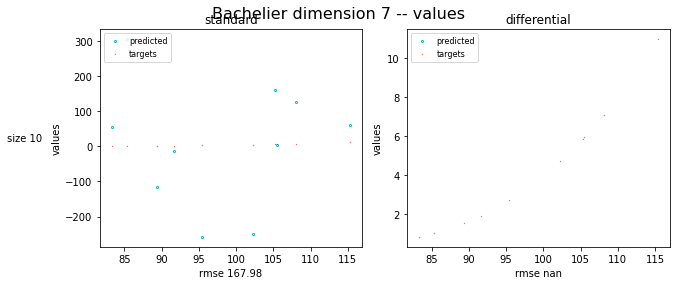

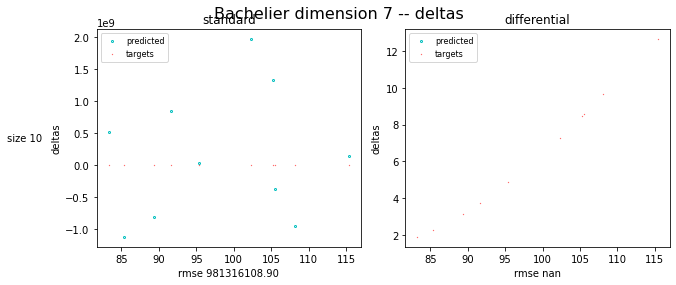

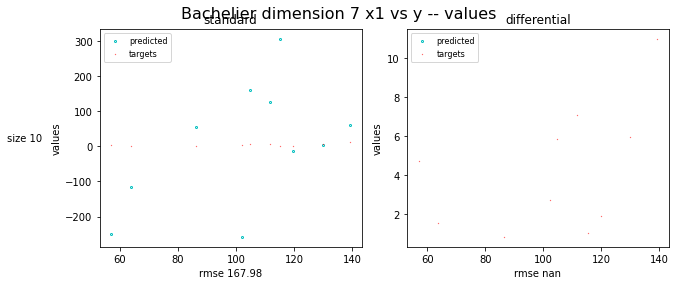

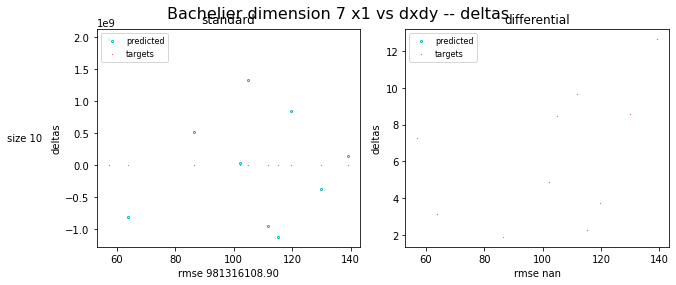

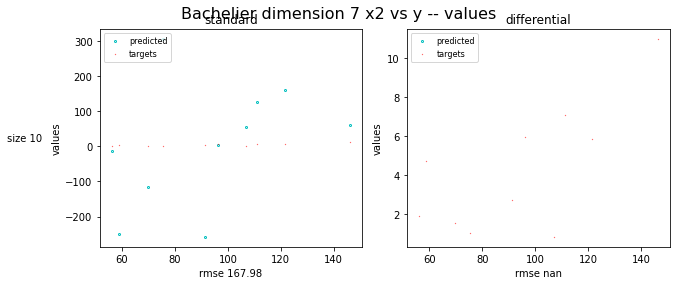

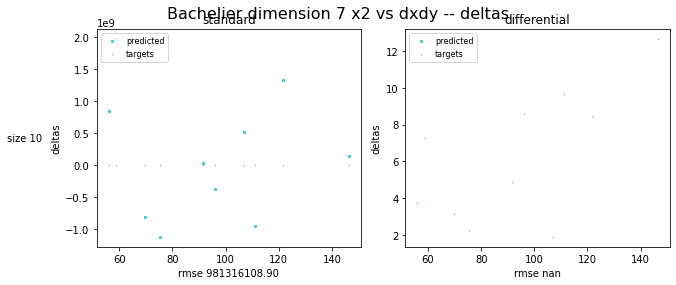

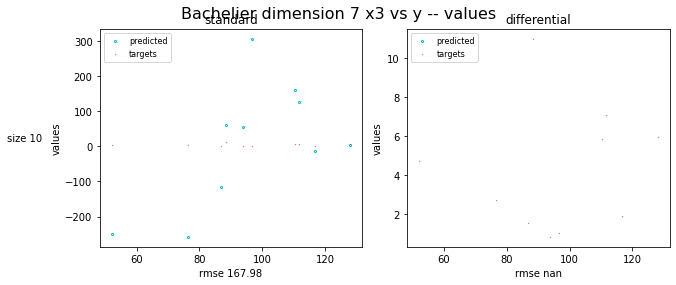

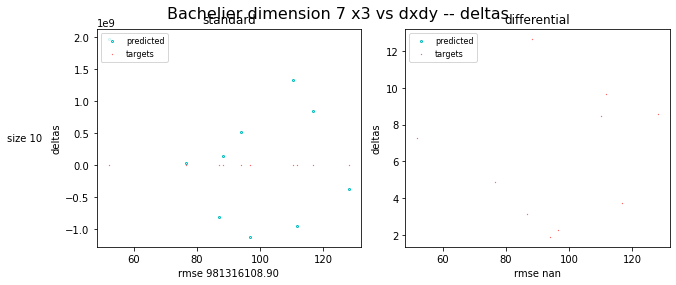

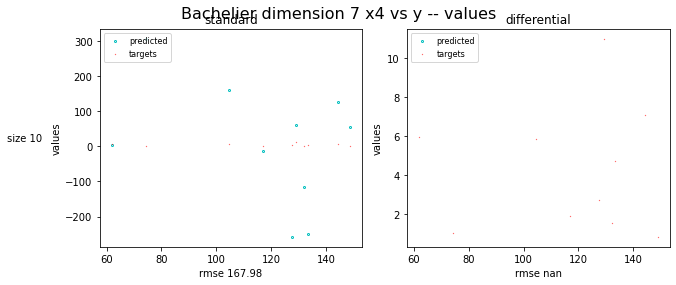

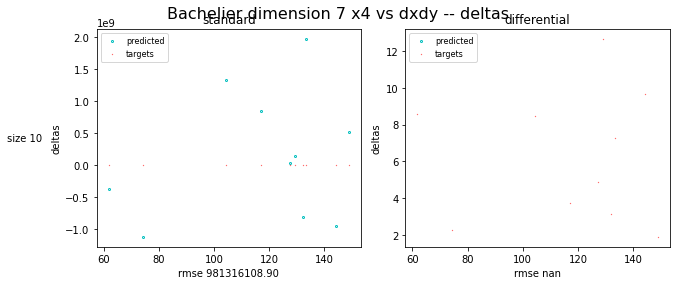

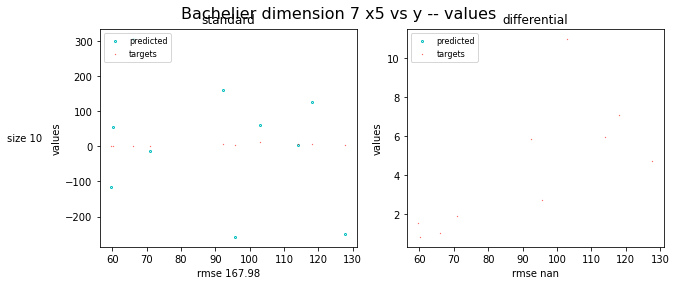

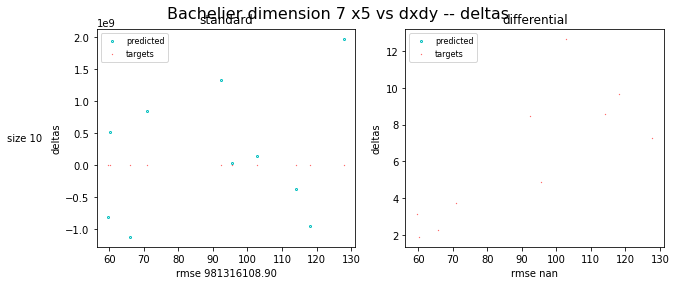

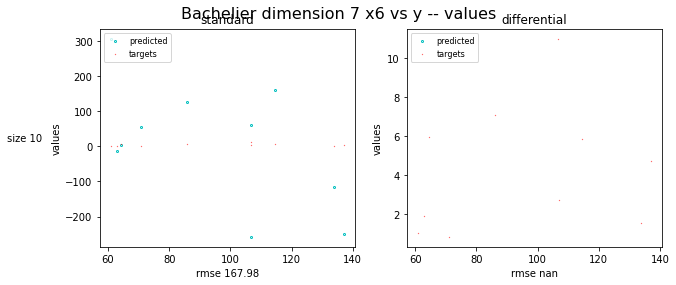

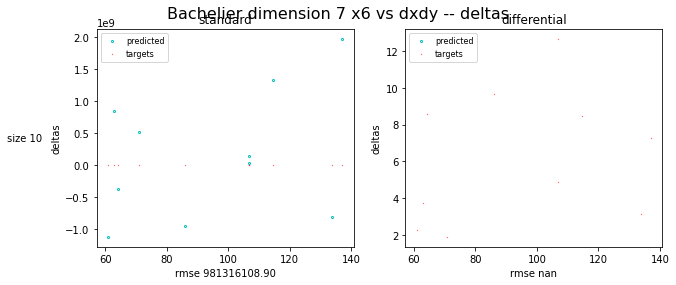

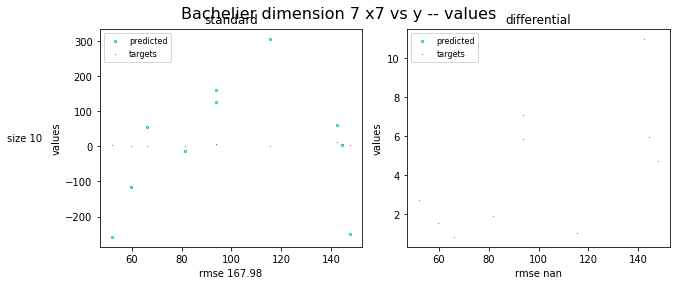

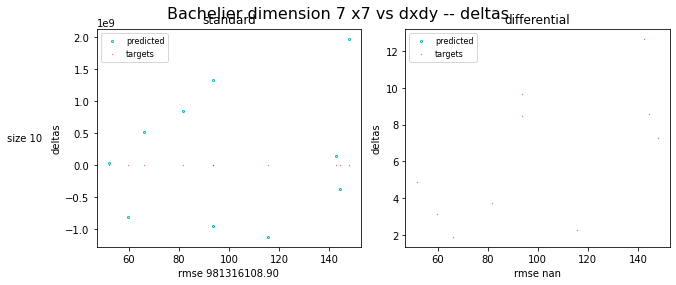

In [67]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN},
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM,
              siren = True)

### **2.2.5) twin_net with siren**

In [68]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, "outermost_linear" : outermost_linear, "first_omega_0" : first_omega_0, 
                "hidden_omega_0" : hidden_omega_0}
                
with_derivative = True

Epoch 0: train loss: 0.09195134788751602, y loss : 0.07607743889093399, dy loss : 0.015873907133936882
train loss no scaled: 0.09195134602487087, y loss  no scaled : 0.07607743889093399, dy loss  no scaled: 0.015873907133936882
Epoch 1: train loss: 0.0835459902882576, y loss : 0.06882894784212112, dy loss : 0.014717040583491325
train loss no scaled: 0.08354598842561245, y loss  no scaled : 0.06882894784212112, dy loss  no scaled: 0.014717040583491325
Epoch 2: train loss: 0.07739681750535965, y loss : 0.0632459819316864, dy loss : 0.014150836504995823
train loss no scaled: 0.07739681843668222, y loss  no scaled : 0.0632459819316864, dy loss  no scaled: 0.014150836504995823
Epoch 3: train loss: 0.07007037103176117, y loss : 0.05931135639548302, dy loss : 0.010759015567600727
train loss no scaled: 0.07007037196308374, y loss  no scaled : 0.05931135639548302, dy loss  no scaled: 0.010759015567600727
Epoch 4: train loss: 0.06937838345766068, y loss : 0.057235684245824814, dy loss : 0.012142

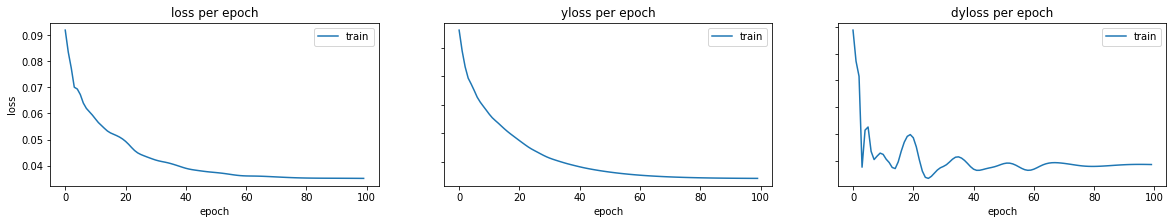

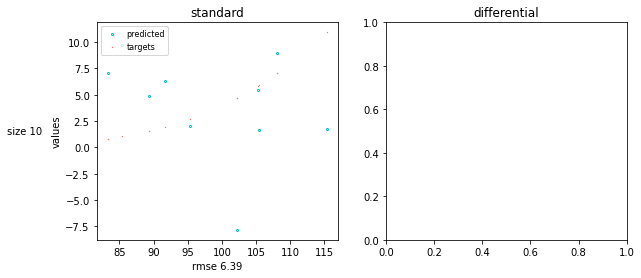

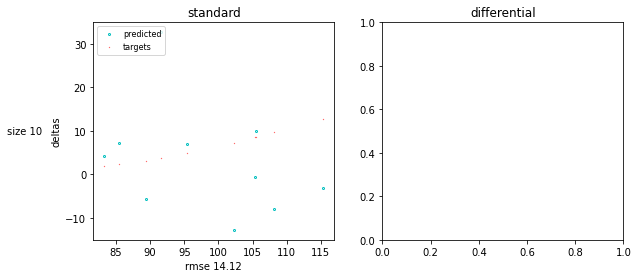

In [69]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = Siren, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = False)

Epoch 0: train loss: 1.8424829615595566, y loss : 1.0281084775924683, dy loss : 1.958822173554855
train loss no scaled: 0.039486413821578026, y loss  no scaled : 0.02491152472794056, dy loss  no scaled: 0.014574889093637466
Epoch 1: train loss: 1.5684370632355122, y loss : 1.0205276012420654, dy loss : 1.6467098435202903
train loss no scaled: 0.03710613679140806, y loss  no scaled : 0.024727838113904, dy loss  no scaled: 0.012378298677504063
Epoch 2: train loss: 1.4349092865905553, y loss : 1.016677737236023, dy loss : 1.49465665078406
train loss no scaled: 0.036320704966783524, y loss  no scaled : 0.024634556844830513, dy loss  no scaled: 0.01168614812195301
Epoch 3: train loss: 1.3159224707248227, y loss : 1.0137115716934204, dy loss : 1.3590954563007374
train loss no scaled: 0.03574248868972063, y loss  no scaled : 0.02456267923116684, dy loss  no scaled: 0.011179809458553791
Epoch 4: train loss: 1.3492783559327108, y loss : 1.0112676620483398, dy loss : 1.3975655979161925
train los

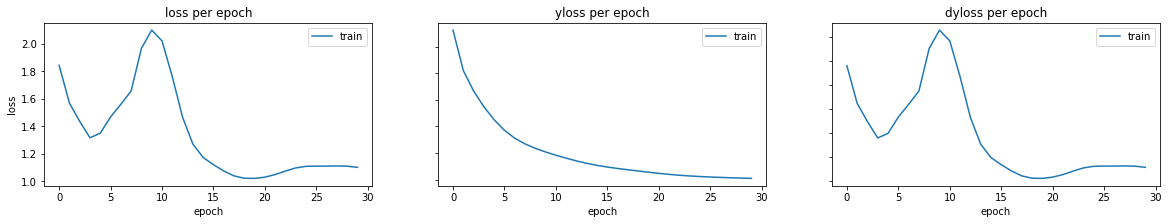

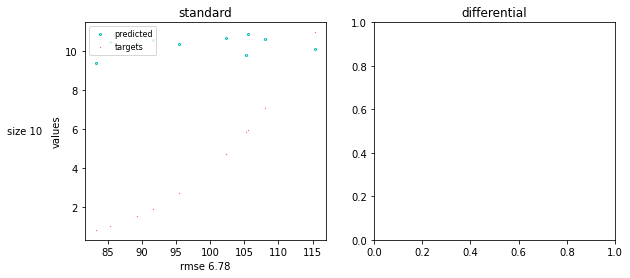

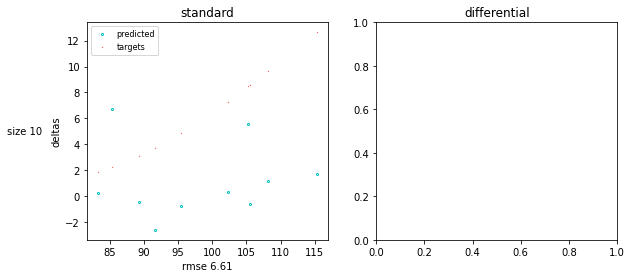

In [70]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = Siren, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = True)

### **2.2.6) twin_net with MLP**

In [71]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, 
                "activation_function" : F.softplus, # This is what was done in the original code.
                "deriv_activation_function" : F.sigmoid
                }
                
with_derivative = True

Epoch 0: train loss: 0.4554639756679535, y loss : 0.4444866478443146, dy loss : 0.010977337136864662
train loss no scaled: 0.45546398498117924, y loss  no scaled : 0.4444866478443146, dy loss  no scaled: 0.010977337136864662
Epoch 1: train loss: 0.4526731073856354, y loss : 0.4416956603527069, dy loss : 0.010977433063089848
train loss no scaled: 0.45267309341579676, y loss  no scaled : 0.4416956603527069, dy loss  no scaled: 0.010977433063089848
Epoch 2: train loss: 0.4498974084854126, y loss : 0.43891987204551697, dy loss : 0.010977528989315033
train loss no scaled: 0.449897401034832, y loss  no scaled : 0.43891987204551697, dy loss  no scaled: 0.010977528989315033
Epoch 3: train loss: 0.4471370279788971, y loss : 0.4361594021320343, dy loss : 0.010977622121572495
train loss no scaled: 0.4471370242536068, y loss  no scaled : 0.4361594021320343, dy loss  no scaled: 0.010977622121572495
Epoch 4: train loss: 0.44439226388931274, y loss : 0.4334145486354828, dy loss : 0.01097771804779768


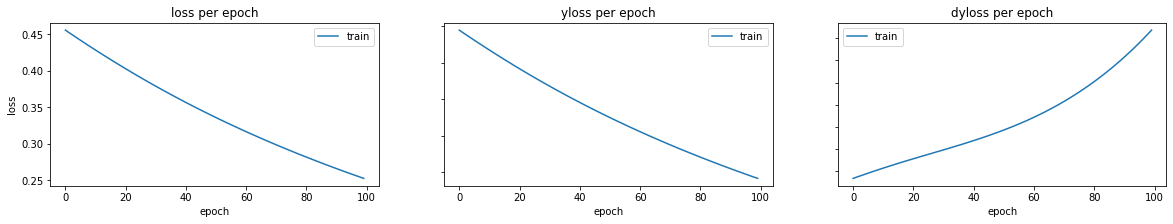

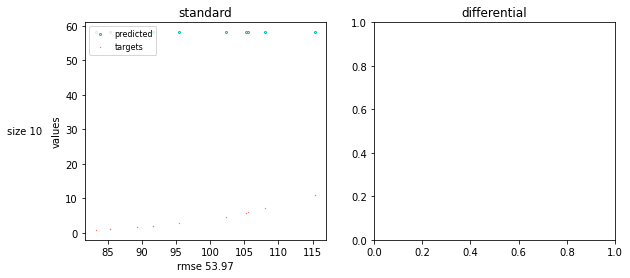

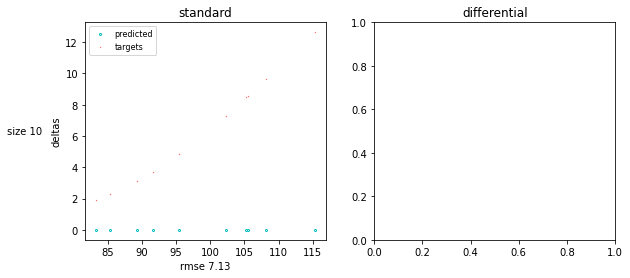

In [72]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = False)

Epoch 0: train loss: 1.0173709460311062, y loss : 1.1207636594772339, dy loss : 1.0026005583959452
train loss no scaled: 0.0377568518742919, y loss  no scaled : 0.02715660072863102, dy loss  no scaled: 0.010600251145660877
Epoch 1: train loss: 1.0172332310580359, y loss : 1.1198776960372925, dy loss : 1.002569736060999
train loss no scaled: 0.03773537836968899, y loss  no scaled : 0.027135131880640984, dy loss  no scaled: 0.010600246489048004
Epoch 2: train loss: 1.0170958244961297, y loss : 1.1189967393875122, dy loss : 1.0025385509402178
train loss no scaled: 0.03771402407437563, y loss  no scaled : 0.027113784104585648, dy loss  no scaled: 0.010600239969789982
Epoch 3: train loss: 1.016958679853717, y loss : 1.118120551109314, dy loss : 1.0025069839600602
train loss no scaled: 0.03769279923290014, y loss  no scaled : 0.02709256485104561, dy loss  no scaled: 0.010600234381854534
Epoch 4: train loss: 1.0168219123616122, y loss : 1.1172500848770142, dy loss : 1.0024750305736976
train l

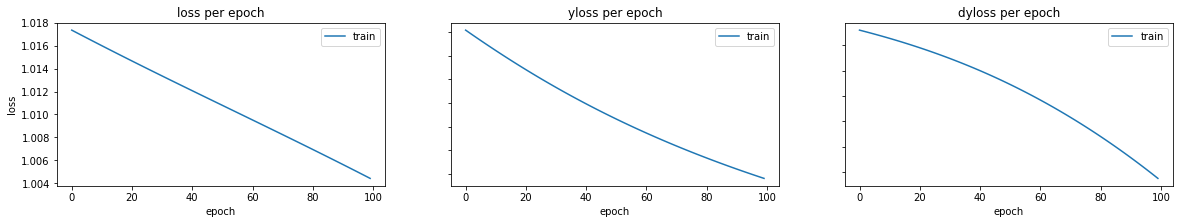

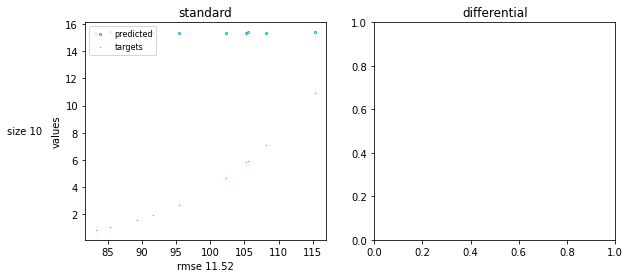

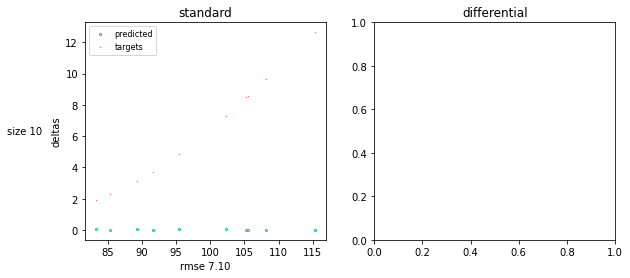

In [73]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = True)

## **2.3) Bachelier dimension 20**

In [74]:
INPUT_DIM = 20
generator = Bachelier(n = INPUT_DIM)
graph_name = "Bachelier dimension %d" % INPUT_DIM

### **2.3.1) Normal Training**

Epoch 0: train loss: 0.02055913768708706 train loss no scaled: 0.02055913768708706
Epoch 1: train loss: 0.020359719172120094 train loss no scaled: 0.020359719172120094
Epoch 2: train loss: 0.02016269415616989 train loss no scaled: 0.02016269415616989
Epoch 3: train loss: 0.01996781677007675 train loss no scaled: 0.01996781677007675
Epoch 4: train loss: 0.019774669781327248 train loss no scaled: 0.019774669781327248
Epoch 5: train loss: 0.01958347111940384 train loss no scaled: 0.01958347111940384
Epoch 6: train loss: 0.019393645226955414 train loss no scaled: 0.019393645226955414
Epoch 7: train loss: 0.019205082207918167 train loss no scaled: 0.019205082207918167
Epoch 8: train loss: 0.019018791615962982 train loss no scaled: 0.019018791615962982
Epoch 9: train loss: 0.018834097310900688 train loss no scaled: 0.018834097310900688
Epoch 10: train loss: 0.01865069381892681 train loss no scaled: 0.01865069381892681
Epoch 11: train loss: 0.018468599766492844 train loss no scaled: 0.0184685

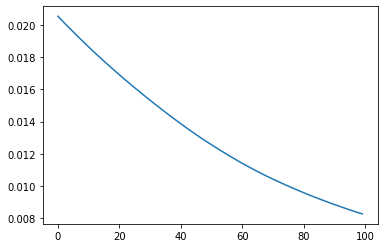

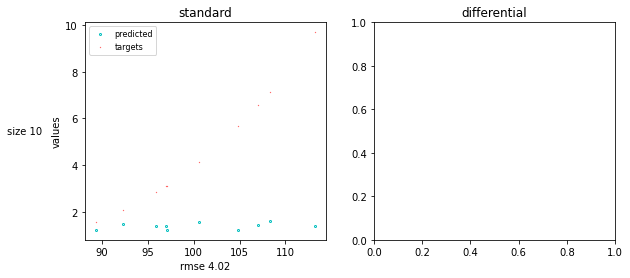

In [75]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = False, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = False
)

Epoch 0: train loss: 1.0035154819488525 train loss no scaled: 0.0059043001383543015
Epoch 1: train loss: 1.0034441947937012 train loss no scaled: 0.005903879180550575
Epoch 2: train loss: 1.003373622894287 train loss no scaled: 0.005903463810682297
Epoch 3: train loss: 1.0033038854599 train loss no scaled: 0.005903053097426891
Epoch 4: train loss: 1.0032349824905396 train loss no scaled: 0.0059026493690907955
Epoch 5: train loss: 1.0031676292419434 train loss no scaled: 0.005902251694351435
Epoch 6: train loss: 1.0031009912490845 train loss no scaled: 0.005901860073208809
Epoch 7: train loss: 1.0030354261398315 train loss no scaled: 0.005901474505662918
Epoch 8: train loss: 1.0029706954956055 train loss no scaled: 0.0059010935947299
Epoch 9: train loss: 1.0029067993164062 train loss no scaled: 0.005900717806071043
Epoch 10: train loss: 1.002844214439392 train loss no scaled: 0.005900349467992783
Epoch 11: train loss: 1.0027836561203003 train loss no scaled: 0.0058999937027692795
Epoch 

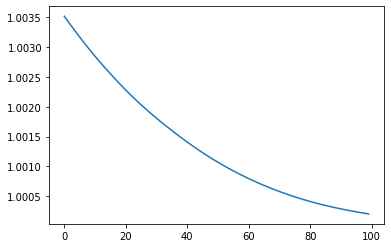

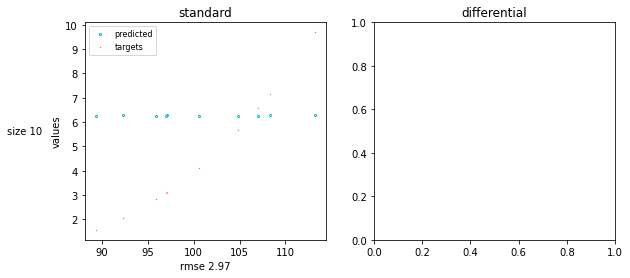

In [76]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = False, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = True
)

### **2.3.2) Sobolev Training**


Epoch 0: train loss: 0.04185651242733002, y loss : 0.041118133813142776, dy loss : 0.000738378323148936
train loss no scaled: 0.04185651213629171, y loss  no scaled : 0.041118133813142776, dy loss  no scaled: 0.000738378323148936
Epoch 1: train loss: 0.0415898859500885, y loss : 0.04085167497396469, dy loss : 0.0007382096955552697
train loss no scaled: 0.04158988466951996, y loss  no scaled : 0.04085167497396469, dy loss  no scaled: 0.0007382096955552697
Epoch 2: train loss: 0.041324347257614136, y loss : 0.04058630391955376, dy loss : 0.0007380416500382125
train loss no scaled: 0.04132434556959197, y loss  no scaled : 0.04058630391955376, dy loss  no scaled: 0.0007380416500382125
Epoch 3: train loss: 0.041060108691453934, y loss : 0.04032221436500549, dy loss : 0.0007378943264484406
train loss no scaled: 0.041060108691453934, y loss  no scaled : 0.04032221436500549, dy loss  no scaled: 0.0007378943264484406
Epoch 4: train loss: 0.04080178961157799, y loss : 0.04006371647119522, dy los

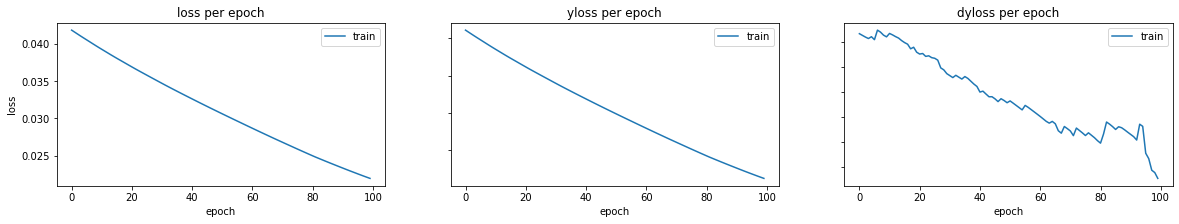

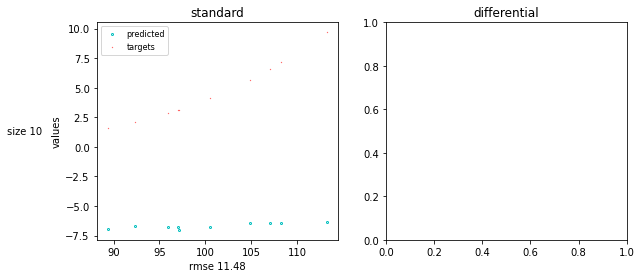

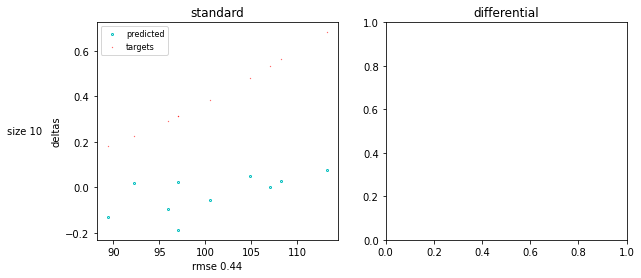

In [77]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = False
)

Epoch 0: train loss: 1.002372551506223, y loss : 1.0197935104370117, dy loss : 1.0015015039322126
train loss no scaled: 0.006947333982679993, y loss  no scaled : 0.006000072229653597, dy loss  no scaled: 0.000947261753026396
Epoch 1: train loss: 1.0023613371290931, y loss : 1.019625186920166, dy loss : 1.00149814259063
train loss no scaled: 0.006946347129996866, y loss  no scaled : 0.005999082699418068, dy loss  no scaled: 0.0009472644305787981
Epoch 2: train loss: 1.0023501290775378, y loss : 1.0194578170776367, dy loss : 1.0014947448637976
train loss no scaled: 0.006945365224964917, y loss  no scaled : 0.005998097825795412, dy loss  no scaled: 0.0009472673991695046
Epoch 3: train loss: 1.002338929019205, y loss : 1.0192914009094238, dy loss : 1.001491304679636
train loss no scaled: 0.006944388092961162, y loss  no scaled : 0.005997117608785629, dy loss  no scaled: 0.0009472704841755331
Epoch 4: train loss: 1.0023277171997527, y loss : 1.0191254615783691, dy loss : 1.0014878286769702


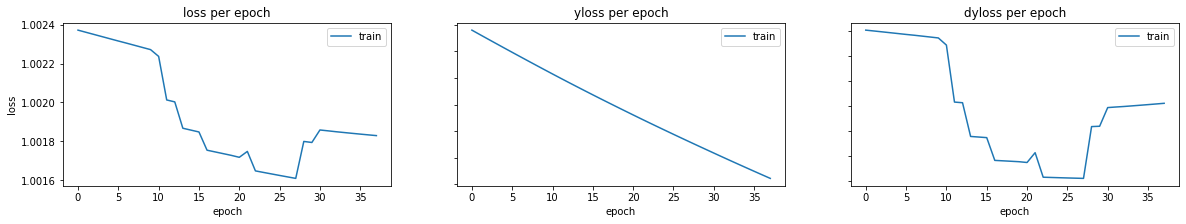

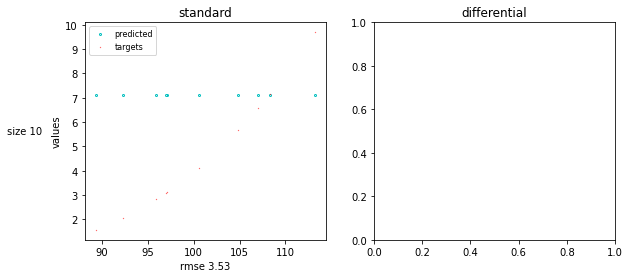

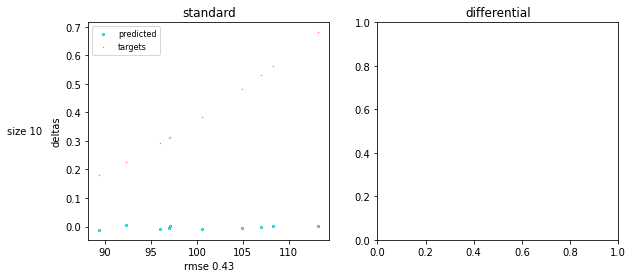

In [78]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = MLP_Relu, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1},
          normalize = True
)

### **2.3.3) SIREN**


Epoch 0: train loss: 0.06532182544469833, y loss : 0.06388639658689499, dy loss : 0.001435428741388023
train loss no scaled: 0.06532182532828301, y loss  no scaled : 0.06388639658689499, dy loss  no scaled: 0.001435428741388023
Epoch 1: train loss: 0.05858416110277176, y loss : 0.057283177971839905, dy loss : 0.0013009848771616817
train loss no scaled: 0.058584162849001586, y loss  no scaled : 0.057283177971839905, dy loss  no scaled: 0.0013009848771616817
Epoch 2: train loss: 0.05266362056136131, y loss : 0.051471784710884094, dy loss : 0.0011918352684006095
train loss no scaled: 0.052663619979284704, y loss  no scaled : 0.051471784710884094, dy loss  no scaled: 0.0011918352684006095
Epoch 3: train loss: 0.047592516988515854, y loss : 0.04643251746892929, dy loss : 0.0011599990539252758
train loss no scaled: 0.04759251652285457, y loss  no scaled : 0.04643251746892929, dy loss  no scaled: 0.0011599990539252758
Epoch 4: train loss: 0.043201521039009094, y loss : 0.042038869112730026, d

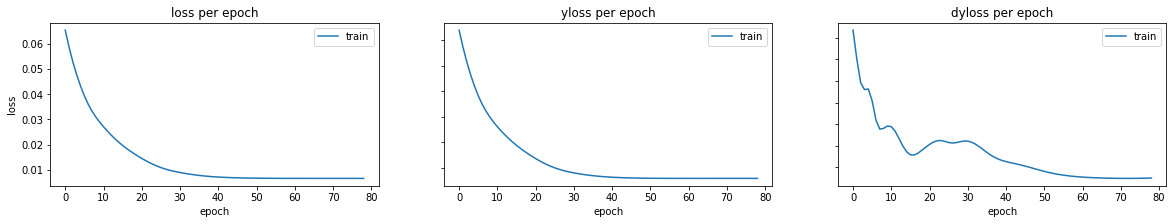

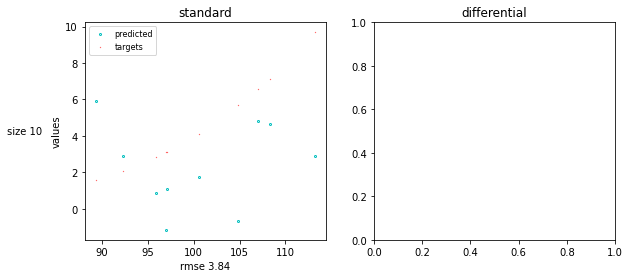

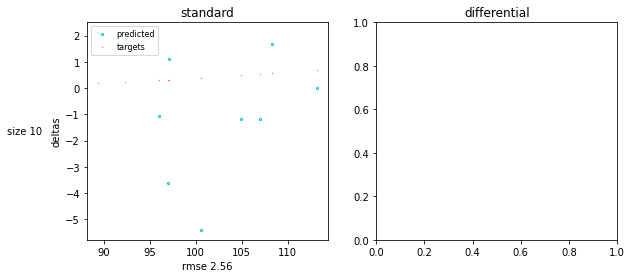

In [79]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = tf_Siren, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1,
                          "outermost_linear" : True},
          normalize = False
)

Epoch 0: train loss: 1.1255744004939034, y loss : 1.0564533472061157, dy loss : 1.1290304516681768
train loss no scaled: 0.007191614247858524, y loss  no scaled : 0.006215765606611967, dy loss  no scaled: 0.0009758486412465572
Epoch 1: train loss: 1.1182321660612373, y loss : 1.0500843524932861, dy loss : 1.1216395569258995
train loss no scaled: 0.007152139791287482, y loss  no scaled : 0.006178292445838451, dy loss  no scaled: 0.0009738473454490304
Epoch 2: train loss: 1.1004503668112877, y loss : 1.0443121194839478, dy loss : 1.1032572778738032
train loss no scaled: 0.007112563296686858, y loss  no scaled : 0.006144331302493811, dy loss  no scaled: 0.0009682319941930473
Epoch 3: train loss: 1.0784091297817031, y loss : 1.0392992496490479, dy loss : 1.0803646236020714
train loss no scaled: 0.007076353649608791, y loss  no scaled : 0.0061148363165557384, dy loss  no scaled: 0.0009615173330530524
Epoch 4: train loss: 1.0582401929843919, y loss : 1.0350406169891357, dy loss : 1.059400169

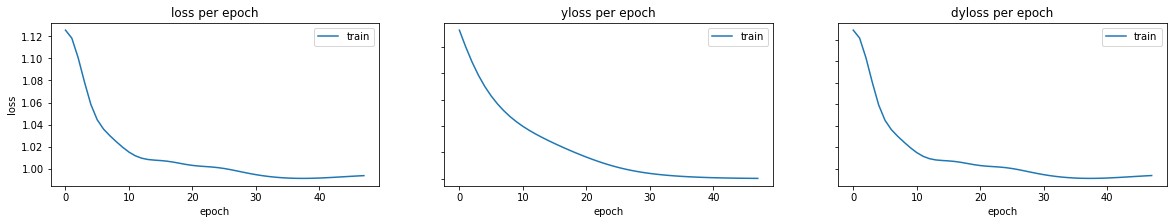

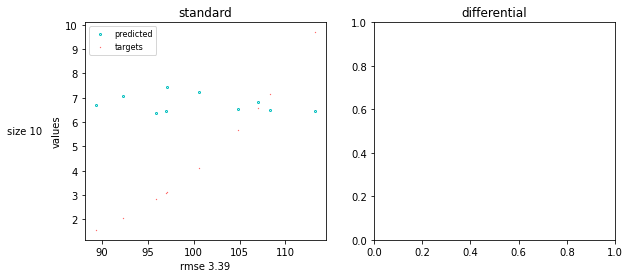

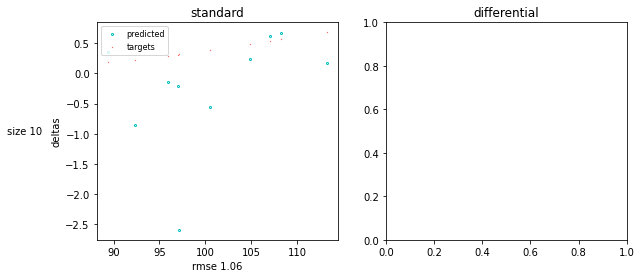

In [80]:
model, loss = run_train(
          name = graph_name,
          generator = generator, with_derivative = True, 
          model_class = tf_Siren, 
          model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, 
                          "hidden_layers" : N_HIDDEN, "out_features": 1,
                          "outermost_linear" : True},
          normalize = True
)

### **2.3.4) Differential ML**

**siren = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 10



standard_yloss : 0.0056131235
standard_dyloss : 0.0019247786
differential_yloss : 0.00018586856
differential_dyloss : 0.00014397339
[[0.0056131235], [0.0019247786], [0.00018586856], [0.00014397339]]


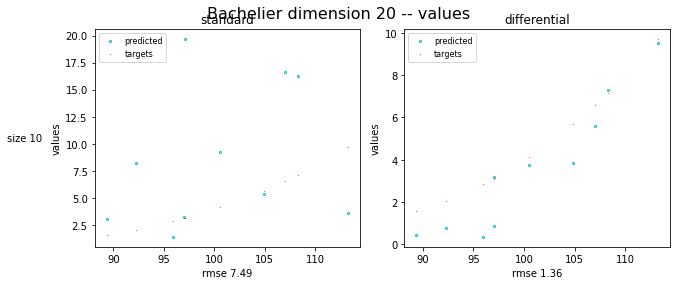

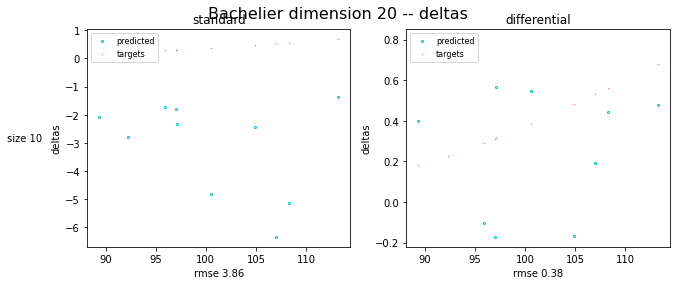

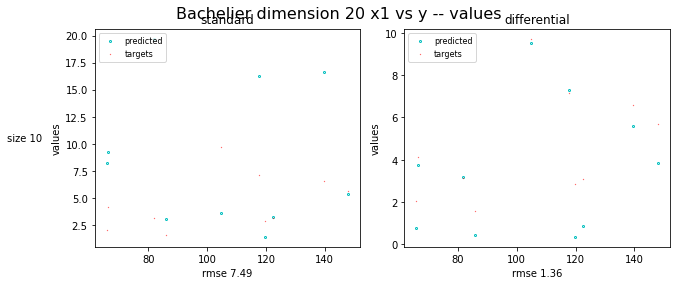

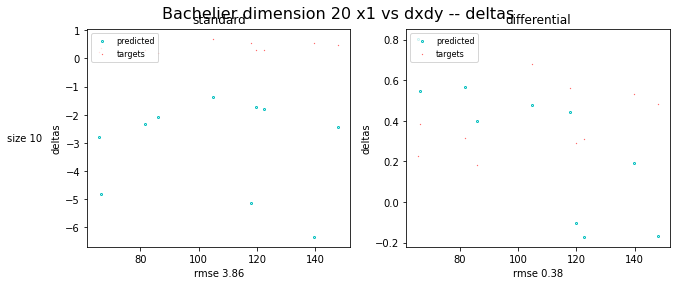

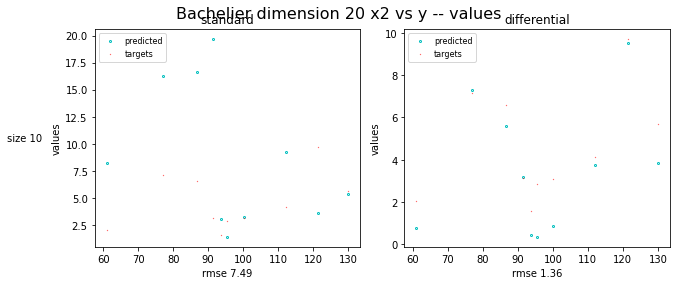

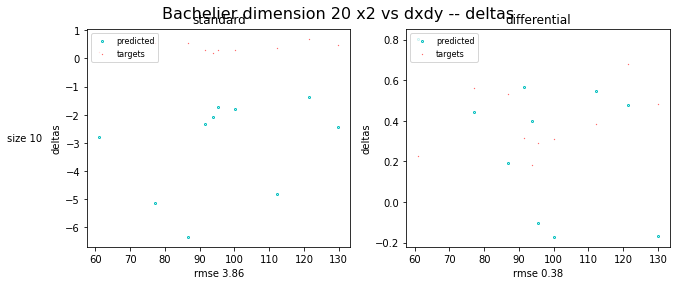

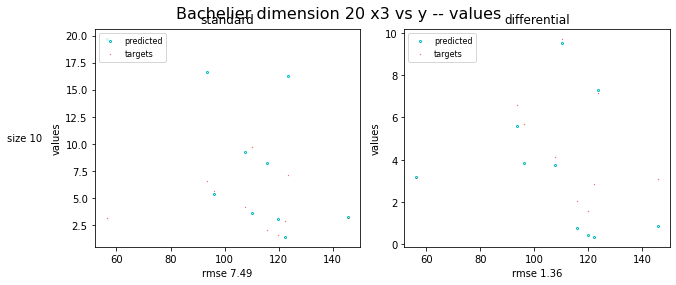

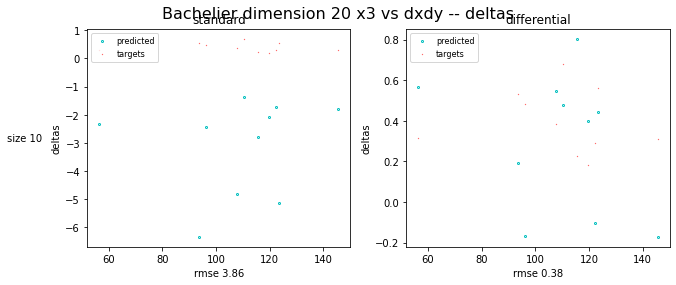

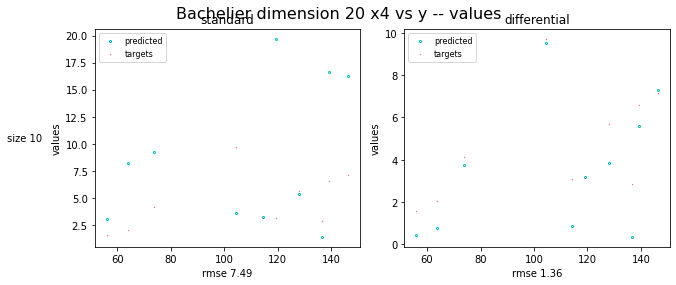

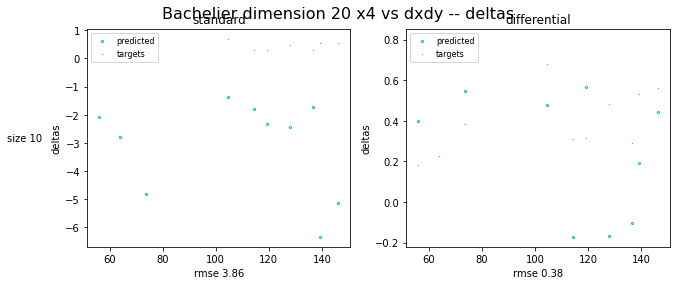

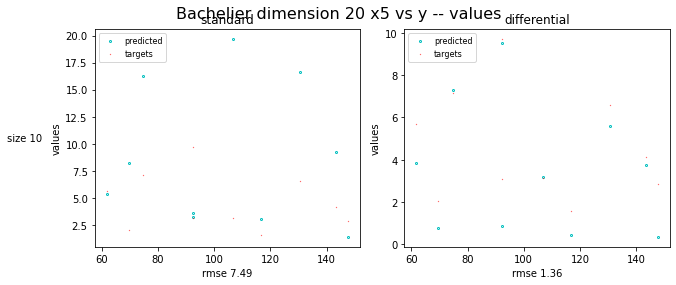

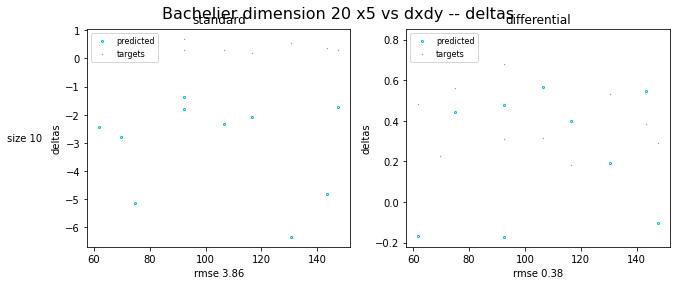

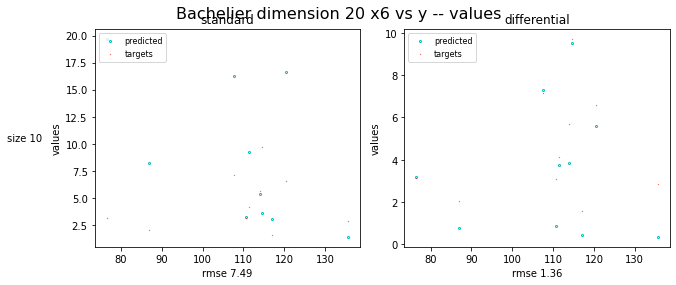

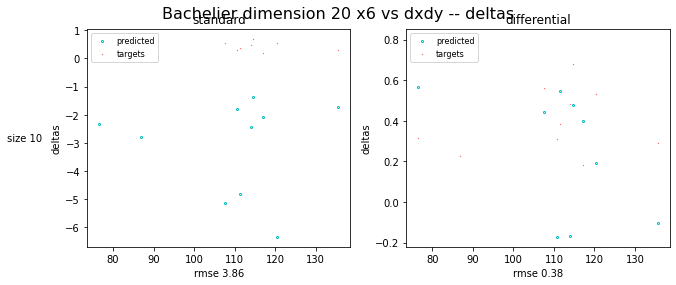

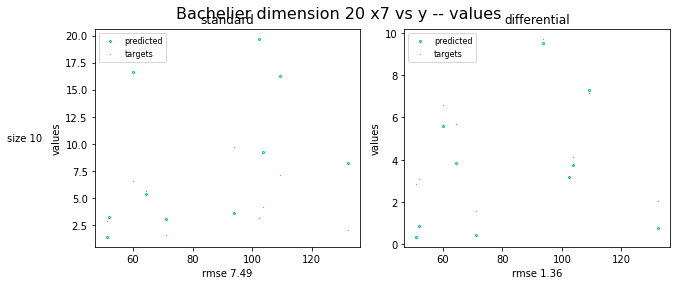

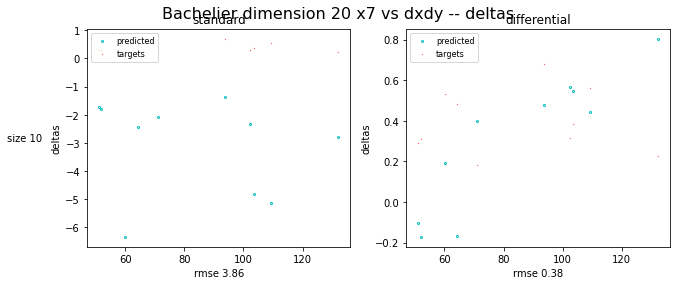

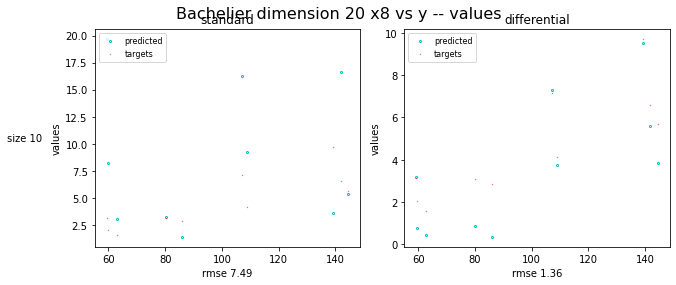

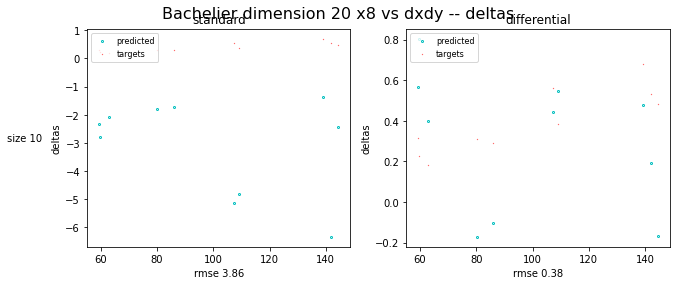

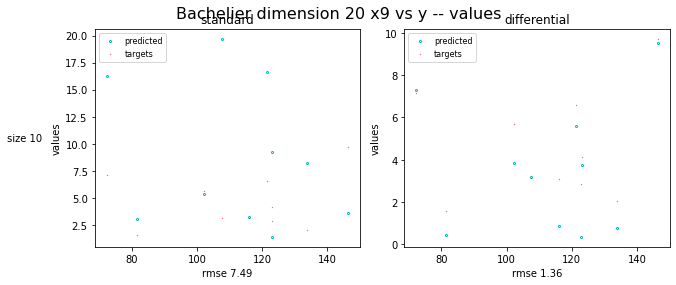

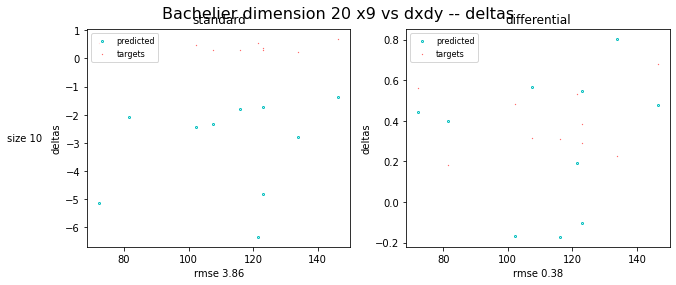

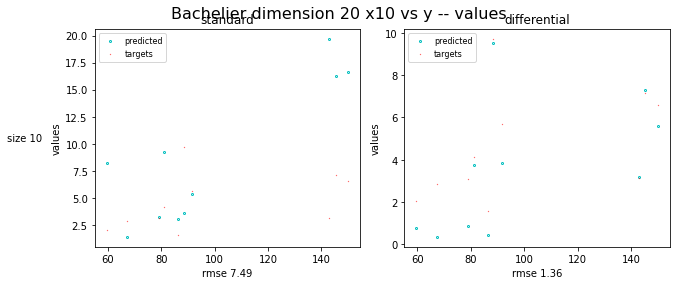

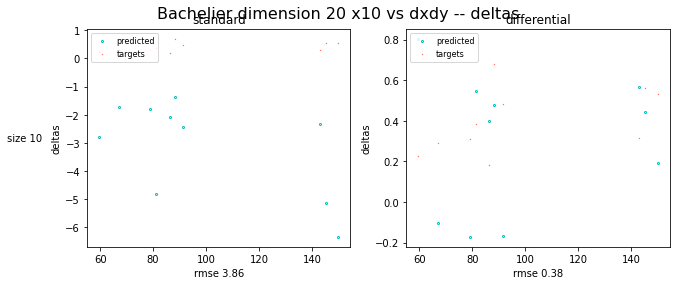

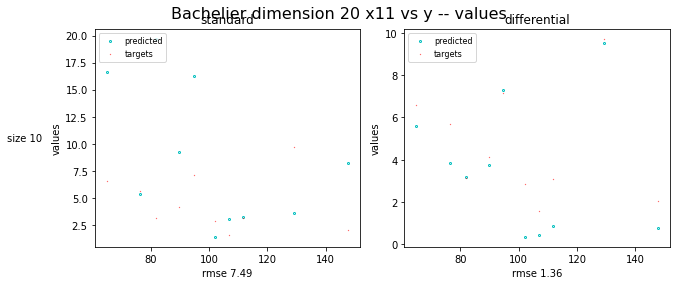

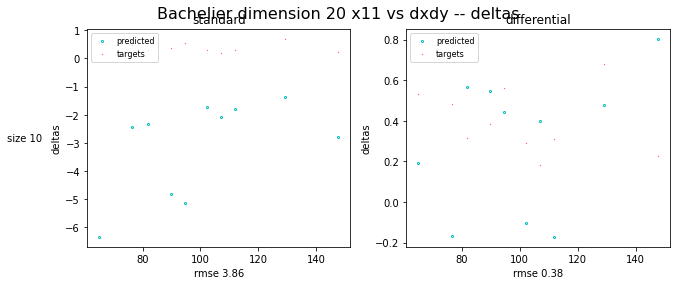

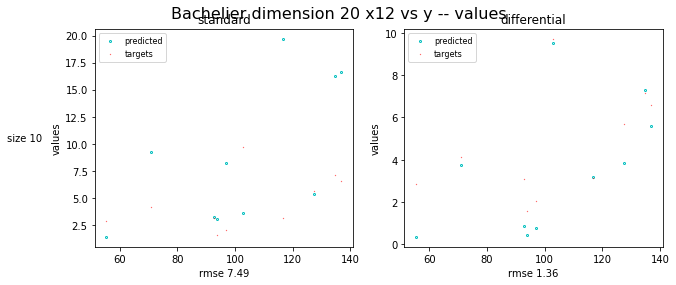

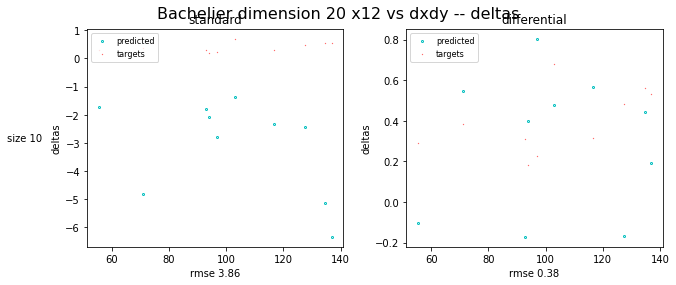

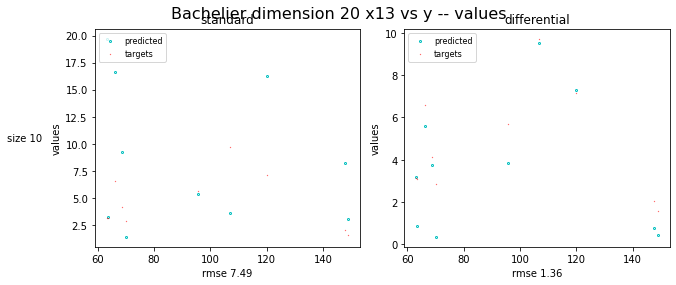

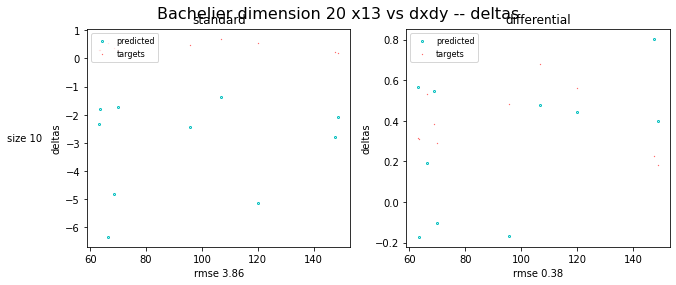

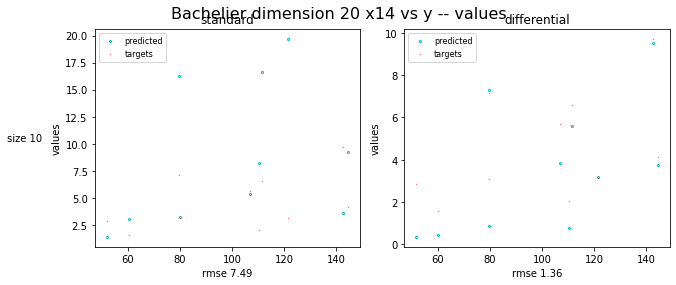

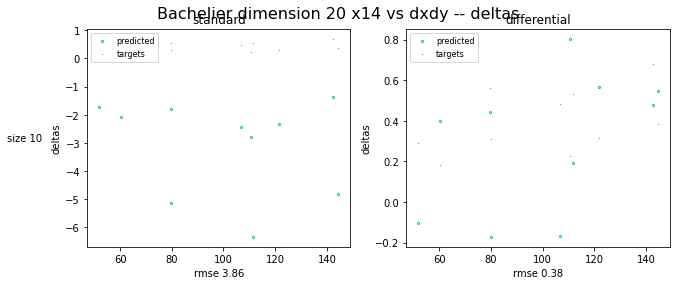

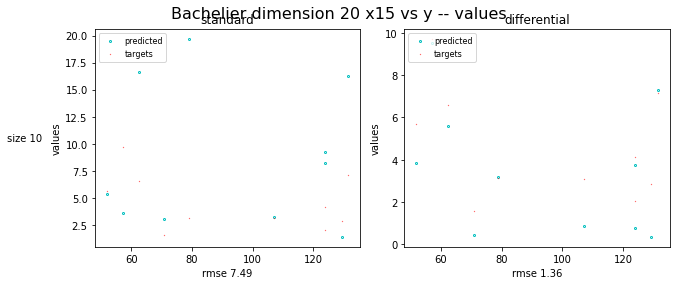

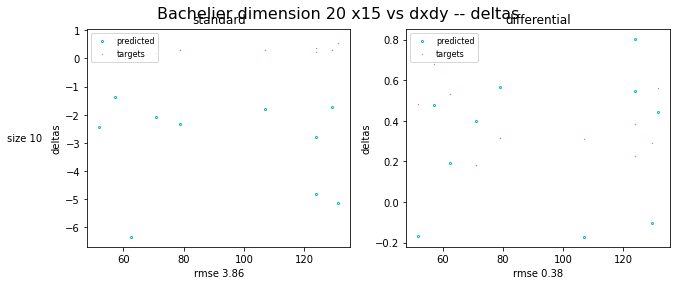

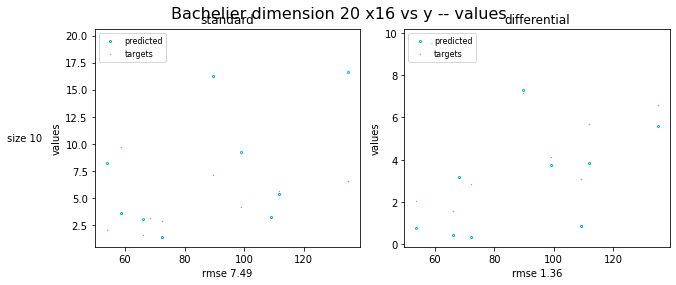

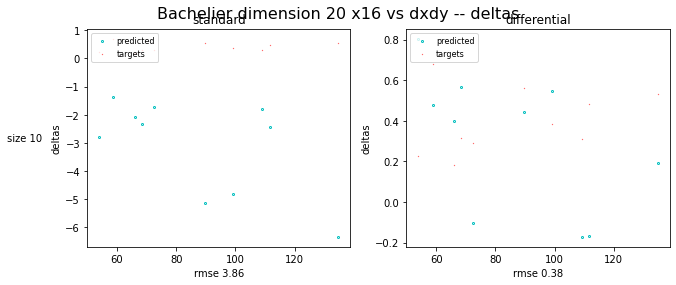

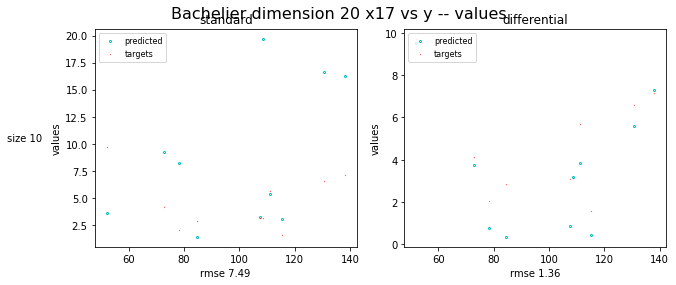

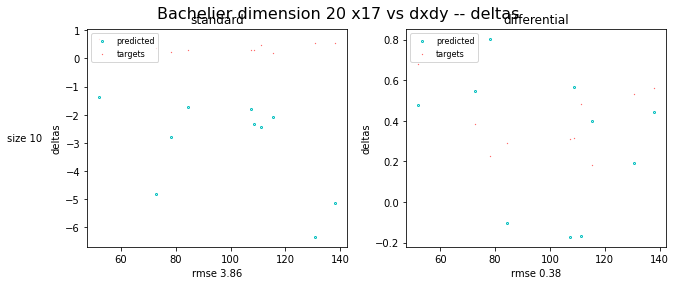

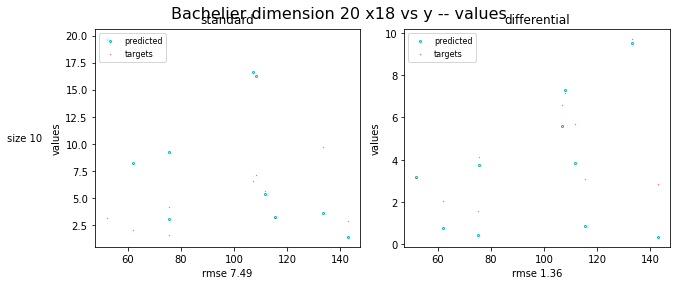

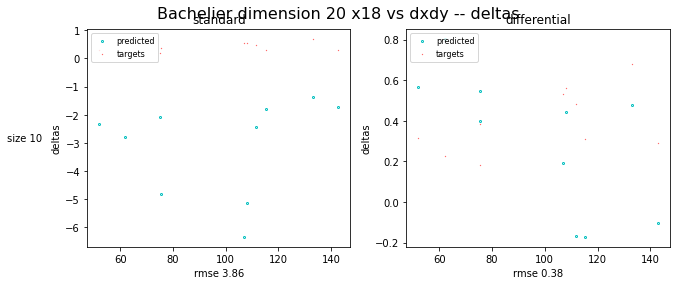

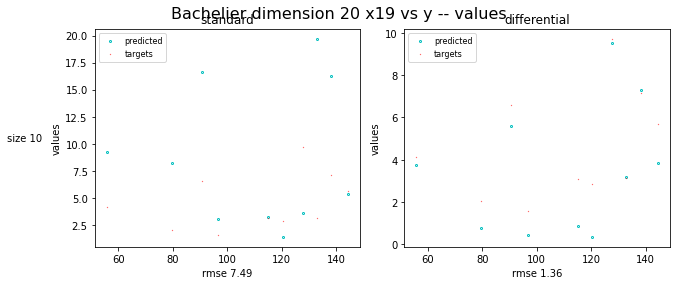

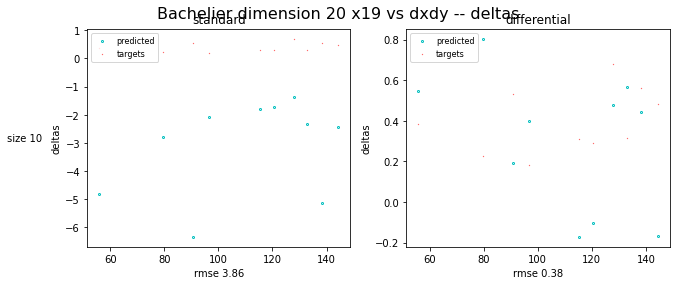

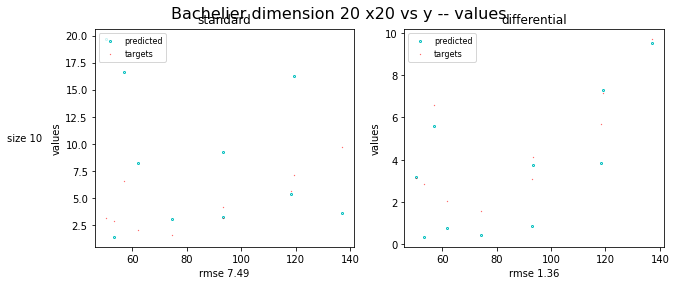

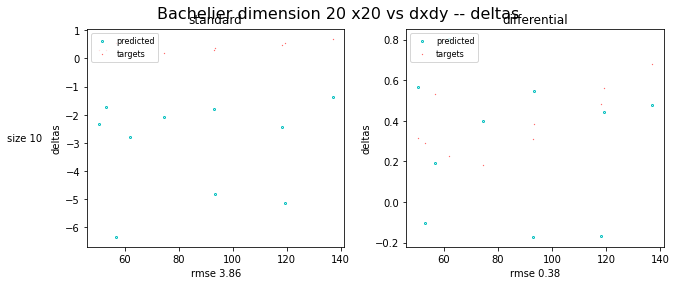

In [81]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN},
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM)

**siren = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 10



standard_yloss : 0.503603
standard_dyloss : 39920224000000.0
differential_yloss : nan
differential_dyloss : nan
[[0.503603], [39920224000000.0], [nan], [nan]]


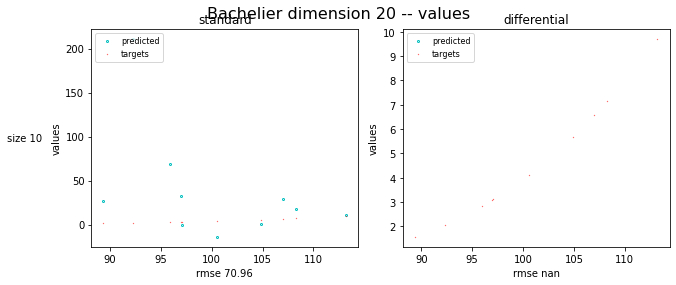

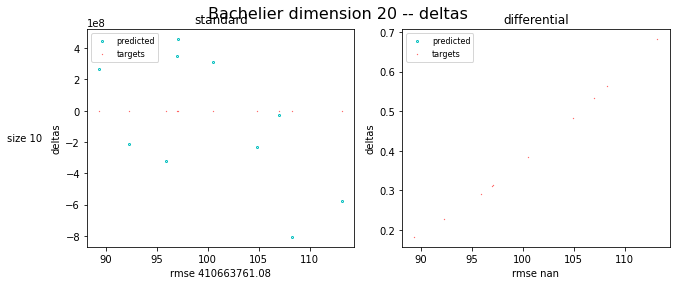

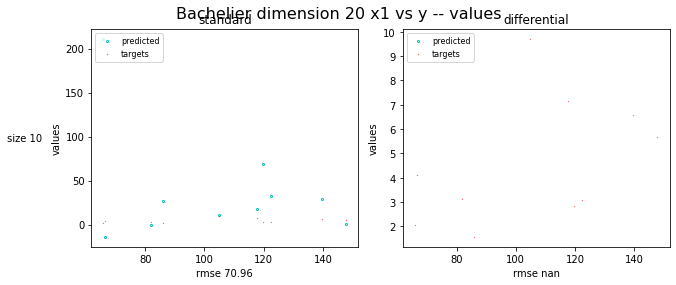

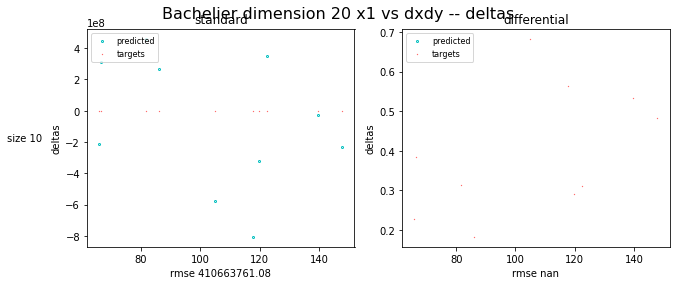

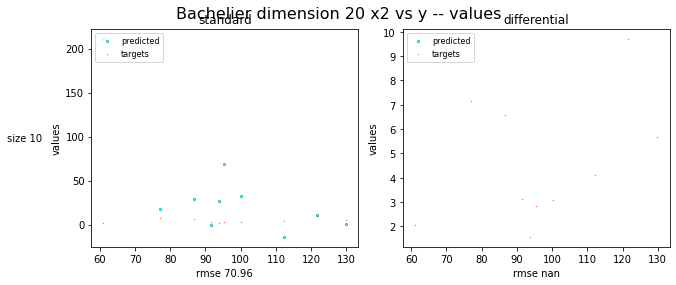

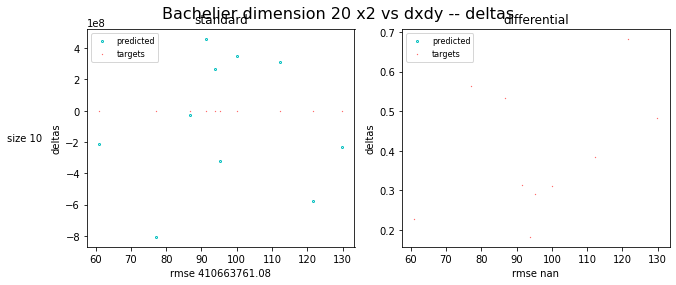

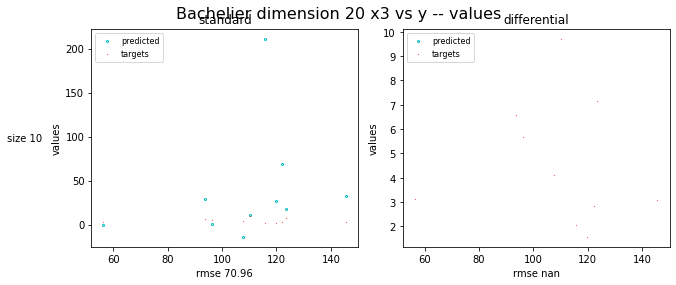

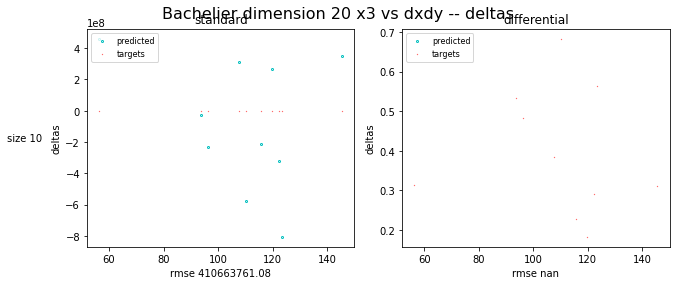

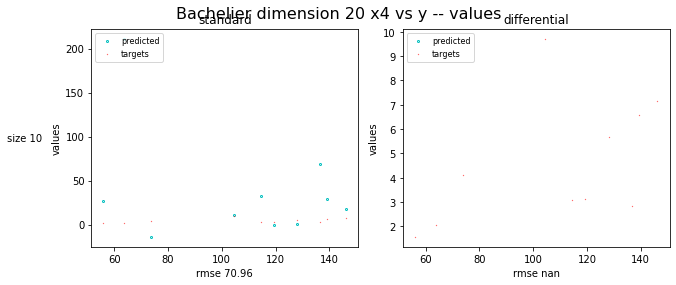

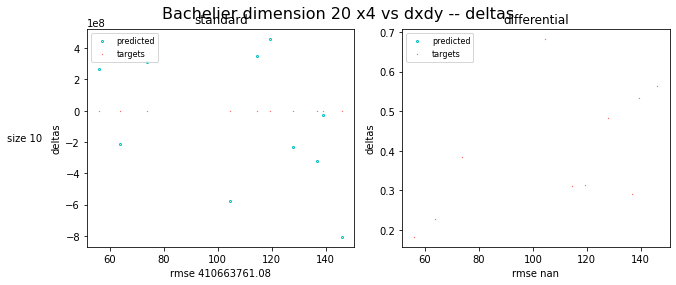

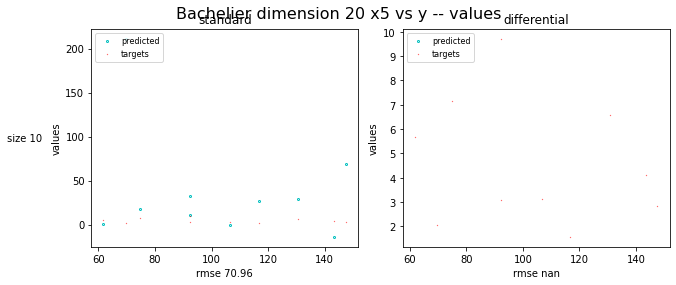

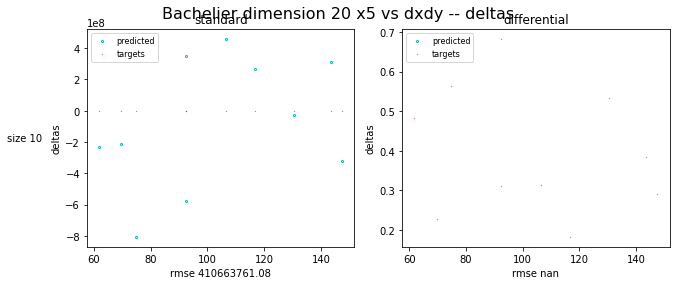

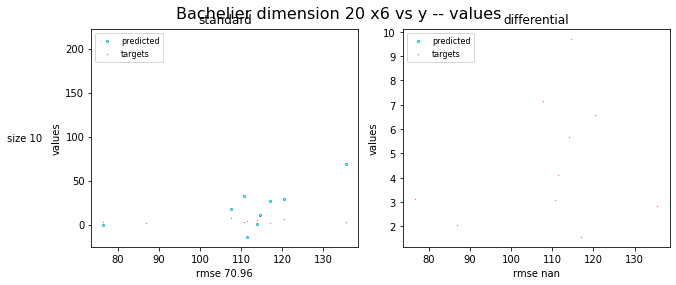

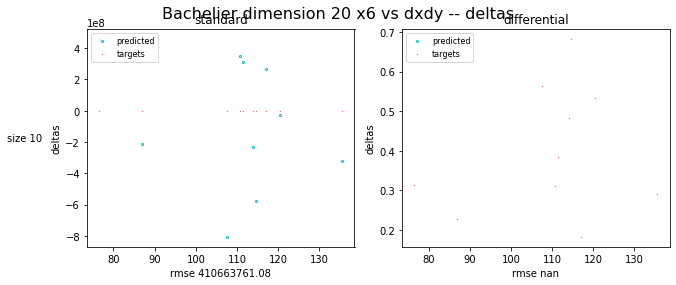

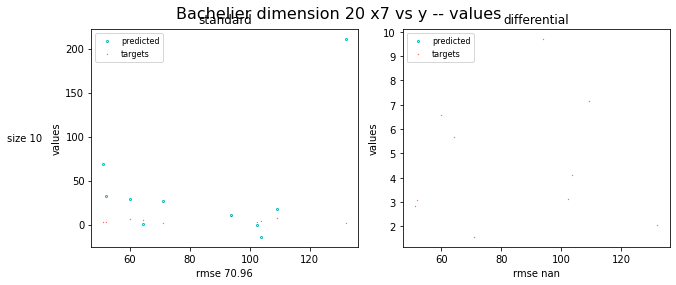

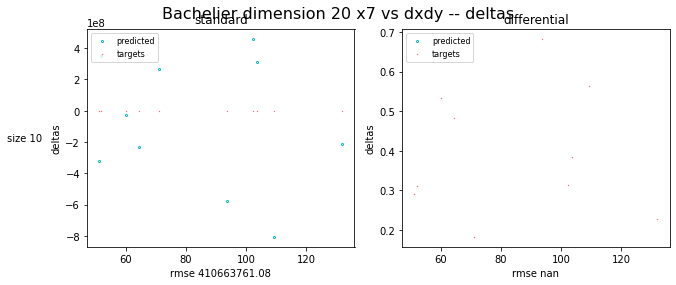

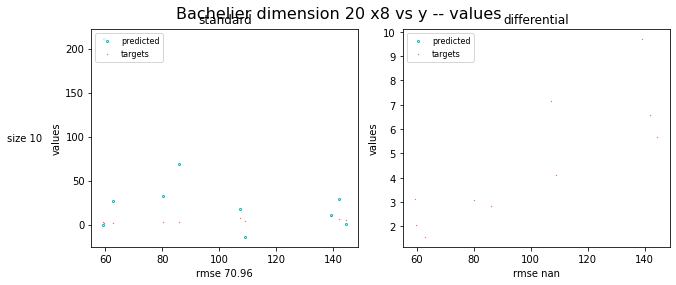

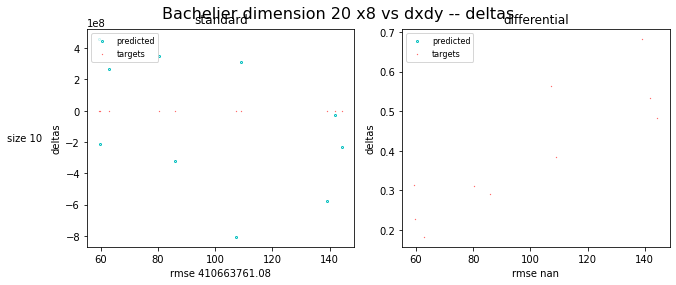

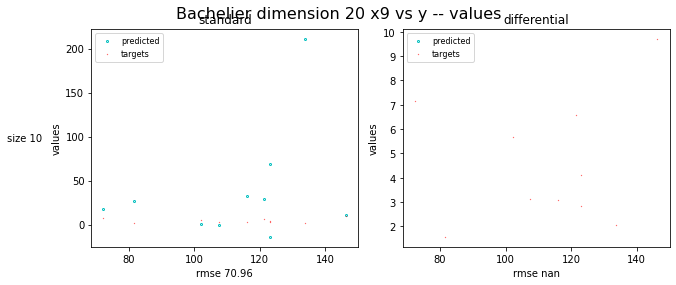

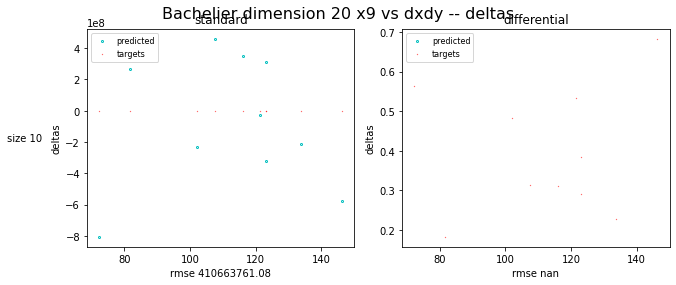

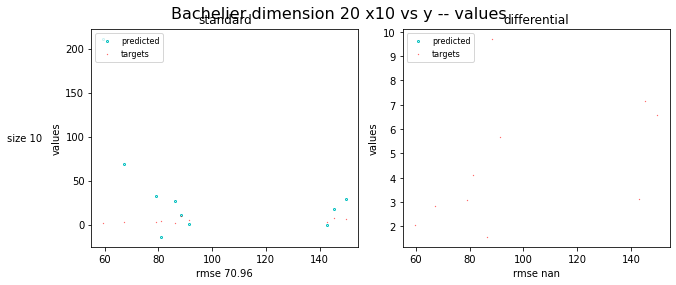

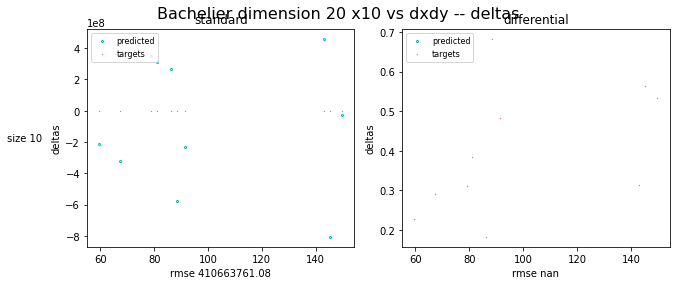

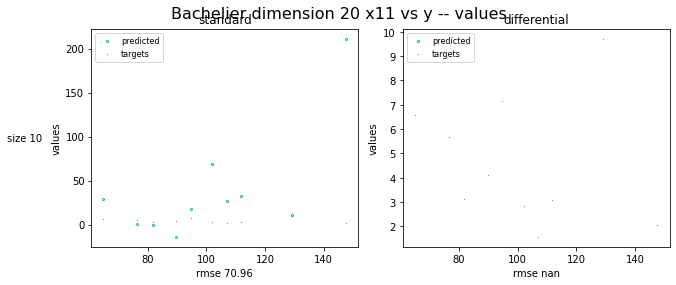

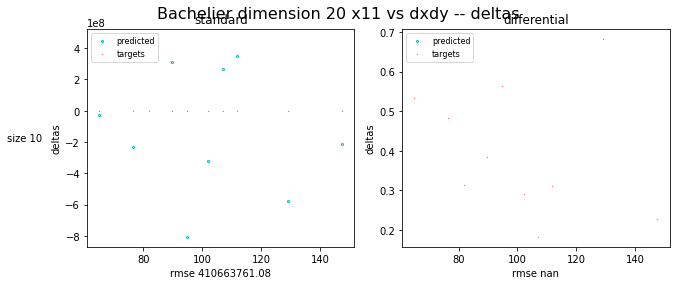

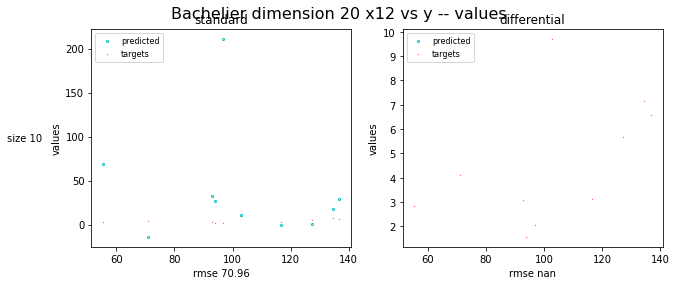

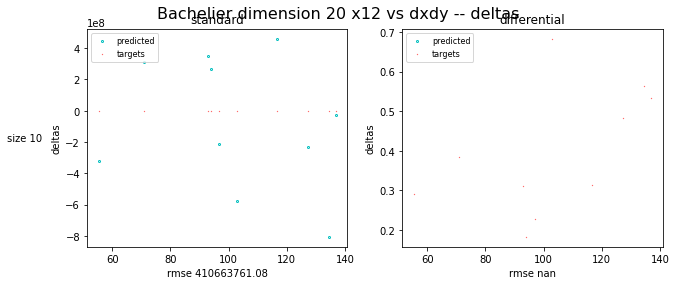

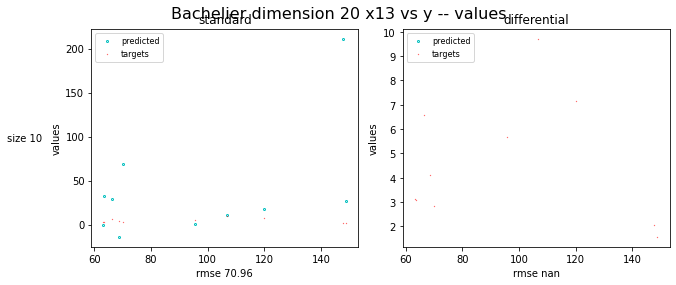

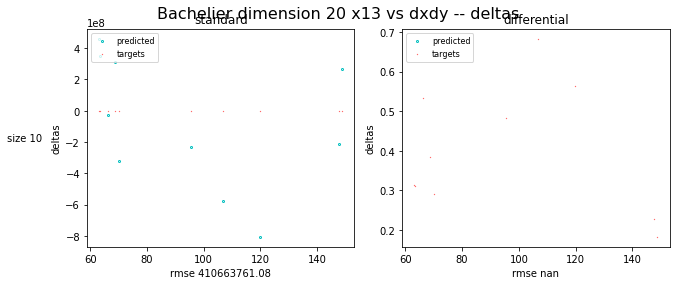

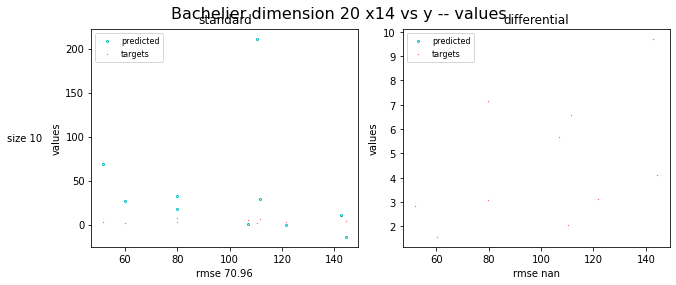

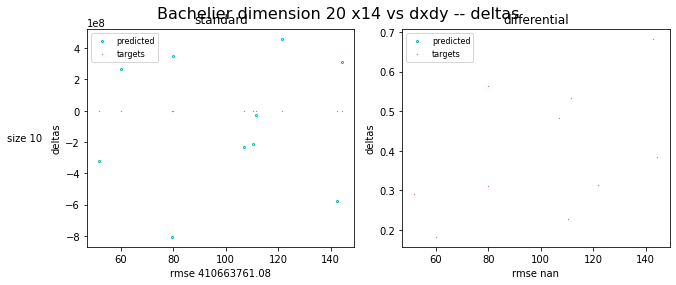

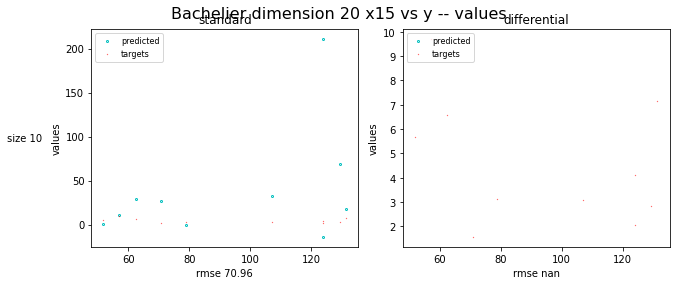

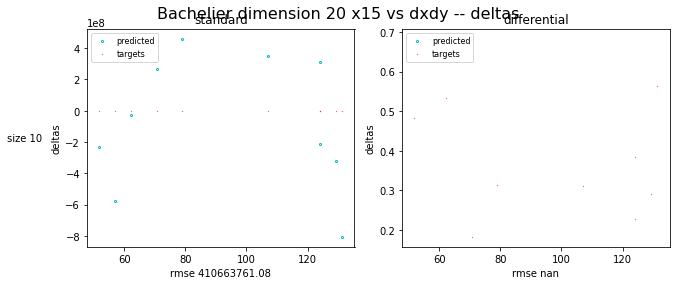

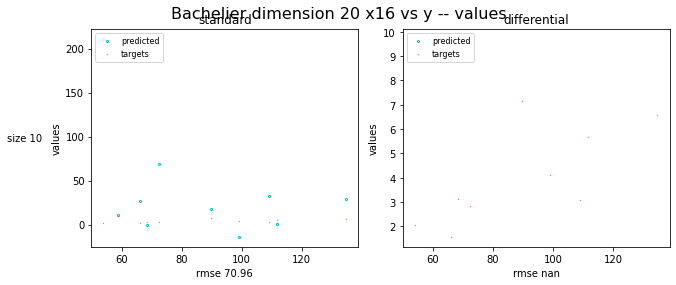

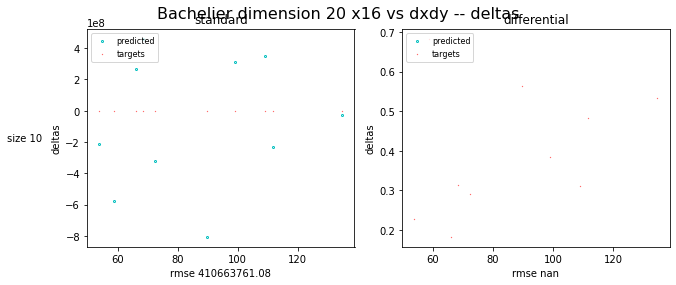

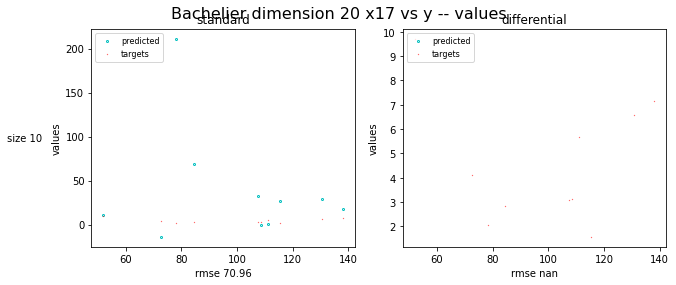

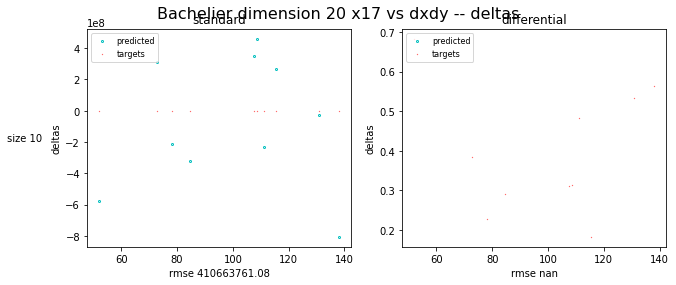

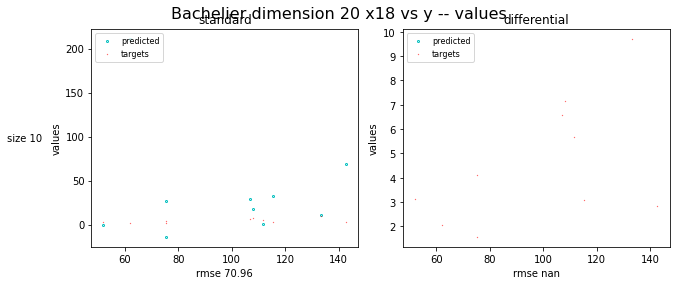

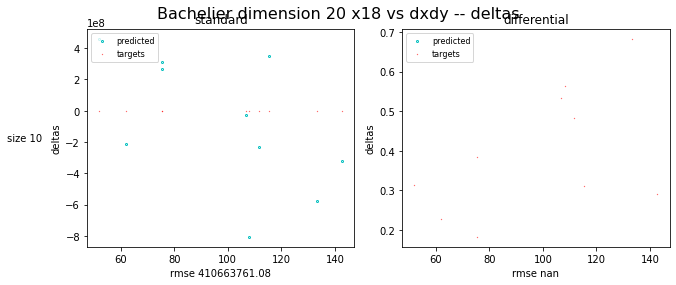

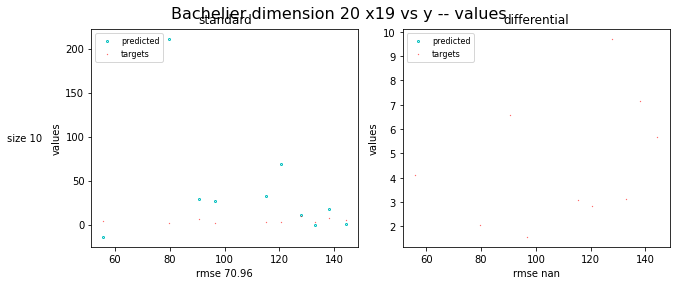

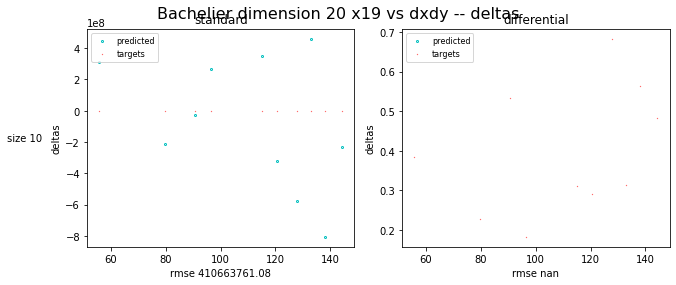

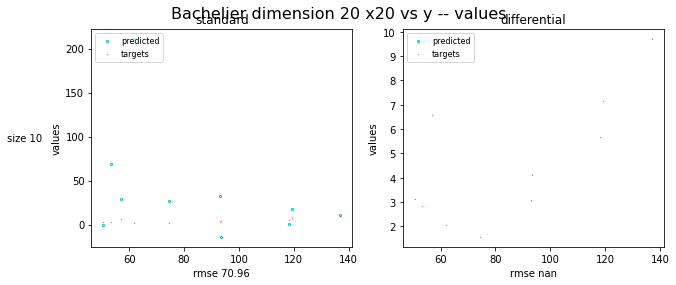

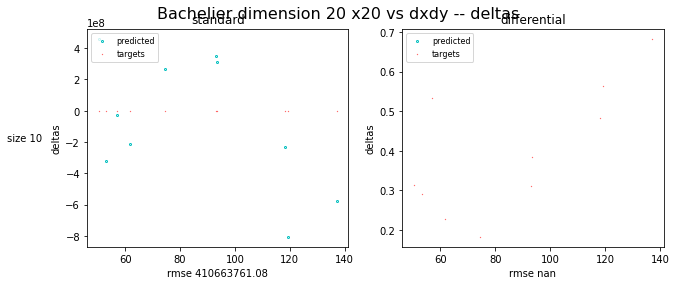

In [82]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN},
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM,
              siren = True)

### **2.3.5) twin_net with siren**

In [83]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, "outermost_linear" : outermost_linear, "first_omega_0" : first_omega_0, 
                "hidden_omega_0" : hidden_omega_0}
                
with_derivative = True

Epoch 0: train loss: 0.0075805773958563805, y loss : 0.0059844511561095715, dy loss : 0.0015961260069161654
train loss no scaled: 0.007580577163025737, y loss  no scaled : 0.0059844511561095715, dy loss  no scaled: 0.0015961260069161654
Epoch 1: train loss: 0.007453054655343294, y loss : 0.005917057860642672, dy loss : 0.0015359969111159444
train loss no scaled: 0.007453054771758616, y loss  no scaled : 0.005917057860642672, dy loss  no scaled: 0.0015359969111159444
Epoch 2: train loss: 0.007336537819355726, y loss : 0.005914530251175165, dy loss : 0.001422007568180561
train loss no scaled: 0.007336537819355726, y loss  no scaled : 0.005914530251175165, dy loss  no scaled: 0.001422007568180561
Epoch 3: train loss: 0.007251115515828133, y loss : 0.005896634887903929, dy loss : 0.0013544803950935602
train loss no scaled: 0.007251115282997489, y loss  no scaled : 0.005896634887903929, dy loss  no scaled: 0.0013544803950935602
Epoch 4: train loss: 0.007171230856329203, y loss : 0.005902051

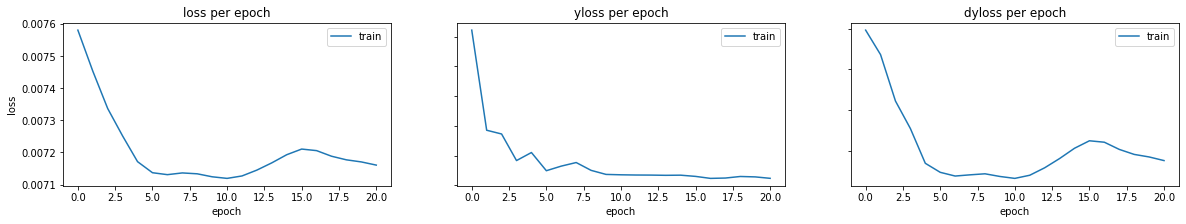

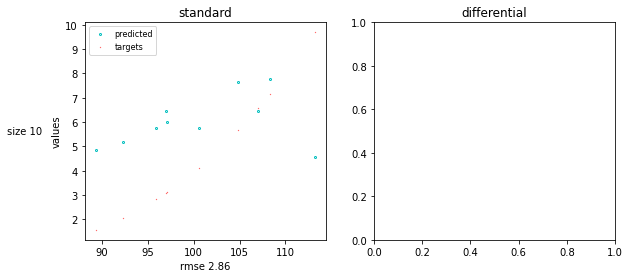

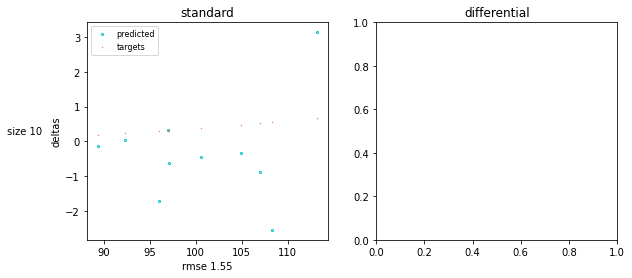

In [84]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = Siren, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = False)

Epoch 0: train loss: 1.074214873841815, y loss : 1.0127995014190674, dy loss : 1.0772856432080105
train loss no scaled: 0.006915106263477355, y loss  no scaled : 0.005958923138678074, dy loss  no scaled: 0.0009561831247992814
Epoch 1: train loss: 1.0441510695419944, y loss : 1.0091893672943115, dy loss : 1.0458991552131722
train loss no scaled: 0.006892026402056217, y loss  no scaled : 0.005937682930380106, dy loss  no scaled: 0.0009543434716761112
Epoch 2: train loss: 1.0339332893702193, y loss : 1.006698489189148, dy loss : 1.0352950299380665
train loss no scaled: 0.006876184605062008, y loss  no scaled : 0.005923026707023382, dy loss  no scaled: 0.0009531578980386257
Epoch 3: train loss: 1.0117027866965889, y loss : 1.005123257637024, dy loss : 1.0120317612869218
train loss no scaled: 0.006859027547761798, y loss  no scaled : 0.005913757719099522, dy loss  no scaled: 0.0009452698286622763
Epoch 4: train loss: 1.0026400615182247, y loss : 1.0039818286895752, dy loss : 1.0025729733459

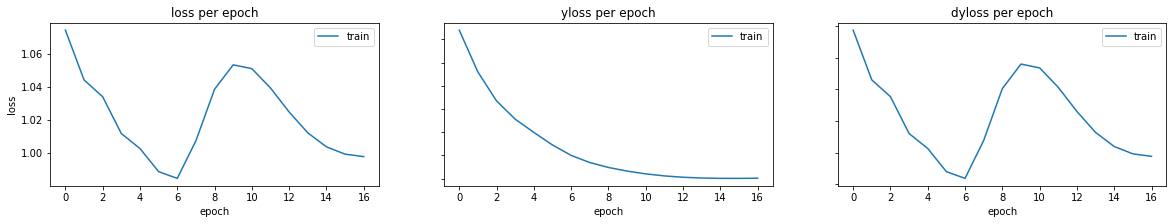

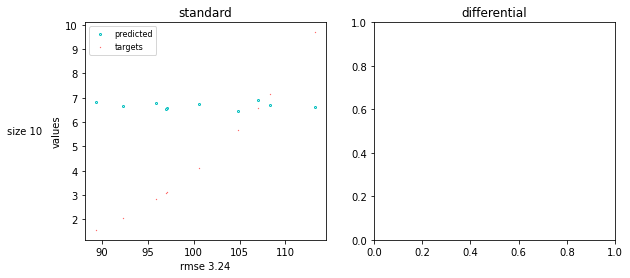

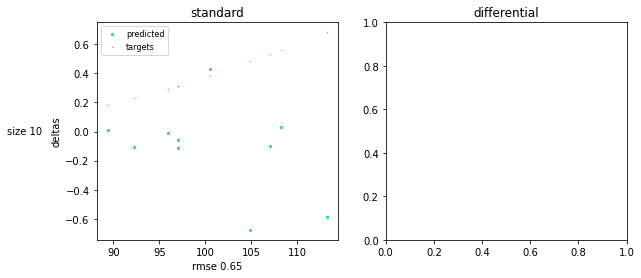

In [85]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = Siren, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = True)

### **2.3.6) twin_net with MLP**

In [86]:
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, 
                "activation_function" : F.softplus, # This is what was done in the original code.
                "deriv_activation_function" : F.sigmoid
                }
                
with_derivative = True

Epoch 0: train loss: 0.31093263626098633, y loss : 0.3101915121078491, dy loss : 0.0007411195547319949
train loss no scaled: 0.3109326316625811, y loss  no scaled : 0.3101915121078491, dy loss  no scaled: 0.0007411195547319949
Epoch 1: train loss: 0.309047132730484, y loss : 0.308305948972702, dy loss : 0.0007411821861751378
train loss no scaled: 0.30904713115887716, y loss  no scaled : 0.308305948972702, dy loss  no scaled: 0.0007411821861751378
Epoch 2: train loss: 0.3071724474430084, y loss : 0.30643120408058167, dy loss : 0.0007412447012029588
train loss no scaled: 0.3071724487817846, y loss  no scaled : 0.30643120408058167, dy loss  no scaled: 0.0007412447012029588
Epoch 3: train loss: 0.30530866980552673, y loss : 0.3045673668384552, dy loss : 0.0007413070416077971
train loss no scaled: 0.305308673880063, y loss  no scaled : 0.3045673668384552, dy loss  no scaled: 0.0007413070416077971
Epoch 4: train loss: 0.30345582962036133, y loss : 0.302714467048645, dy loss : 0.0007413693238

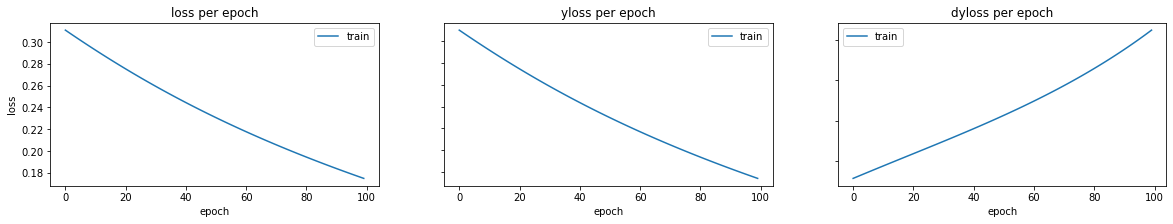

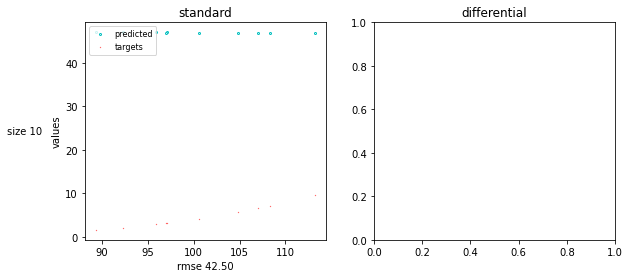

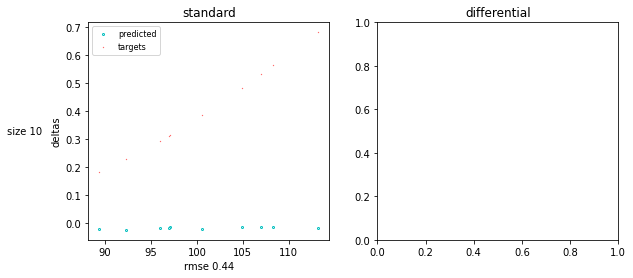

In [87]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = False)

Epoch 0: train loss: 1.0282366775962926, y loss : 1.585371971130371, dy loss : 1.0003799144097048
train loss no scaled: 0.010275254200678319, y loss  no scaled : 0.009327717125415802, dy loss  no scaled: 0.0009475370752625167
Epoch 1: train loss: 1.0280785773071701, y loss : 1.5820395946502686, dy loss : 1.0003805256949572
train loss no scaled: 0.010255654051434249, y loss  no scaled : 0.00930811371654272, dy loss  no scaled: 0.0009475403348915279
Epoch 2: train loss: 1.027921242734565, y loss : 1.5787227153778076, dy loss : 1.0003811664946998
train loss no scaled: 0.010236141213681549, y loss  no scaled : 0.009288597851991653, dy loss  no scaled: 0.0009475433616898954
Epoch 3: train loss: 1.0277646431321055, y loss : 1.5754207372665405, dy loss : 1.0003818358176806
train loss no scaled: 0.010216715338174254, y loss  no scaled : 0.009269168600440025, dy loss  no scaled: 0.0009475467377342284
Epoch 4: train loss: 1.0276088022742926, y loss : 1.5721338987350464, dy loss : 1.0003825429809

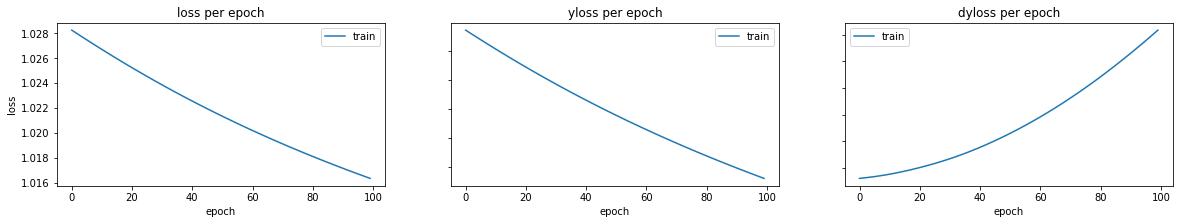

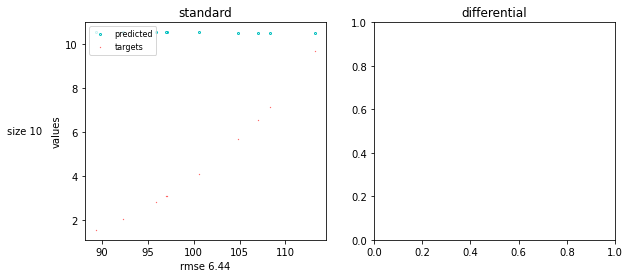

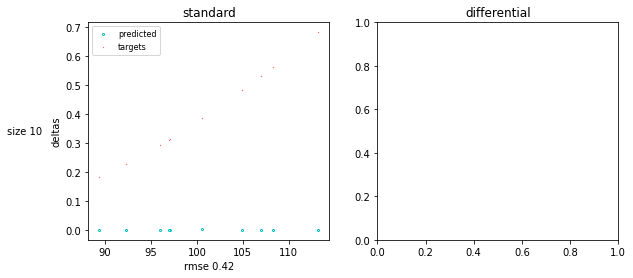

In [88]:
twinNet, loss = run_twinNet_train(graph_name, generator, with_derivative, model_class = MLP, 
                                  model_kwargs = model_kwargs, deltidx = 0,
                                  normalize = True)